## Imports

In [1]:
import math
import os
import time
import random
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy.stats as stats

In [2]:
# from feature_extractor import FeatureExtractor
from dataentry import DataEntry
from helpers import jaccard, change_imgpath, vconcat_resize_min, hconcat_resize_max
from utils import *

In [3]:
# Set seed
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(RANDOMSEED)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(RANDOMSEED)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(RANDOMSEED)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
from tensorflow.random import set_seed
set_seed(RANDOMSEED)

## Functions

In [4]:
def humanfriendly_trafo(path):
    """ transforms a path and returns the last element (file name) of the path

    Takes as input:
     str (path)
     list of str
     list of list of str

    :param path: str or list, path to be transformed
    :return: file names of input paths in input format
    """
    if type(path) is str:
        return path.split("/")[-1]
    elif type(path[0]) is str:
        return [entry.split("/")[-1] for entry in path]
    else:
        return [[entry.split("/")[-1] for entry in lst] for lst in path]


def show_humanfriendly(df, columns=["image_name", "near_hits", "near_misses", "top_misses"]):
    """

    :param df: pandas.DataFrame, DataFrame which shall be shown in an easily readable manner
    :param columns: list, list of column names which shall be transformed
    :return: pandas.DataFrame with shortened paths
    """
    dfh = df.copy()
    for c in columns:
        dfh[c] = [humanfriendly_trafo(row) for row in df[c]]
    return dfh

In [5]:
def jaccard_df(df1, df2, method="intersection"):
    """ Calculates Jaccard Index over whole dataframe per row, best put in two column vectors

    :param df1: pandas.DataFrame, first df to be compared
    :param df2: pandas.DataFrame, second df to be compared to df2
    :param method: str, method according to function **jaccard**
    :return: column vector with Jaccard Indeices
    """
    if type(df1[0][0]) is list:
        result = [jaccard(list(chain.from_iterable(l1)), list(chain.from_iterable(l2)), method) for
                  l1, l2 in zip(df1, df2)]
        return result
    else:
        result = [jaccard(l1, l2, method) for l1, l2 in zip(df1, df2)]
        return result

## Load pickles

In [6]:
# predefine names
m0000_eucl = m0000_ssim = m0000_cw = []
m0001_eucl = m0001_ssim = m0001_cw = []
m0010_eucl = m0010_ssim = m0010_cw = []
m0011_eucl = m0011_ssim = m0011_cw = []
m0100_eucl = m0101_eucl = []

o1000_eucl = o1000_ssim = []
o1001_eucl = o1001_ssim = []
o1010_eucl = o1010_ssim = []
o1011_eucl = o1011_ssim = []
o1100_eucl = o1101_eucl = []

all_df = {"0000_eucl": m0000_eucl, "0000_ssim": m0000_ssim, "0000_cw": m0000_cw,
          "0001_eucl": m0001_eucl, "0001_ssim": m0001_ssim, "0001_cw": m0001_cw,
          "0010_eucl": m0010_eucl, "0010_ssim": m0010_ssim, "0010_cw": m0010_cw,
          "0011_eucl": m0011_eucl, "0011_ssim": m0011_ssim, "0011_cw": m0011_cw,
          "0100_eucl": m0100_eucl, "0101_eucl": m0101_eucl, 
          "1000_eucl": o1000_eucl, "1000_ssim": o1000_ssim,
          "1001_eucl": o1001_eucl, "1001_ssim": o1001_ssim,
          "1010_eucl": o1010_eucl, "1010_ssim": o1010_ssim,
          "1011_eucl": o1011_eucl, "1011_ssim": o1011_ssim,
          "1100_eucl": o1100_eucl, "1101_eucl": o1101_eucl
         }

mnist_df_names = ["0000_eucl", "0000_ssim", "0000_cw",
          "0001_eucl", "0001_ssim", "0001_cw",
          "0010_eucl", "0010_ssim", "0010_cw",
          "0011_eucl", "0011_ssim", "0011_cw",
          "0100_eucl", "0101_eucl"]

oct_df_names = ["1000_eucl", "1000_ssim",
          "1001_eucl", "1001_ssim",
          "1010_eucl", "1010_ssim",
          "1011_eucl", "1011_ssim",
          "1100_eucl", "1101_eucl"]

In [7]:
# load all pickles
for df in all_df:
    picklepath = "/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/" + df + \
                 "_FINAL100.pickle"
    print(picklepath)
    all_df[df] = pd.read_pickle(picklepath)

/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0000_eucl_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0000_ssim_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0000_cw_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0001_eucl_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0001_ssim_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0001_cw_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0010_eucl_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0010_ssim_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/0010_cw_FINAL100.pickle
/Users/biancazimmer/Documents/PycharmProjec

In [8]:
mnist_df = {df_name: all_df[df_name] for df_name in all_df if df_name in mnist_df_names}
oct_df = {df_name: all_df[df_name] for df_name in all_df if df_name in oct_df_names}

## Overview over distance scores

### MNIST

In [9]:
# generate column names
scores_names = []
scores_top_names = []
for m in mnist_df:
    scores_names.append("scores_hit_"+m)
    scores_top_names.append("scores_top_misses_"+m)

# metrics
eucl = [0, 3, 6, 9, 12, 13]
ssim = [1, 4, 7, 10]
cw = [2, 5, 8, 11]

scores_top_names

['scores_top_misses_0000_eucl',
 'scores_top_misses_0000_ssim',
 'scores_top_misses_0000_cw',
 'scores_top_misses_0001_eucl',
 'scores_top_misses_0001_ssim',
 'scores_top_misses_0001_cw',
 'scores_top_misses_0010_eucl',
 'scores_top_misses_0010_ssim',
 'scores_top_misses_0010_cw',
 'scores_top_misses_0011_eucl',
 'scores_top_misses_0011_ssim',
 'scores_top_misses_0011_cw',
 'scores_top_misses_0100_eucl',
 'scores_top_misses_0101_eucl']

In [10]:
mnist_scores = pd.DataFrame()

for score_hit, score_top, df in zip(scores_names, scores_top_names, mnist_df.values()):
    mnist_scores[score_hit] = list(chain.from_iterable(df.scores_hits))
    mnist_scores[score_top] = list(chain.from_iterable(df.scores_top_misses))
mnist_scores

scores_hit_0000_eucl  scores_top_misses_0000_eucl  scores_hit_0000_ssim  \
0             3301.549636                  3527.858557              0.097736   
1             3341.854126                  3536.790777              0.100471   
2             3354.680164                  3530.186256              0.125946   
3             3360.696505                  3541.088392              0.127846   
4             3375.719775                  3541.779073              0.139758   
..                    ...                          ...                   ...   
495           2949.826775                  3144.982035              0.166094   
496           2988.068440                  3125.293906              0.185008   
497           2997.573852                  3124.189975              0.194827   
498           3005.094341                  3106.259326              0.201912   
499           3010.791424                  3103.462905              0.206926   

     scores_top_misses_0000_ssim  scores_hit_0000_cw  \
0                       0.384502            0.146025   
1                       0.387037            0.147668   
2                       0.376311            0.155654   
3                       0.384206            0.157089   
4                       0.381991            0.157362   
..                           ...                 ...   
495                     0.342092            0.228146   
496                     0.339808            0.231911   
497                     0.333386            0.243894   
498                     0.349669            0.252423   
499                     0.347098            0.256763   

     scores_top_misses_0000_cw  scores_hit_0001_eucl  \
0                     0.304944           3301.549636   
1                     0.359971           3341.854126   
2                     0.346612           3354.680164   
3                     0.364064           3360.696505   
4                     0.360178           3375.719775   
..                         ...                   ...   
495                   0.415283           2949.826775   
496                   0.383037           2988.068440   
497                   0.415715           2997.573852   
498                   0.420524           3005.094341   
499                   0.418325           3010.791424   

     scores_top_misses_0001_eucl  scores_hit_0001_ssim  \
0                    3527.858557              0.097736   
1                    3536.790777              0.100471   
2                    3530.186256              0.125946   
3                    3541.088392              0.127846   
4                    3541.779073              0.139758   
..                           ...                   ...   
495                  3144.982035              0.166094   
496                  3125.293906              0.185008   
497                  3124.189975              0.194827   
498                  3106.259326              0.201912   
499                  3103.462905              0.206926   

     scores_top_misses_0001_ssim  ...  scores_hit_0011_eucl  \
0                       0.384502  ...          15909.887680   
1                       0.387037  ...          16089.418976   
2                       0.376311  ...          16158.669747   
3                       0.384206  ...          16196.191589   
4                       0.381991  ...          16196.385337   
..                           ...  ...                   ...   
495                     0.342092  ...          11535.565439   
496                     0.339808  ...          11909.779763   
497                     0.333386  ...          12012.908640   
498                     0.349669  ...          12066.072186   
499                     0.347098  ...          12091.525586   

     scores_top_misses_0011_eucl  scores_hit_0011_ssim  \
0                   19043.405131              0.017076   
1                   18392.331119              0.017660   
2                   18692.178391              0.017815   
3           

In [11]:
mnist_scores_long = mnist_scores.stack().reset_index()
mnist_scores_long.columns = ["id", "group", "value"]
mnist_scores_long["nhnm"] = [t.split("_")[-3] for t in mnist_scores_long["group"]]
mnist_scores_long["number"] = [t.split("_")[-2] for t in mnist_scores_long["group"]]
mnist_scores_long["distance"] = [t.split("_")[-1] for t in mnist_scores_long["group"]]
mnist_scores_long

id                        group        value    nhnm number distance
0        0         scores_hit_0000_eucl  3301.549636     hit   0000     eucl
1        0  scores_top_misses_0000_eucl  3527.858557  misses   0000     eucl
2        0         scores_hit_0000_ssim     0.097736     hit   0000     ssim
3        0  scores_top_misses_0000_ssim     0.384502  misses   0000     ssim
4        0           scores_hit_0000_cw     0.146025     hit   0000       cw
...    ...                          ...          ...     ...    ...      ...
13995  499    scores_top_misses_0011_cw     0.476410  misses   0011       cw
13996  499         scores_hit_0100_eucl     0.001554     hit   0100     eucl
13997  499  scores_top_misses_0100_eucl     0.006213  misses   0100     eucl
13998  499         scores_hit_0101_eucl   645.267822     hit   0101     eucl
13999  499  scores_top_misses_0101_eucl   735.428528  misses   0101     eucl

[14000 rows x 6 columns]

In [12]:
mnist_scores.describe().transpose()

count          mean          std          min  \
scores_hit_0000_eucl         500.0   2900.166683   378.558146  1760.036079   
scores_top_misses_0000_eucl  500.0   3007.001927   371.723789  2096.680949   
scores_hit_0000_ssim         500.0      0.121990     0.046063     0.030004   
scores_top_misses_0000_ssim  500.0      0.276013     0.057027     0.113198   
scores_hit_0000_cw           500.0      0.130239     0.059218     0.023118   
scores_top_misses_0000_cw    500.0      0.309523     0.087351     0.115221   
scores_hit_0001_eucl         500.0   2900.166683   378.558146  1760.036079   
scores_top_misses_0001_eucl  500.0   3007.001927   371.723789  2096.680949   
scores_hit_0001_ssim         500.0      0.121990     0.046063     0.030004   
scores_top_misses_0001_ssim  500.0      0.276013     0.057027     0.113198   
scores_hit_0001_cw           500.0      0.130239     0.059218     0.023118   
scores_top_misses_0001_cw    500.0      0.309523     0.087351     0.115221   
scores_hit_0010_eucl         500.0   3668.389340  1082.984291   385.227206   
scores_top_misses_0010_eucl  500.0    391.559262    65.413345   231.090891   
scores_hit_0010_ssim         500.0      0.035371     0.011963     0.006847   
scores_top_misses_0010_ssim  500.0      0.050379     0.011503     0.023472   
scores_hit_0010_cw           500.0      0.242790     0.058312     0.091293   
scores_top_misses_0010_cw    500.0      0.393594     0.052418     0.252747   
scores_hit_0011_eucl         500.0  14577.310735  3323.819211  6833.858646   
scores_top_misses_0011_eucl  500.0  16588.650260  3943.339970  6563.444675   
scores_hit_0011_ssim         500.0      0.021937     0.009244     0.002158   
scores_top_misses_0011_ssim  500.0      0.027905     0.011411     0.006296   
scores_hit_0011_cw           500.0      0.360986     0.062867     0.179118   
scores_top_misses_0011_cw    500.0      0.471858     0.051720     0.357427   
scores_hit_0100_eucl         500.0      0.001170     0.000409     0.000406   
scores_top_misses_0100_eucl  500.0      0.003002     0.001464     0.001170   
scores_hit_0101_eucl         500.0    506.197645   102.964081   251.262543   
scores_top_misses_0101_eucl  500.0    655.250339    81.768893   485.442871   

                                      25%           50%           75%  \
scores_hit_0000_eucl          2671.736790   2928.308298   3193.046230   
scores_top_misses_0000_eucl   2765.529182   2992.429781   3310.703426   
scores_hit_0000_ssim             0.088983      0.126911      0.150714   
scores_top_misses_0000_ssim      0.228463      0.277143      0.316406   
scores_hit_0000_cw               0.084895      0.129582      0.162821   
scores_top_misses_0000_cw        0.246364      0.302538      0.356877   
scores_hit_0001_eucl          2671.736790   2928.308298   3193.046230   
scores_top_misses_0001_eucl   2765.529182   2992.429781   3310.703426   
scores_hit_0001_ssim             0.088983      0.126911      0.150714   
scores_top_misses_0001_ssim      0.228463      0.277143      0.316406   
scores_hit_0001_cw               0.084895      0.129582      0.162821   
scores_top_misses_0001_cw        0.246364      0.302538      0.356877   
scores_hit_0010_eucl          3071.621305   4149.917343   4371.644249   
scores_top_misses_0010_eucl    354.213202    385.792667    431.200063   
scores_hit_0010_ssim             0.026071      0.036326      0.042582   
scores_top_misses_0010_ssim      0.041179      0.049665      0.058719   
scores_hit_0010_cw               0.203188      0.248230      0.285874   
scores_top_misses_0010_cw        0.363970      0.394191      0.432149   
scores_hit_0011_eucl         12153.113165  14760.574850  16535.624202   
scores_top_misses_0011_eucl  13920.517719  16649.462862  18843.435328   
scores_hit_0011_ssim             0.015658      0.021657      0.026937   
scores_top_misses_0011_ssim      0.020018      0.027394      0.034138   
scores_hit_0011_cw               0.329233      0.369293      0.401596   
scores_top_mis

#### Distances for Hits

<function matplotlib.pyplot.show(*args, **kw)>

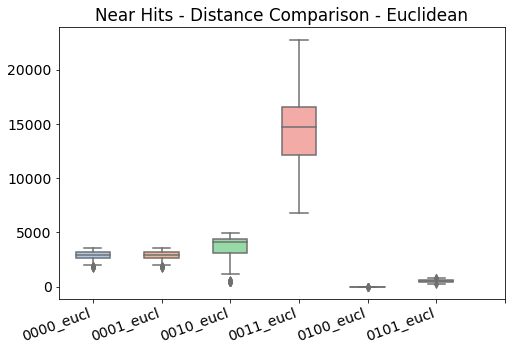

In [13]:
plt.rcParams.update({'font.size': 14})

cols = [scores_names[i] for i in eucl]
plt.figure(figsize=(8,5))
#plt.rcParams.update(plt.rcParamsDefault)
sns.boxplot(data=mnist_scores[cols], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(cols)+1),
           labels=[name.split("_",2)[2] for name in cols],
           rotation=20, ha="right")
plt.title("Near Hits - Distance Comparison - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

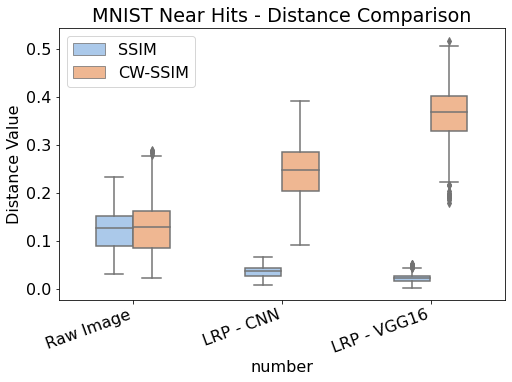

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,5))
sns.boxplot(x=mnist_scores_long["number"][(mnist_scores_long["distance"] != "eucl") &
                                         (mnist_scores_long["number"] != "0001")],
            y=mnist_scores_long["value"][(mnist_scores_long["nhnm"] == "hit") &
                                         (mnist_scores_long["distance"] != "eucl")],
            palette="pastel", width=0.5,
            hue=mnist_scores_long["distance"][mnist_scores_long["distance"] != "eucl"])
plt.xticks(ticks=range(0, 3),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('SSIM')
L.get_texts()[1].set_text('CW-SSIM')
plt.title("MNIST Near Hits - Distance Comparison")
plt.show

#### Distances for Top Misses

<function matplotlib.pyplot.show(*args, **kw)>

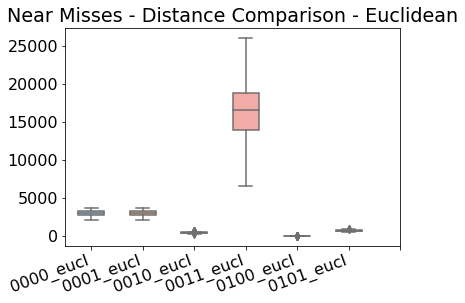

In [15]:
cols = [scores_top_names[i] for i in eucl]
sns.boxplot(data=mnist_scores[cols], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(cols)+1),
           labels=[name.split("_",3)[3] for name in cols],
           rotation=20, ha="right")
plt.title("Near Misses - Distance Comparison - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

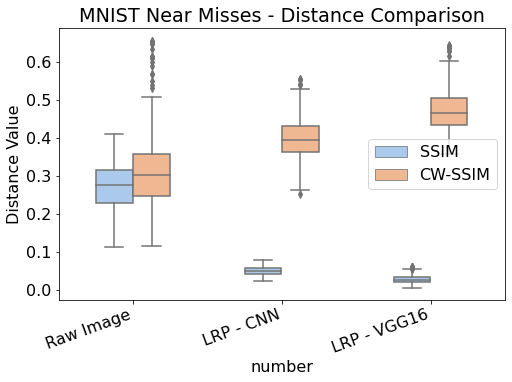

In [16]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,5))
sns.boxplot(x=mnist_scores_long["number"][(mnist_scores_long["distance"] != "eucl") &
                                         (mnist_scores_long["number"] != "0001")],
            y=mnist_scores_long["value"][(mnist_scores_long["nhnm"] == "misses") &
                                         (mnist_scores_long["distance"] != "eucl")],
            palette="pastel", width=0.5,
            hue=mnist_scores_long["distance"][mnist_scores_long["distance"] != "eucl"])
plt.xticks(ticks=range(0, 3),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('SSIM')
L.get_texts()[1].set_text('CW-SSIM')
plt.title("MNIST Near Misses - Distance Comparison")
plt.show

#### Compare misses + hits

In [17]:
mnist_scores.describe().transpose()[["mean","50%"]]

mean           50%
scores_hit_0000_eucl          2900.166683   2928.308298
scores_top_misses_0000_eucl   3007.001927   2992.429781
scores_hit_0000_ssim             0.121990      0.126911
scores_top_misses_0000_ssim      0.276013      0.277143
scores_hit_0000_cw               0.130239      0.129582
scores_top_misses_0000_cw        0.309523      0.302538
scores_hit_0001_eucl          2900.166683   2928.308298
scores_top_misses_0001_eucl   3007.001927   2992.429781
scores_hit_0001_ssim             0.121990      0.126911
scores_top_misses_0001_ssim      0.276013      0.277143
scores_hit_0001_cw               0.130239      0.129582
scores_top_misses_0001_cw        0.309523      0.302538
scores_hit_0010_eucl          3668.389340   4149.917343
scores_top_misses_0010_eucl    391.559262    385.792667
scores_hit_0010_ssim             0.035371      0.036326
scores_top_misses_0010_ssim      0.050379      0.049665
scores_hit_0010_cw               0.242790      0.248230
scores_top_misses_0010_cw        0.393594      0.394191
scores_hit_0011_eucl         14577.310735  14760.574850
scores_top_misses_0011_eucl  16588.650260  16649.462862
scores_hit_0011_ssim             0.021937      0.021657
scores_top_misses_0011_ssim      0.027905      0.027394
scores_hit_0011_cw               0.360986      0.369293
scores_top_misses_0011_cw        0.471858      0.466365
scores_hit_0100_eucl             0.001170      0.001160
scores_top_misses_0100_eucl      0.003002      0.002564
scores_hit_0101_eucl           506.197645    520.278717
scores_top_misses_0101_eucl    655.250339    639.279999

<function matplotlib.pyplot.show(*args, **kw)>

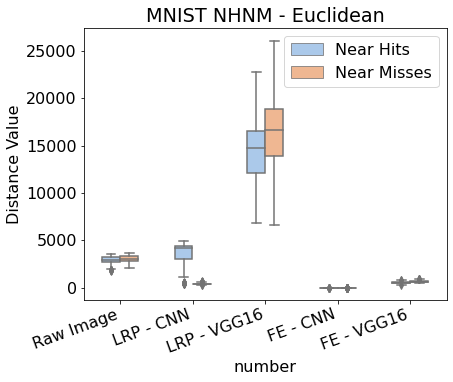

In [18]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6.5,5))
sns.boxplot(x=mnist_scores_long["number"][(mnist_scores_long["number"] != "0001")],
            y=mnist_scores_long["value"][(mnist_scores_long["distance"] == "eucl") &
                                         (mnist_scores_long["number"] != "0001")],
            palette="pastel", width=0.5,
            hue=mnist_scores_long["nhnm"])
plt.xticks(ticks=range(0, 5),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16", "FE - CNN", "FE - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('Near Hits')
L.get_texts()[1].set_text('Near Misses')
plt.title("MNIST NHNM - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

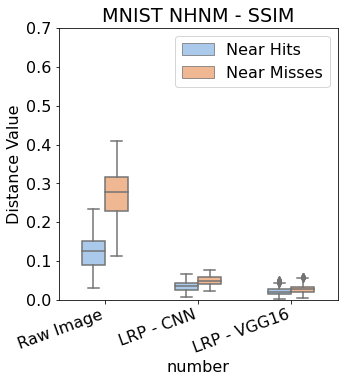

In [19]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5,5))
sns.boxplot(x=mnist_scores_long["number"][(mnist_scores_long["distance"] == "ssim") &
                                         (mnist_scores_long["number"] != "0001")],
            y=mnist_scores_long["value"][(mnist_scores_long["distance"] == "ssim") &
                                         (mnist_scores_long["number"] != "0001")],
            palette="pastel", width=0.5,
            hue=mnist_scores_long["nhnm"])
plt.xticks(ticks=range(0, 3),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('Near Hits')
L.get_texts()[1].set_text('Near Misses')
plt.ylim([0,0.7])
plt.title("MNIST NHNM - SSIM")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

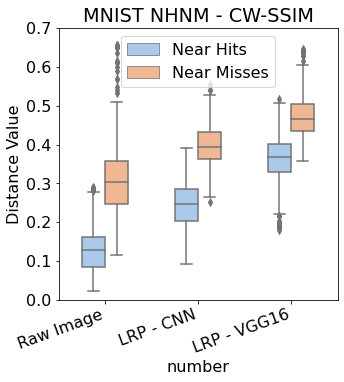

In [20]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5,5))
sns.boxplot(x=mnist_scores_long["number"][(mnist_scores_long["distance"] == "cw") &
                                         (mnist_scores_long["number"] != "0001")],
            y=mnist_scores_long["value"][(mnist_scores_long["distance"] == "cw") &
                                         (mnist_scores_long["number"] != "0001")],
            palette="pastel", width=0.5,
            hue=mnist_scores_long["nhnm"])
plt.xticks(ticks=range(0, 3),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('Near Hits')
L.get_texts()[1].set_text('Near Misses')
plt.ylim([0,0.7])
plt.title("MNIST NHNM - CW-SSIM")
plt.show

#### Results:
all distance measures:
* distances for misses are higher than for hits as expected; exception: 0010_euclidean, here distances for misses are a lot lower
* distances of near hits behave about the same as distances of near misses.

euclidean distances:
* euclidean distances for 0011 (lrp + vgg) are a lot higher than all the other euclidean distances -> vgg does not perform well -> as expected
* euclidean distances for 0101 are also higher than those of 0100 -> vgg does not perform well
* euclidean distances for FE are a lot smaller than those of LRP -> to be expected since euclidean distanmce might not be the optimal citerion here

SSIM + CW-SSIM:
* SSIM distances are generally lower than those of the CW-SSIM; this could be due to the fact that rotation + translation is not taken into account and a lot of the images are black; otherwise this is contra-intuitive
* SSIM on the LRP heatmaps are a lot smaller than on the raw images; this could be due to the fact that a lot more of the LRP heatmaps share the same color (grey) than the original image (black); this observation can not be seen in the CW-LRP heatmaps vs the CW-raw images

### OCT

In [21]:
# generate column names
scores_names = []
scores_top_names = []
for m in oct_df:
    scores_names.append("scores_hit_"+m)
    scores_top_names.append("scores_top_misses_"+m)

# metrics
eucl = [0, 2, 4, 6, 8, 9]
ssim = [1, 3, 5, 7]

scores_top_names

['scores_top_misses_1000_eucl',
 'scores_top_misses_1000_ssim',
 'scores_top_misses_1001_eucl',
 'scores_top_misses_1001_ssim',
 'scores_top_misses_1010_eucl',
 'scores_top_misses_1010_ssim',
 'scores_top_misses_1011_eucl',
 'scores_top_misses_1011_ssim',
 'scores_top_misses_1100_eucl',
 'scores_top_misses_1101_eucl']

In [22]:
oct_scores = pd.DataFrame()

for score_hit, score_top, df in zip(scores_names, scores_top_names, oct_df.values()):
    oct_scores[score_hit] = list(chain.from_iterable(df.scores_hits))
    oct_scores[score_top] = list(chain.from_iterable(df.scores_top_misses))
oct_scores

scores_hit_1000_eucl  scores_top_misses_1000_eucl  scores_hit_1000_ssim  \
0            45685.931062                 45253.254281              0.189405   
1            47323.463345                 47319.385256              0.192827   
2            47748.107774                 47549.907056              0.196069   
3            48403.030504                 48065.570724              0.199994   
4            49067.989107                 47555.152739              0.200841   
..                    ...                          ...                   ...   
495          51118.562137                 51619.735402              0.274887   
496          52227.259884                 51508.357302              0.279944   
497          53034.186295                 51934.025889              0.282964   
498          53402.495288                 52495.129174              0.283274   
499          53425.562159                 52795.549633              0.284505   

     scores_top_misses_1000_ssim  scores_hit_1001_eucl  \
0                       0.212470          45685.931062   
1                       0.214836          47323.463345   
2                       0.211121          47748.107774   
3                       0.217311          48403.030504   
4                       0.218173          49067.989107   
..                           ...                   ...   
495                     0.295332          51118.562137   
496                     0.295332          52227.259884   
497                     0.299912          53034.186295   
498                     0.299367          53402.495288   
499                     0.300725          53425.562159   

     scores_top_misses_1001_eucl  scores_hit_1001_ssim  \
0                   45253.254281              0.189405   
1                   47319.385256              0.192827   
2                   47549.907056              0.196069   
3                   48065.570724              0.199994   
4                   47555.152739              0.200841   
..                           ...                   ...   
495                 51619.735402              0.274887   
496                 51508.357302              0.279944   
497                 51934.025889              0.282964   
498                 52495.129174              0.283274   
499                 52795.549633              0.284505   

     scores_top_misses_1001_ssim  scores_hit_1010_eucl  \
0                       0.212470           6082.776093   
1                       0.214836           6347.453190   
2                       0.211121           7294.331018   
3                       0.217311           7414.364032   
4                       0.218173           7446.050027   
..                           ...                   ...   
495                     0.295332           8468.421459   
496                     0.295332           8712.156564   
497                     0.299912           8762.775930   
498                     0.299367           8891.557175   
499                     0.300725           8948.116170   

     scores_top_misses_1010_eucl  scores_hit_1010_ssim  \
0                    3031.170071              0.010903   
1                    2581.046687              0.011198   
2                    3071.738433              0.011332   
3                    2238.049150              0.011499   
4                    3067.488386              0.011544   
..                           ...                   ...   
495                  5482.886375              0.015655   
496                  5388.886341              0.015884   
497                  5388.886341              0.016041   
498                  5275.475334              0.016184   
499                  5275.475334              0.016234   

     scores_top_misses_1010_ssim  scores_hit_1011_eucl  \
0                       0.012790           6572.391498   
1                       0.012790           7702.463242   
2                       0.012835           9738.166614   
3                       

In [23]:
oct_scores_long = oct_scores.stack().reset_index()
oct_scores_long.columns = ["id", "group", "value"]
oct_scores_long["nhnm"] = [t.split("_")[-3] for t in oct_scores_long["group"]]
oct_scores_long["number"] = [t.split("_")[-2] for t in oct_scores_long["group"]]
oct_scores_long["distance"] = [t.split("_")[-1] for t in oct_scores_long["group"]]
oct_scores_long

id                        group         value    nhnm number distance
0       0         scores_hit_1000_eucl  45685.931062     hit   1000     eucl
1       0  scores_top_misses_1000_eucl  45253.254281  misses   1000     eucl
2       0         scores_hit_1000_ssim      0.189405     hit   1000     ssim
3       0  scores_top_misses_1000_ssim      0.212470  misses   1000     ssim
4       0         scores_hit_1001_eucl  45685.931062     hit   1001     eucl
...   ...                          ...           ...     ...    ...      ...
9995  499  scores_top_misses_1011_ssim      0.037505  misses   1011     ssim
9996  499         scores_hit_1100_eucl      0.000630     hit   1100     eucl
9997  499  scores_top_misses_1100_eucl      0.000652  misses   1100     eucl
9998  499         scores_hit_1101_eucl    750.386780     hit   1101     eucl
9999  499  scores_top_misses_1101_eucl    765.211853  misses   1101     eucl

[10000 rows x 6 columns]

In [24]:
oct_scores.describe().transpose()

count          mean          std           min  \
scores_hit_1000_eucl         500.0  53921.553053  5547.205299      0.000000   
scores_top_misses_1000_eucl  500.0  54932.381740  5345.045167  42088.484767   
scores_hit_1000_ssim         500.0      0.329700     0.059381      0.000000   
scores_top_misses_1000_ssim  500.0      0.326663     0.051730      0.211121   
scores_hit_1001_eucl         500.0  54120.445525  5103.940077  38791.659374   
scores_top_misses_1001_eucl  500.0  54739.022854  5780.371419      0.000000   
scores_hit_1001_ssim         500.0      0.331099     0.057019      0.189405   
scores_top_misses_1001_ssim  500.0      0.325870     0.053644      0.000000   
scores_hit_1010_eucl         500.0   8872.579930  5999.725743      0.000000   
scores_top_misses_1010_eucl  500.0   6846.518436  6918.498837    539.977777   
scores_hit_1010_ssim         500.0      0.013842     0.008246      0.000000   
scores_top_misses_1010_ssim  500.0      0.014234     0.008218      0.002208   
scores_hit_1011_eucl         500.0  12664.163573  5958.627311   2635.904399   
scores_top_misses_1011_eucl  500.0  14148.623233  6376.074907      0.000000   
scores_hit_1011_ssim         500.0      0.022736     0.014257      0.002214   
scores_top_misses_1011_ssim  500.0      0.022881     0.014341      0.000000   
scores_hit_1100_eucl         500.0      0.000694     0.000293      0.000000   
scores_top_misses_1100_eucl  500.0      0.000790     0.000397      0.000218   
scores_hit_1101_eucl         500.0    639.506036   115.981967    413.841553   
scores_top_misses_1101_eucl  500.0    692.172846   111.266373      0.000000   

                                      25%           50%           75%  \
scores_hit_1000_eucl         50680.819318  54315.102901  57214.760275   
scores_top_misses_1000_eucl  51235.701454  54787.688178  58676.842550   
scores_hit_1000_ssim             0.292771      0.326801      0.363898   
scores_top_misses_1000_ssim      0.291253      0.321978      0.359693   
scores_hit_1001_eucl         50680.819318  54365.163855  57401.694690   
scores_top_misses_1001_eucl  51235.701454  54770.436011  58430.982977   
scores_hit_1001_ssim             0.294832      0.326841      0.368174   
scores_top_misses_1001_ssim      0.291190      0.321080      0.359408   
scores_hit_1010_eucl          5389.935144   7299.079665  10412.385963   
scores_top_misses_1010_eucl   2513.334318   4555.077786   8401.957677   
scores_hit_1010_ssim             0.008328      0.012165      0.017158   
scores_top_misses_1010_ssim      0.008840      0.012503      0.018292   
scores_hit_1011_eucl          8199.584898  11912.510497  15968.860589   
scores_top_misses_1011_eucl   9443.952301  13512.521465  18096.941958   
scores_hit_1011_ssim             0.011120      0.019869      0.032393   
scores_top_misses_1011_ssim      0.011111      0.019974      0.032189   
scores_hit_1100_eucl             0.000505      0.000647      0.000802   
scores_top_misses_1100_eucl      0.000571      0.000700      0.000928   
scores_hit_1101_eucl           561.683533    622.924591    699.116852   
scores_top_misses_1101_eucl    622.658539    684.263000    756.349533   

                                      max  
scores_hit_1000_eucl         64639.606597  
scores_top_misses_1000_eucl  66984.742113  
scores_hit_1000_ssim             0.473614  
scores_top_misses_1000_ssim      0.449543  
scores_hit_1001_eucl         64892.480142  
scores_top_misses_1001_eucl  66984.742113  
scores_hit_1001_ssim             0.473614  
scores_top_misses_1001_ssim      0.449543  
scores_hit_1010_eucl         34792.323837  
scores_top_misses_1010_eucl  40609.105063  
scores_hit_1010_ssim             0.050804  
scores_top_misses_1010_ssim      0.050947  
scores_hit_1011_eucl         31500.347316  
scores_top_misses_1011_eucl  32545.225948  
scores_hit_1011_ssim             0.065967  
scores_top_misses_1011_ssim      0.066240  
scores_hit_1100_eucl             0.002662  
scores_top_misses_1100_eucl      0.003879  

In [25]:
oct_df["1000_eucl"]["image_name"].equals(oct_df["1001_eucl"]["image_name"])

True

#### Hits comparison

<function matplotlib.pyplot.show(*args, **kw)>

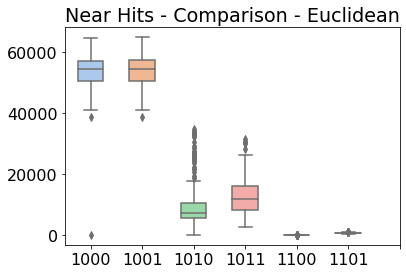

In [26]:
cols = [scores_names[i] for i in eucl]
sns.boxplot(data=oct_scores[cols], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(cols)+1),
           labels=[name.split("_")[2] for name in cols])
plt.title("Near Hits - Comparison - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

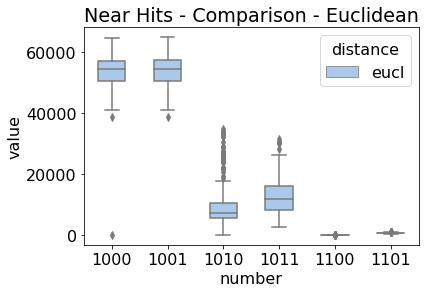

In [27]:
# same plot as above - different layout
sns.boxplot(x=oct_scores_long["number"][oct_scores_long["distance"] == "eucl"],
            y=oct_scores_long["value"][(oct_scores_long["nhnm"] == "hit") &
                                         (oct_scores_long["distance"] == "eucl")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["distance"][oct_scores_long["distance"] == "eucl"])
plt.title("Near Hits - Comparison - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

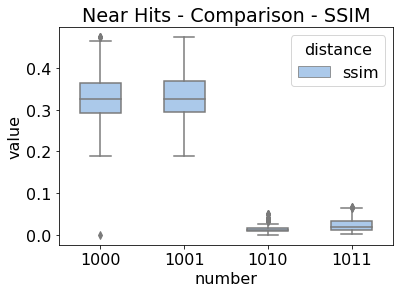

In [28]:
sns.boxplot(x=oct_scores_long["number"][oct_scores_long["distance"] != "eucl"],
            y=oct_scores_long["value"][(oct_scores_long["nhnm"] == "hit") &
                                         (oct_scores_long["distance"] != "eucl")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["distance"][oct_scores_long["distance"] != "eucl"])
plt.title("Near Hits - Comparison - SSIM")
plt.show

#### Misses Comparison

<function matplotlib.pyplot.show(*args, **kw)>

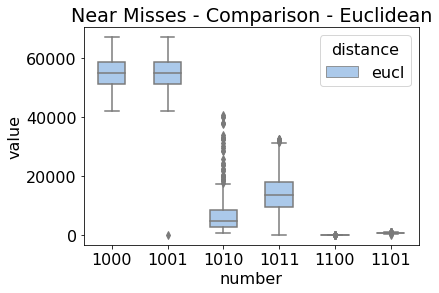

In [29]:
sns.boxplot(x=oct_scores_long["number"][oct_scores_long["distance"] == "eucl"],
            y=oct_scores_long["value"][(oct_scores_long["nhnm"] == "misses") &
                                         (oct_scores_long["distance"] == "eucl")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["distance"][oct_scores_long["distance"] == "eucl"])
plt.title("Near Misses - Comparison - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

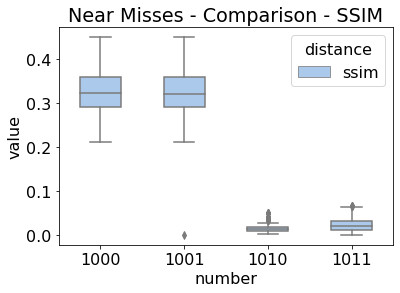

In [30]:
sns.boxplot(x=oct_scores_long["number"][oct_scores_long["distance"] != "eucl"],
            y=oct_scores_long["value"][(oct_scores_long["nhnm"] == "misses") &
                                         (oct_scores_long["distance"] != "eucl")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["distance"][oct_scores_long["distance"] != "eucl"])
plt.title("Near Misses - Comparison - SSIM")
plt.show

#### Compare misses+hits

In [31]:
oct_scores.describe().transpose()[["mean","50%"]]

mean           50%
scores_hit_1000_eucl         53921.553053  54315.102901
scores_top_misses_1000_eucl  54932.381740  54787.688178
scores_hit_1000_ssim             0.329700      0.326801
scores_top_misses_1000_ssim      0.326663      0.321978
scores_hit_1001_eucl         54120.445525  54365.163855
scores_top_misses_1001_eucl  54739.022854  54770.436011
scores_hit_1001_ssim             0.331099      0.326841
scores_top_misses_1001_ssim      0.325870      0.321080
scores_hit_1010_eucl          8872.579930   7299.079665
scores_top_misses_1010_eucl   6846.518436   4555.077786
scores_hit_1010_ssim             0.013842      0.012165
scores_top_misses_1010_ssim      0.014234      0.012503
scores_hit_1011_eucl         12664.163573  11912.510497
scores_top_misses_1011_eucl  14148.623233  13512.521465
scores_hit_1011_ssim             0.022736      0.019869
scores_top_misses_1011_ssim      0.022881      0.019974
scores_hit_1100_eucl             0.000694      0.000647
scores_top_misses_1100_eucl      0.000790      0.000700
scores_hit_1101_eucl           639.506036    622.924591
scores_top_misses_1101_eucl    692.172846    684.263000

<function matplotlib.pyplot.show(*args, **kw)>

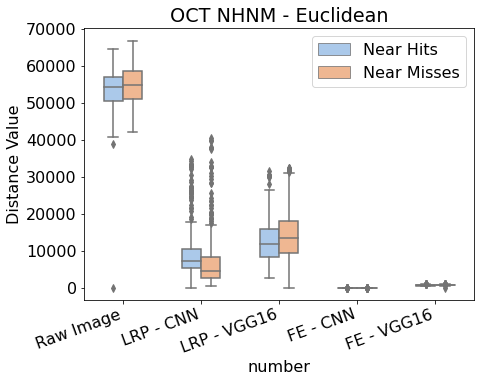

In [32]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7,5))
sns.boxplot(x=oct_scores_long["number"][(oct_scores_long["distance"] == "eucl")&
                                         (oct_scores_long["number"] != "1001")],
            y=oct_scores_long["value"][(oct_scores_long["distance"] == "eucl")&
                                         (oct_scores_long["number"] != "1001")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["nhnm"])
plt.xticks(ticks=range(0, 5),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16", "FE - CNN", "FE - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('Near Hits')
L.get_texts()[1].set_text('Near Misses')
plt.title("OCT NHNM - Euclidean")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

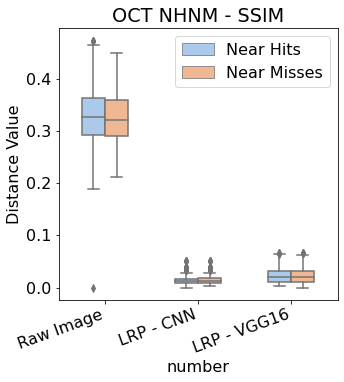

In [33]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5,5))
sns.boxplot(x=oct_scores_long["number"][(oct_scores_long["distance"] == "ssim")&
                                         (oct_scores_long["number"] != "1001")],
            y=oct_scores_long["value"][(oct_scores_long["distance"] == "ssim")&
                                         (oct_scores_long["number"] != "1001")],
            palette="pastel", width=0.5,
            hue=oct_scores_long["nhnm"])
plt.xticks(ticks=range(0, 3),
           labels=["Raw Image", "LRP - CNN", "LRP - VGG16"],
           rotation=20, ha="right")
plt.ylabel("Distance Value")
L=plt.legend()
L.get_texts()[0].set_text('Near Hits')
L.get_texts()[1].set_text('Near Misses')
plt.title("OCT NHNM - SSIM")
plt.show

#### Results:

all distance measures:
* distances for the VGG16-based NHNM are higher than for the corresponding CNN-based NHNM -> as expected; difference not as prominent as in MNIST
* distances of near hits behave about the same as distances of near misses.
* distances for misses are higher than for hits as expected; exception: 1000_ssim , 1010_euclidean and 1011_ssim, here distances for misses are lower; however difference it not as prominent as in MNIST -> might need more data
* weird: 1000 != 1001 (unlike for MNIST)

euclidean distances:
* euclidean distances for raw images are the highest -> to be expected since euclidean distance might not be the optimal citerion here
* euclidean distances for FE are a lot smaller than those of LRP -> to be expected since euclidean distance might not be the optimal citerion here


SSIM:
* SSIM on the LRP heatmaps are a smaller than on the raw images; this could be due to the fact that a lot more of the LRP heatmaps share the same color (grey) than the original image (black); -> difference not as prominent as on MNIST data


## Calculate Jaccard indices

In [34]:
def jaccard_nhnmtm(df1, df2, group=None, df1_name=None, df2_name=None):
    res = pd.DataFrame()
    # hits
    res["jaccard_hits"] = jaccard_df(df1.near_hits, df2.near_hits)
    res["jaccard_hits_abs"] = jaccard_df(df1.near_hits, df2.near_hits, "absolute")
    # misses
    res["jaccard_misses"] = jaccard_df(df1.near_misses, df2.near_misses)
    res["jaccard_misses_abs"] = jaccard_df(df1.near_misses, df2.near_misses, "absolute")
    # top misses
    res["jaccard_top_misses"] = jaccard_df(df1.top_misses, df2.top_misses)
    res["jaccard_top_misses_abs"] = jaccard_df(df1.top_misses, df2.top_misses, "absolute")
    # set group
    if group is not None:
        res["group"] = group
        res["df1_name"] = df1_name
        res["df2_name"] = df2_name
    return res

In [35]:
def sort_triangular(matrix):
    """ Takes matrix/DataFrame as input and sorts columns and rows into an upper triangular matrix if rest is NAN

    :param matrix: pandas.DataFrame
    :return: pandas.DataFrame with sorted columns and rows
    """
    nan_count_c = matrix.apply(lambda x: x.isna().sum(), axis=0)
    nan_count_r = matrix.apply(lambda x: x.isna().sum(), axis=1)
    triangular = matrix.iloc[np.argsort(nan_count_r), np.argsort(-nan_count_c)]
    return triangular

In [36]:
# jaccards.groupby(["df1_name", "df2_name"]).describe()

def jaccards_heatmap(jaccards_df, column, title = None, vmin=None, vmax=None, metric="median", q=0.5):
    """
    :param column: str, one of "jaccard_misses", "jaccard_top_misses", "jaccard_hits", "jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"
    """
    # prepare data + sort into triangulart matrix
    if metric == "mean":
        mean_topmisses = jaccards_df[[column,
                                      "df1_name", "df2_name"]].groupby(["df1_name", "df2_name"]).mean().unstack()
    elif metric == "quantile":
        metric = str(q*100) + "%-quantile"
        mean_topmisses = jaccards_df[[column,
                                      "df1_name", "df2_name"]].groupby(["df1_name", "df2_name"]).quantile(q).unstack()
    else:
        metric = "median"
        mean_topmisses = jaccards_df[[column,
                                      "df1_name", "df2_name"]].groupby(["df1_name", "df2_name"]).quantile(0.5).unstack()
    mean_topmisses.columns = mean_topmisses.columns.get_level_values(1)
    mean_topmisses = sort_triangular(mean_topmisses)
    
    # set figure size + font size
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.6)
    # set boundary values for legend
    if (vmin is None) and (vmax is None):
        ax = sns.heatmap(mean_topmisses, annot=True, fmt=".3f", cmap='viridis', square = True)
    else:
        ax = sns.heatmap(mean_topmisses, annot=True, fmt=".3f", cmap='viridis', square = True,
                        vmin=vmin, vmax=vmax)
    # set axes label, put them on top of the figure and rotate them
    ax.set(xlabel="df2", ylabel="df1")
    ax.xaxis.tick_top()
    texts = [t for t in ax.get_xticklabels()]
    plt.xticks(ticks=np.arange(0, len(texts))+0.5,
           labels=texts,
           rotation=90, ha="center")
    # set title
    if title is None:
        title = column + " - " + metric
    plt.title(title)
    plt.show()

In [37]:
def rename_numbers(df, column):
    newcol = pd.DataFrame([0]* len(df[column]))
    
    newcol[df[column] == "0000_cw"] = "Raw Image-CWSSIM"
    newcol[df[column] == "0000_eucl"] = "Raw Image-Eucl"
    newcol[df[column] == "0000_ssim"] = "Raw Image-SSIM"
    newcol[df[column] == "0010_cw"] = "CNN-LRP-CWSSIM"
    newcol[df[column] == "0010_eucl"] = "CNN-LRP-Eucl"
    newcol[df[column] == "0010_ssim"] = "CNN-LRP-SSIM"
    newcol[df[column] == "0011_cw"] = "VGG-LRP-CWSSIM"
    newcol[df[column] == "0011_eucl"] = "VGG-LRP-Eucl"
    newcol[df[column] == "0011_ssim"] = "VGG-LRP-SSIM"
    newcol[df[column] == "0100_eucl"] = "CNN-FE-Eucl"
    newcol[df[column] == "0101_eucl"] = "VGG-FE-Eucl"
    
    newcol[df[column] == "1000_eucl"] = "Raw Image-Eucl"
    newcol[df[column] == "1000_ssim"] = "Raw Image-SSIM"
    newcol[df[column] == "1010_eucl"] = "CNN-LRP-Eucl"
    newcol[df[column] == "1010_ssim"] = "CNN-LRP-SSIM"
    newcol[df[column] == "1011_eucl"] = "VGG-LRP-Eucl"
    newcol[df[column] == "1011_ssim"] = "VGG-LRP-SSIM"
    newcol[df[column] == "1100_eucl"] = "CNN-FE-Eucl"
    newcol[df[column] == "1101_eucl"] = "VGG-FE-Eucl"

    return newcol

#rename_numbers(jaccards, "df1_name")
#jaccards["df1_name"]

In [38]:
# get rid of double raw images
mnist_df_names = ["0000_eucl", "0000_ssim", "0000_cw",
          "0010_eucl", "0010_ssim", "0010_cw",
          "0011_eucl", "0011_ssim", "0011_cw",
          "0100_eucl", "0101_eucl"]

oct_df_names = ["1000_eucl", "1000_ssim",
          "1010_eucl", "1010_ssim",
          "1011_eucl", "1011_ssim",
          "1100_eucl", "1101_eucl"]

mnist_df = {df_name: all_df[df_name] for df_name in all_df if df_name in mnist_df_names}
oct_df = {df_name: all_df[df_name] for df_name in all_df if df_name in oct_df_names}

### MNIST

In [39]:
# calculate Jaccard Indeces for every combination of DataFrames
jaccards = pd.DataFrame()
for m1, df1 in mnist_df.items():
    for m2, df2 in mnist_df.items():
        # print(m1+"_"+m2)
        if m1 == m2:  # if compare DataFrame to itself -> continue
            continue
        try:
            if m2+"_"+m1 in np.array(jaccards.group):  # since jaccard(A,B) == jaccard(B,A) we can speed up by skipping
                continue
        except AttributeError:  # if it's the first time we compare these DataFrames it's okay to have an error
            pass
        new = jaccard_nhnmtm(df1, df2, group = m1+"_"+m2, df1_name=m1, df2_name=m2)
        jaccards = pd.concat([jaccards, new], ignore_index = True)
        
jaccards

jaccard_hits  jaccard_hits_abs  jaccard_misses  jaccard_misses_abs  \
0         0.000000                 0        0.034483                   1   
1         0.000000                 0        0.000000                   0   
2         0.000000                 0        0.000000                   0   
3         0.111111                 1        0.000000                   0   
4         0.000000                 0        0.000000                   0   
...            ...               ...             ...                 ...   
5495      0.000000                 0        0.000000                   0   
5496      0.000000                 0        0.000000                   0   
5497      0.111111                 1        0.000000                   0   
5498      0.000000                 0        0.000000                   0   
5499      0.000000                 0        0.000000                   0   

      jaccard_top_misses  jaccard_top_misses_abs                group  \
0                    0.0                       0  0000_eucl_0000_ssim   
1                    0.0                       0  0000_eucl_0000_ssim   
2                    0.0                       0  0000_eucl_0000_ssim   
3                    0.0                       0  0000_eucl_0000_ssim   
4                    0.0                       0  0000_eucl_0000_ssim   
...                  ...                     ...                  ...   
5495                 0.0                       0  0100_eucl_0101_eucl   
5496                 0.0                       0  0100_eucl_0101_eucl   
5497                 0.0                       0  0100_eucl_0101_eucl   
5498                 0.0                       0  0100_eucl_0101_eucl   
5499                 0.0                       0  0100_eucl_0101_eucl   

       df1_name   df2_name  
0     0000_eucl  0000_ssim  
1     0000_eucl  0000_ssim  
2     0000_eucl  0000_ssim  
3     0000_eucl  0000_ssim  
4     0000_eucl  0000_ssim  
...         ...        ...  
5495  0100_eucl  0101_eucl  
5496  0100_eucl  0101_eucl  
5497  0100_eucl  0101_eucl  
5498  0100_eucl  0101_eucl  
5499  0100_eucl  0101_eucl  

[5500 rows x 9 columns]

In [40]:
jaccards.groupby(["df1_name", "df2_name"]).describe() #.transpose()

jaccard_hits                                               \
                           count      mean       std  min       25%       50%   
df1_name  df2_name                                                              
0000_cw   0010_cw          100.0  0.146071  0.129151  0.0  0.000000  0.111111   
          0010_eucl        100.0  0.005833  0.031162  0.0  0.000000  0.000000   
          0010_ssim        100.0  0.096468  0.107294  0.0  0.000000  0.111111   
          0011_cw          100.0  0.091429  0.113569  0.0  0.000000  0.111111   
          0011_eucl        100.0  0.014444  0.037555  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.073849  0.096882  0.0  0.000000  0.000000   
          0100_eucl        100.0  0.016944  0.044300  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.074524  0.101903  0.0  0.000000  0.000000   
0000_eucl 0000_cw          100.0  0.008056  0.034486  0.0  0.000000  0.000000   
          0000_ssim        100.0  0.008056  0.034486  0.0  0.000000  0.000000   
          0010_cw          100.0  0.010278  0.037384  0.0  0.000000  0.000000   
          0010_eucl        100.0  0.001111  0.011111  0.0  0.000000  0.000000   
          0010_ssim        100.0  0.005556  0.024338  0.0  0.000000  0.000000   
          0011_cw          100.0  0.008889  0.030296  0.0  0.000000  0.000000   
          0011_eucl        100.0  0.005556  0.024338  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.010278  0.037384  0.0  0.000000  0.000000   
          0100_eucl        100.0  0.002222  0.015634  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.004722  0.029295  0.0  0.000000  0.000000   
0000_ssim 0000_cw          100.0  0.162341  0.142292  0.0  0.111111  0.111111   
          0010_cw          100.0  0.104762  0.114695  0.0  0.000000  0.111111   
          0010_eucl        100.0  0.008333  0.039580  0.0  0.000000  0.000000   
          0010_ssim        100.0  0.146905  0.127186  0.0  0.000000  0.111111   
          0011_cw          100.0  0.116111  0.123882  0.0  0.000000  0.111111   
          0011_eucl        100.0  0.025278  0.056954  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.143532  0.144297  0.0  0.000000  0.111111   
          0100_eucl        100.0  0.029722  0.059124  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.098532  0.128268  0.0  0.000000  0.111111   
0010_cw   0011_cw          100.0  0.061667  0.081161  0.0  0.000000  0.000000   
          0011_eucl        100.0  0.010278  0.037384  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.042619  0.080170  0.0  0.000000  0.000000   
          0100_eucl        100.0  0.011389  0.038703  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.058333  0.081346  0.0  0.000000  0.000000   
0010_eucl 0010_cw          100.0  0.001111  0.011111  0.0  0.000000  0.000000   
          0010_ssim        100.0  0.017778  0.040939  0.0  0.000000  0.000000   
          0011_cw          100.0  0.003611  0.027255  0.0  0.000000  0.000000   
          0011_eucl        100.0  0.002222  0.015634  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.008056  0.034486  0.0  0.000000  0.000000   
          0100_eucl        100.0  0.003333  0.019050  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.004444  0.021883  0.0  0.000000  0.000000   
0010_ssim 0010_cw          100.0  0.104524  0.105506  0.0  0.000000  0.111111   
          0011_cw          100.0  0.045556  0.066479  0.0  0.000000  0.000000   
          0011_eucl        100.0  0.011111  0.033501  0.0  0.000000  0.000000   
          0011_ssim        100.0  0.080079  0.107439  0.0  0.000000  0.000000   
          0100_eucl        100.0  0.014722  0.042239  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.037897  0.067288  0.0  0.000000  0.000000   
0011_cw   0100_eucl        100.0  0.012222  0.034941  0.0  0.000000  0.000000   
          0101_eucl        100.0  0.067460  0.09235

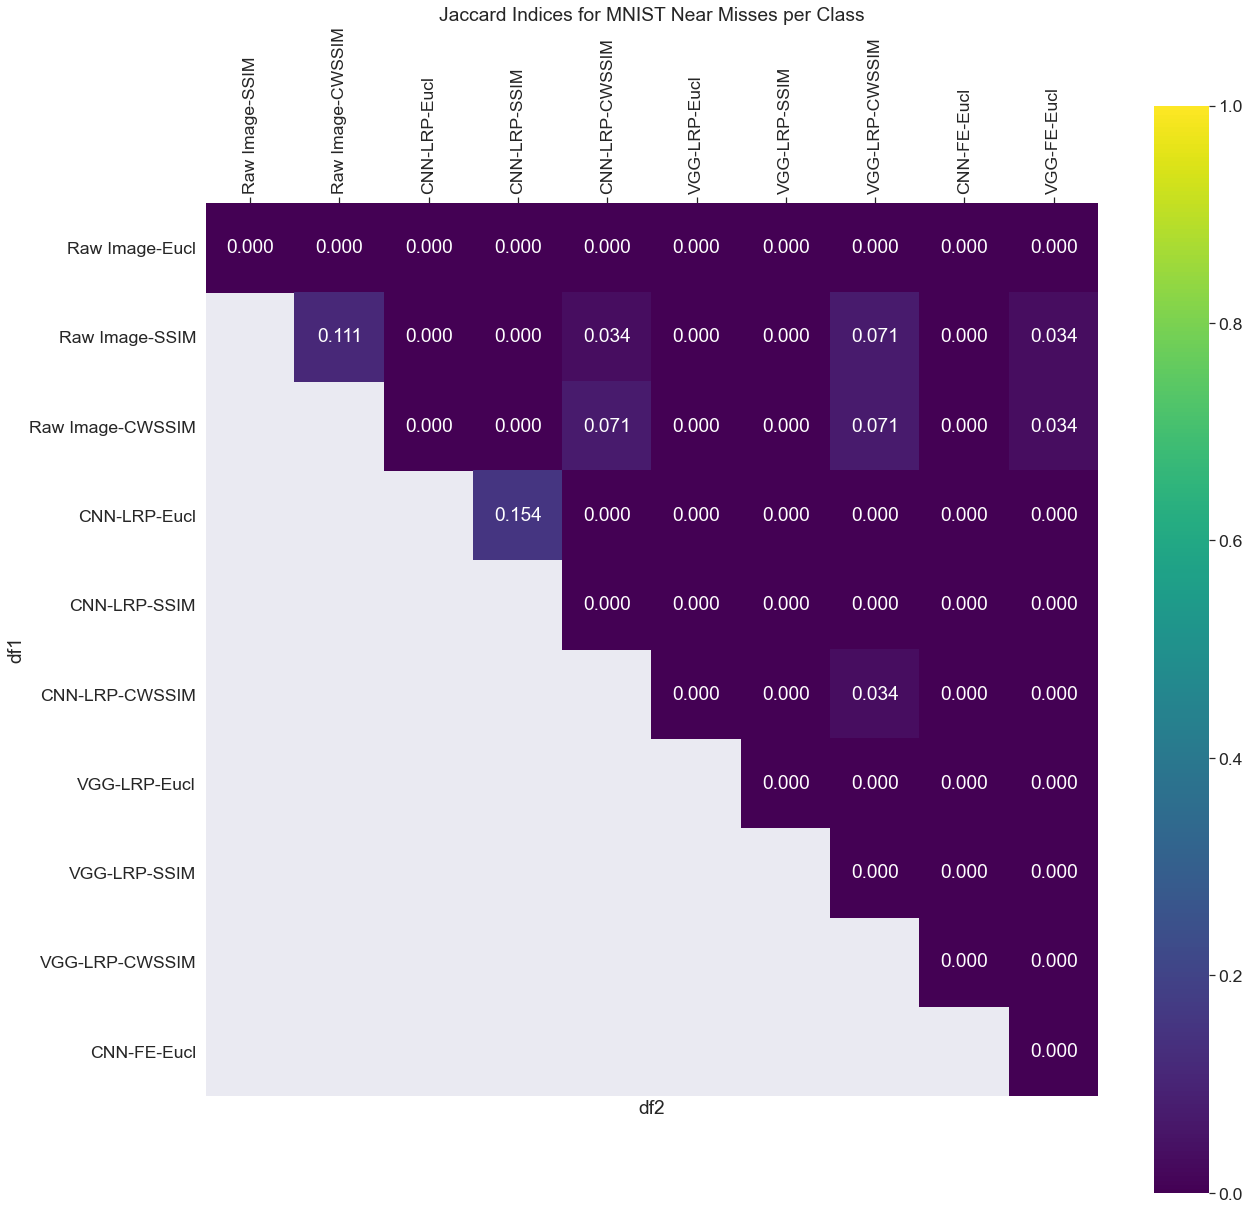

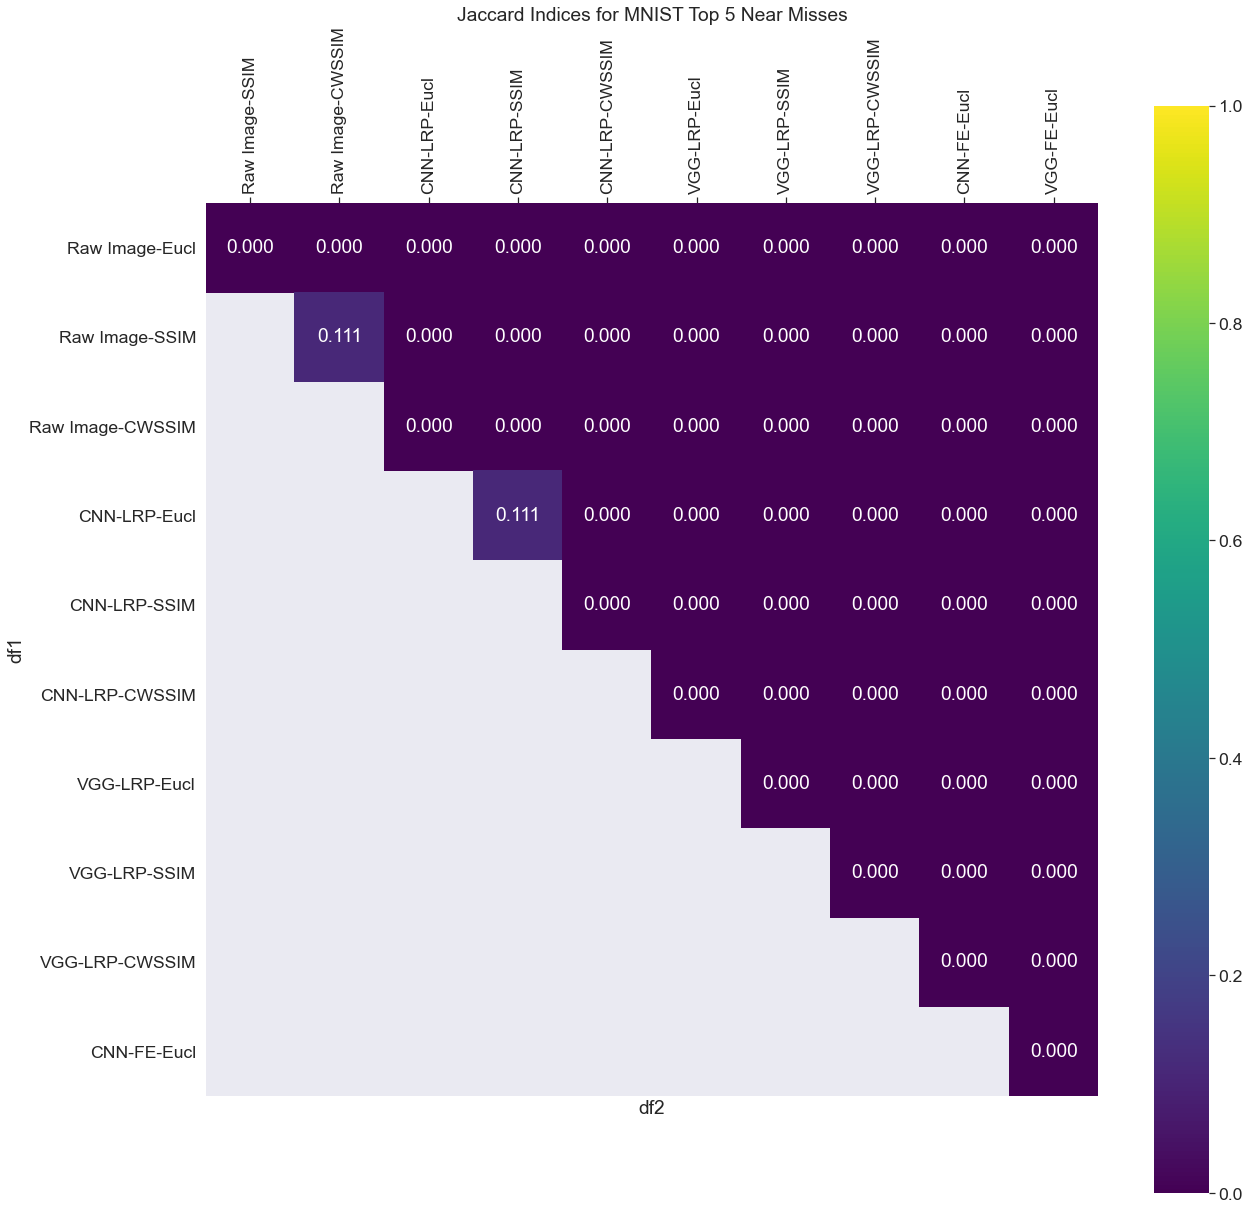

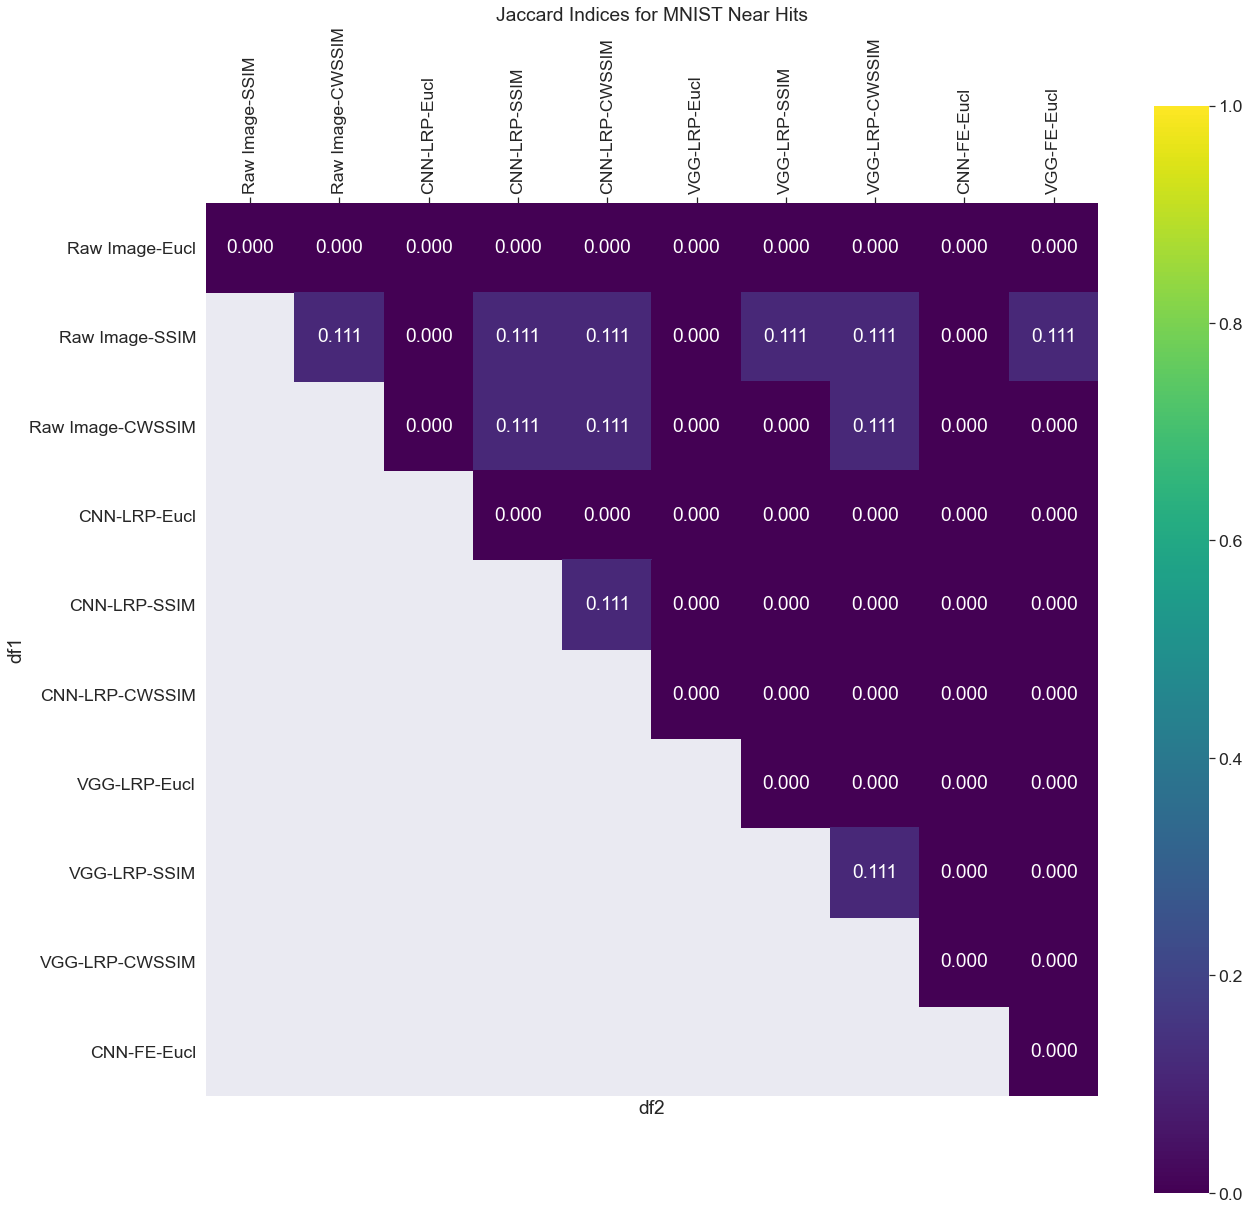

In [42]:
jaccards2 = jaccards.copy()
jaccards2["df1_name"] = rename_numbers(jaccards, "df1_name")
jaccards2["df2_name"] = rename_numbers(jaccards, "df2_name")

jaccards_heatmap(jaccards2, "jaccard_misses", vmax=1, title = "Jaccard Indices for MNIST Near Misses per Class")
jaccards_heatmap(jaccards2, "jaccard_top_misses", vmax=1, title = "Jaccard Indices for MNIST Top 5 Near Misses")
jaccards_heatmap(jaccards2, "jaccard_hits", vmax=1, title = "Jaccard Indices for MNIST Near Hits")

#### Jaccard Indices

In [43]:
sns.reset_defaults()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec82d85550>,
      dtype=object)

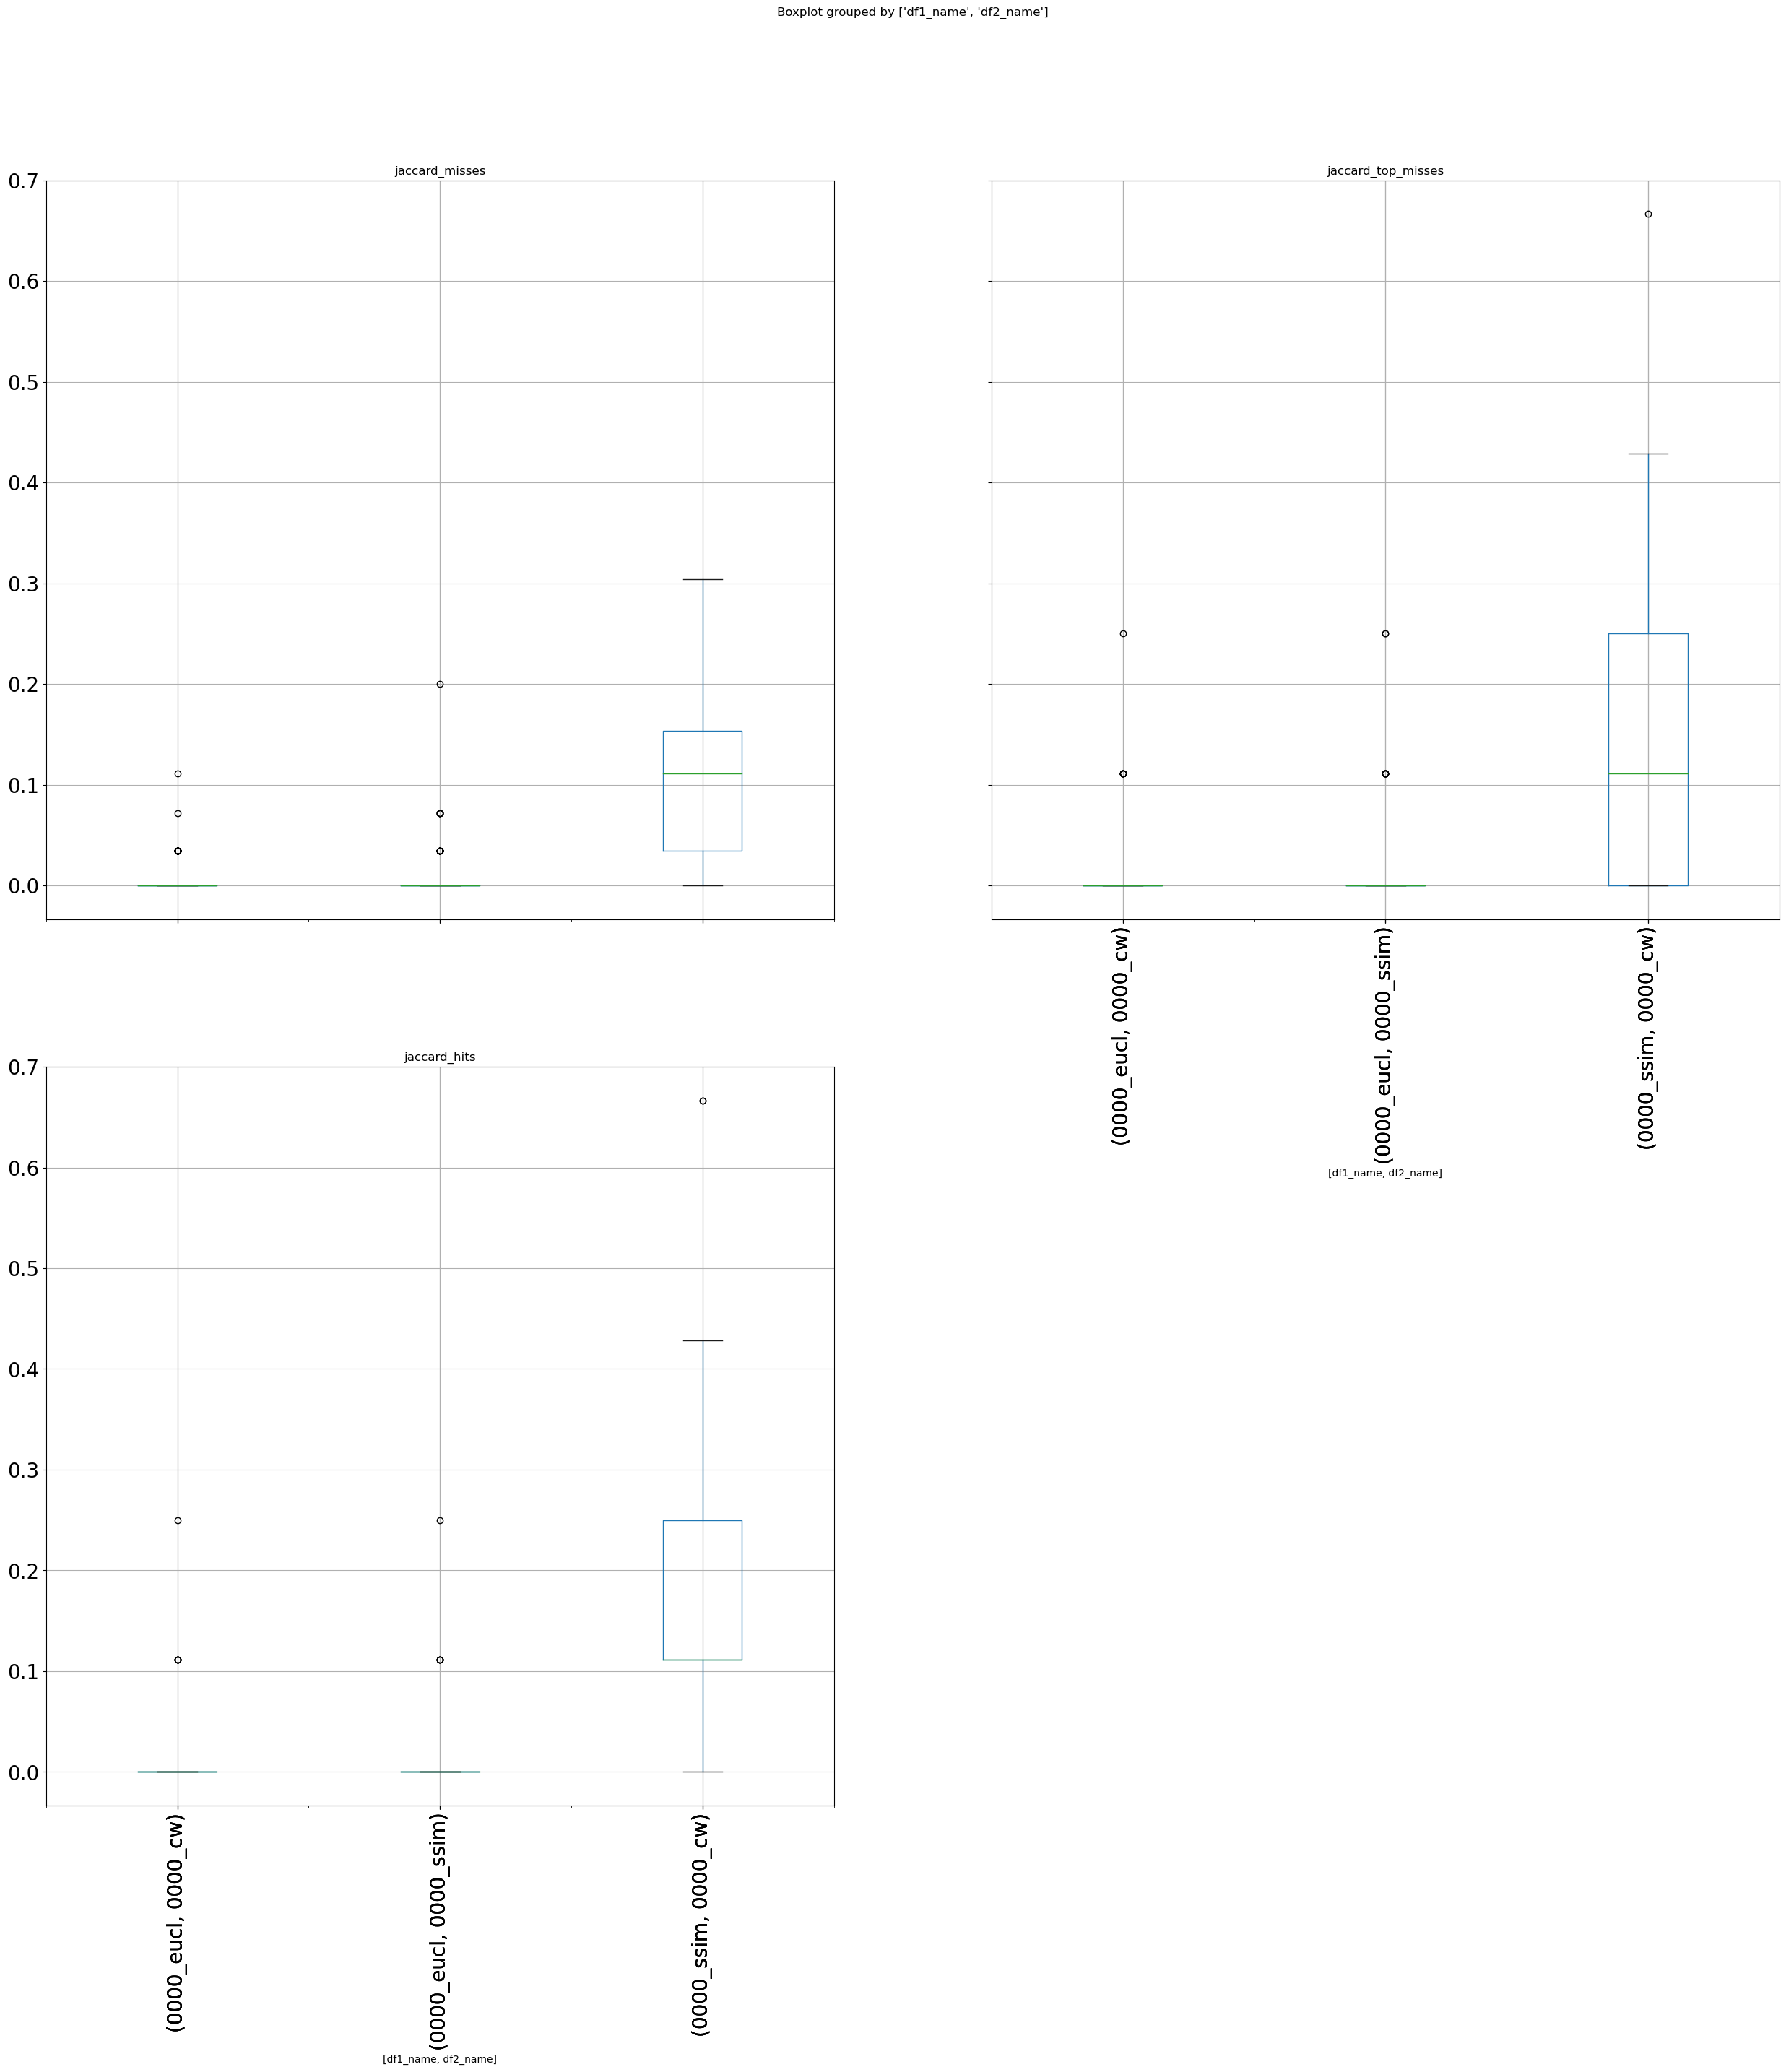

In [44]:
# raw
jaccards[((jaccards.df1_name.str[-9:-6]== "000") |
         (jaccards.df1_name.str[-7:-4] == "000")) &
        ((jaccards.df2_name.str[-9:-6]== "000") |
         (jaccards.df2_name.str[-7:-4] == "000"))].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec82fbdd00>,
      dtype=object)

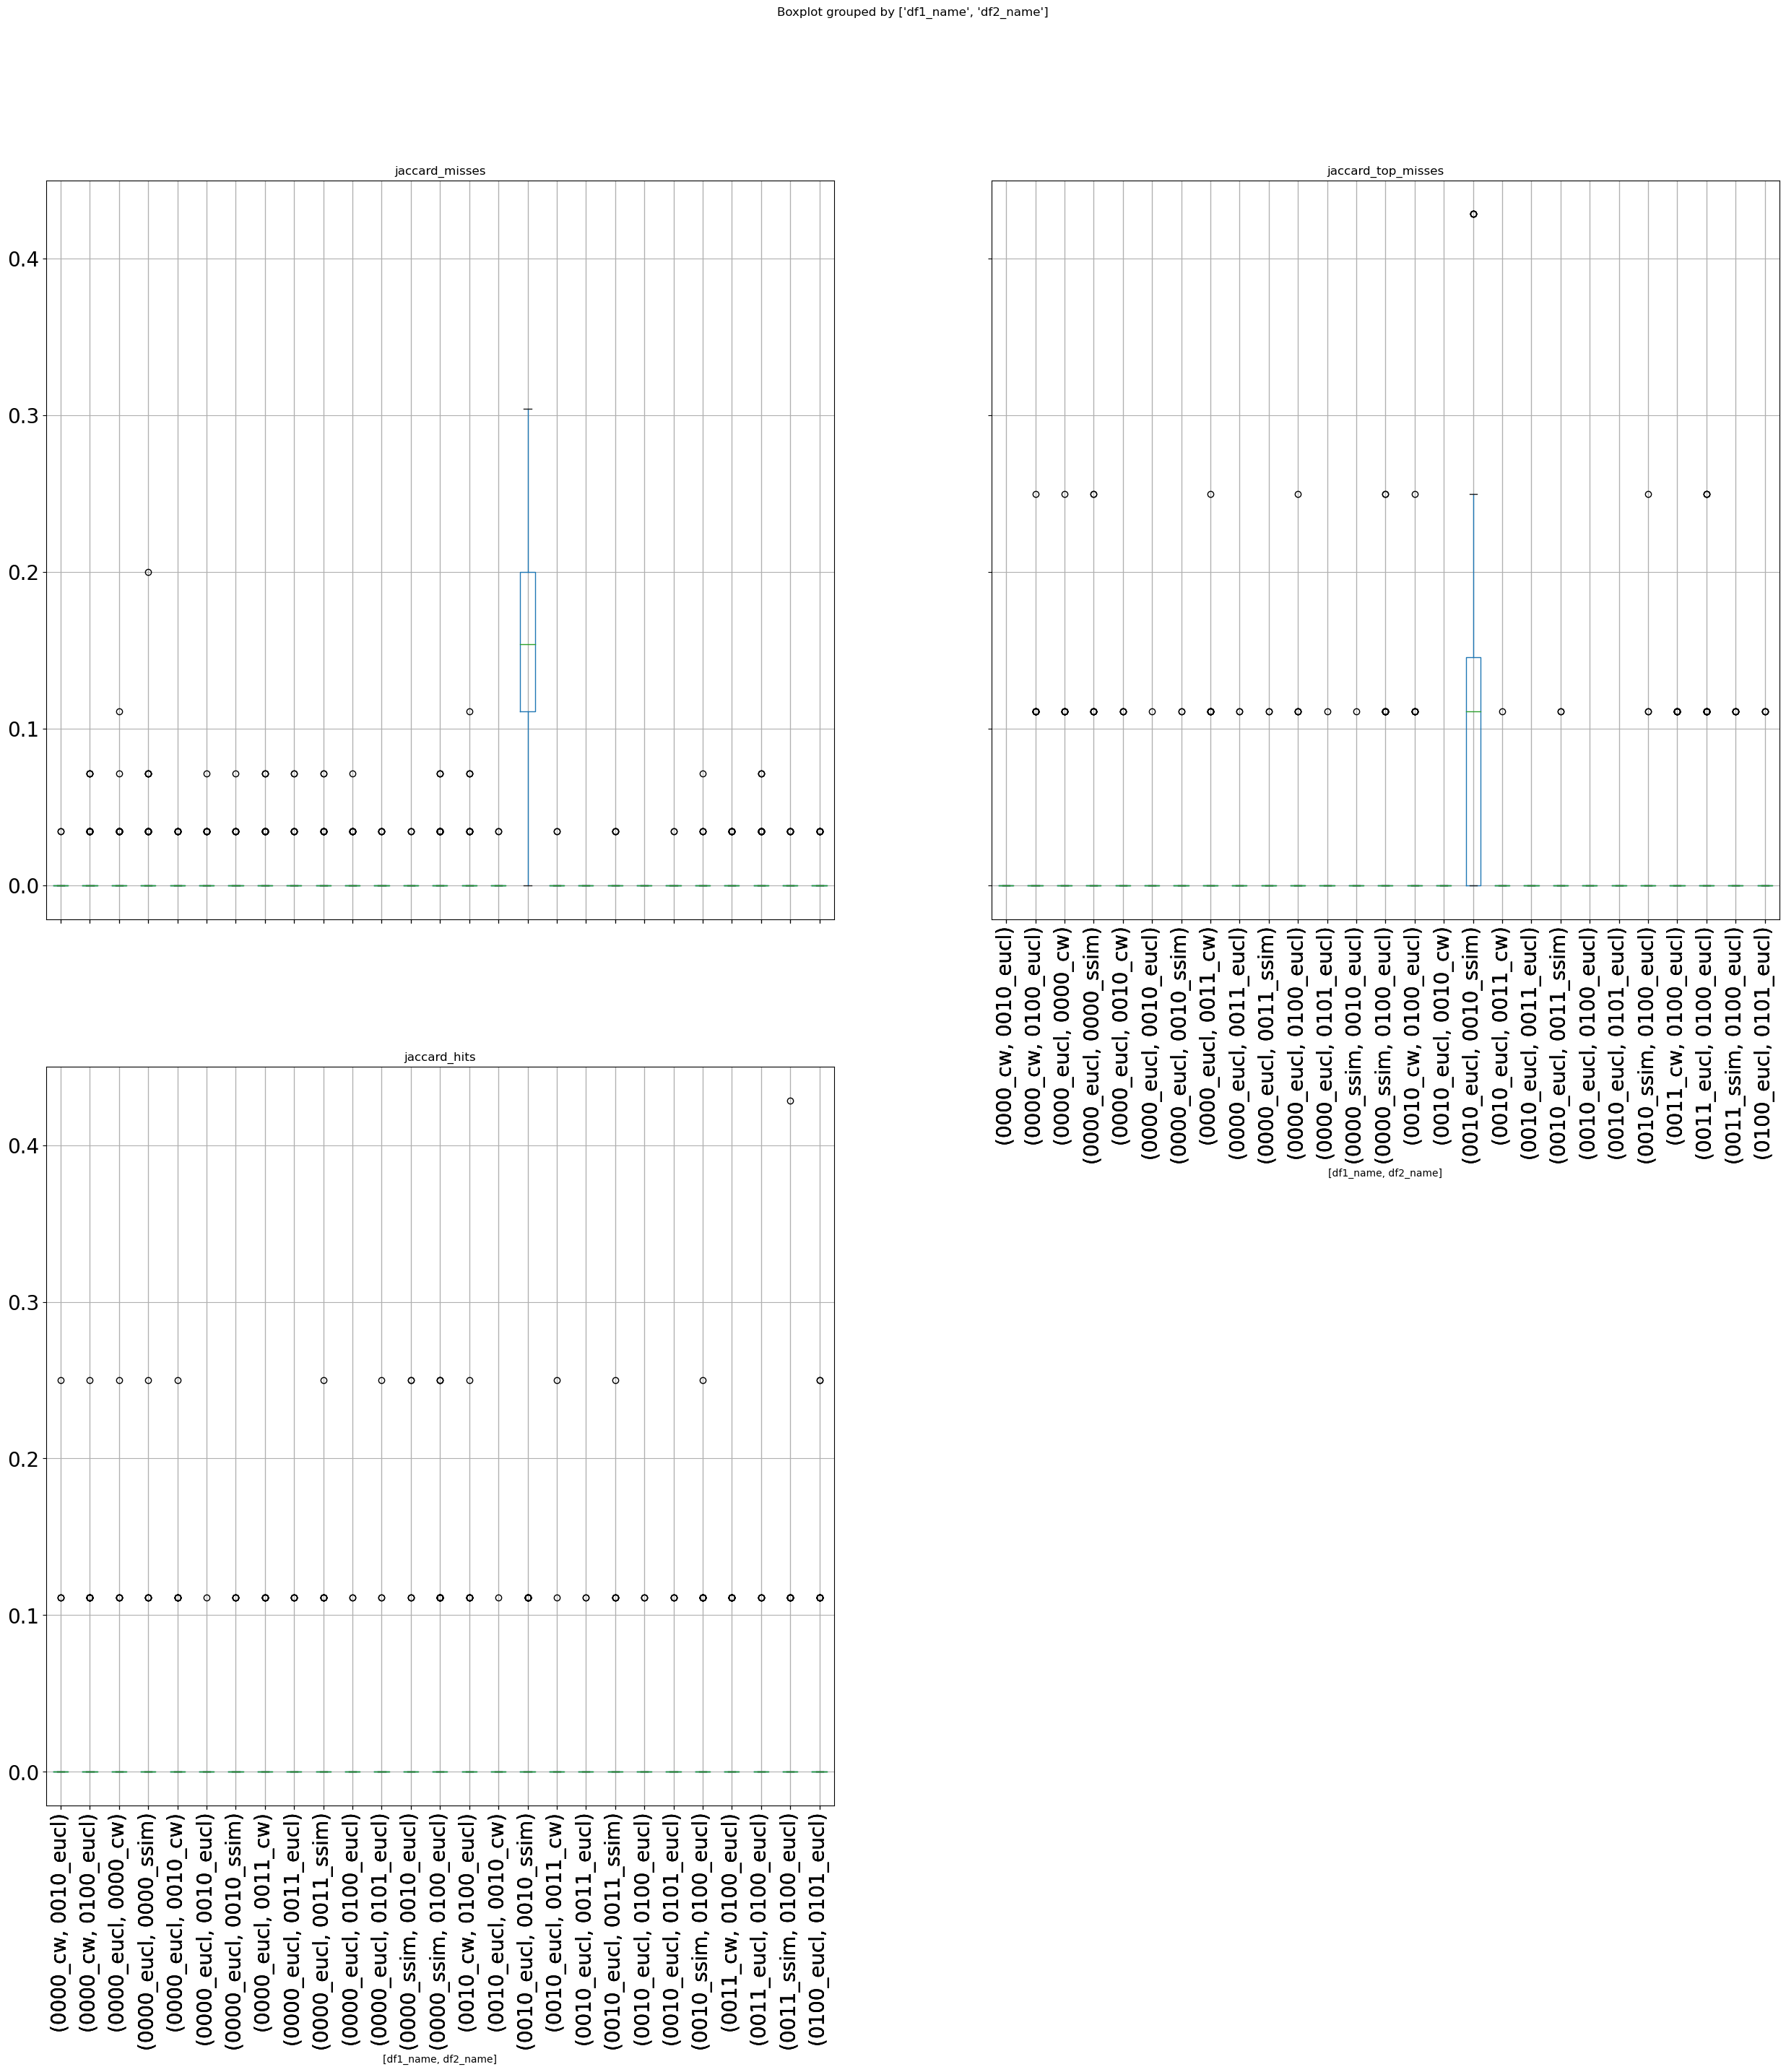

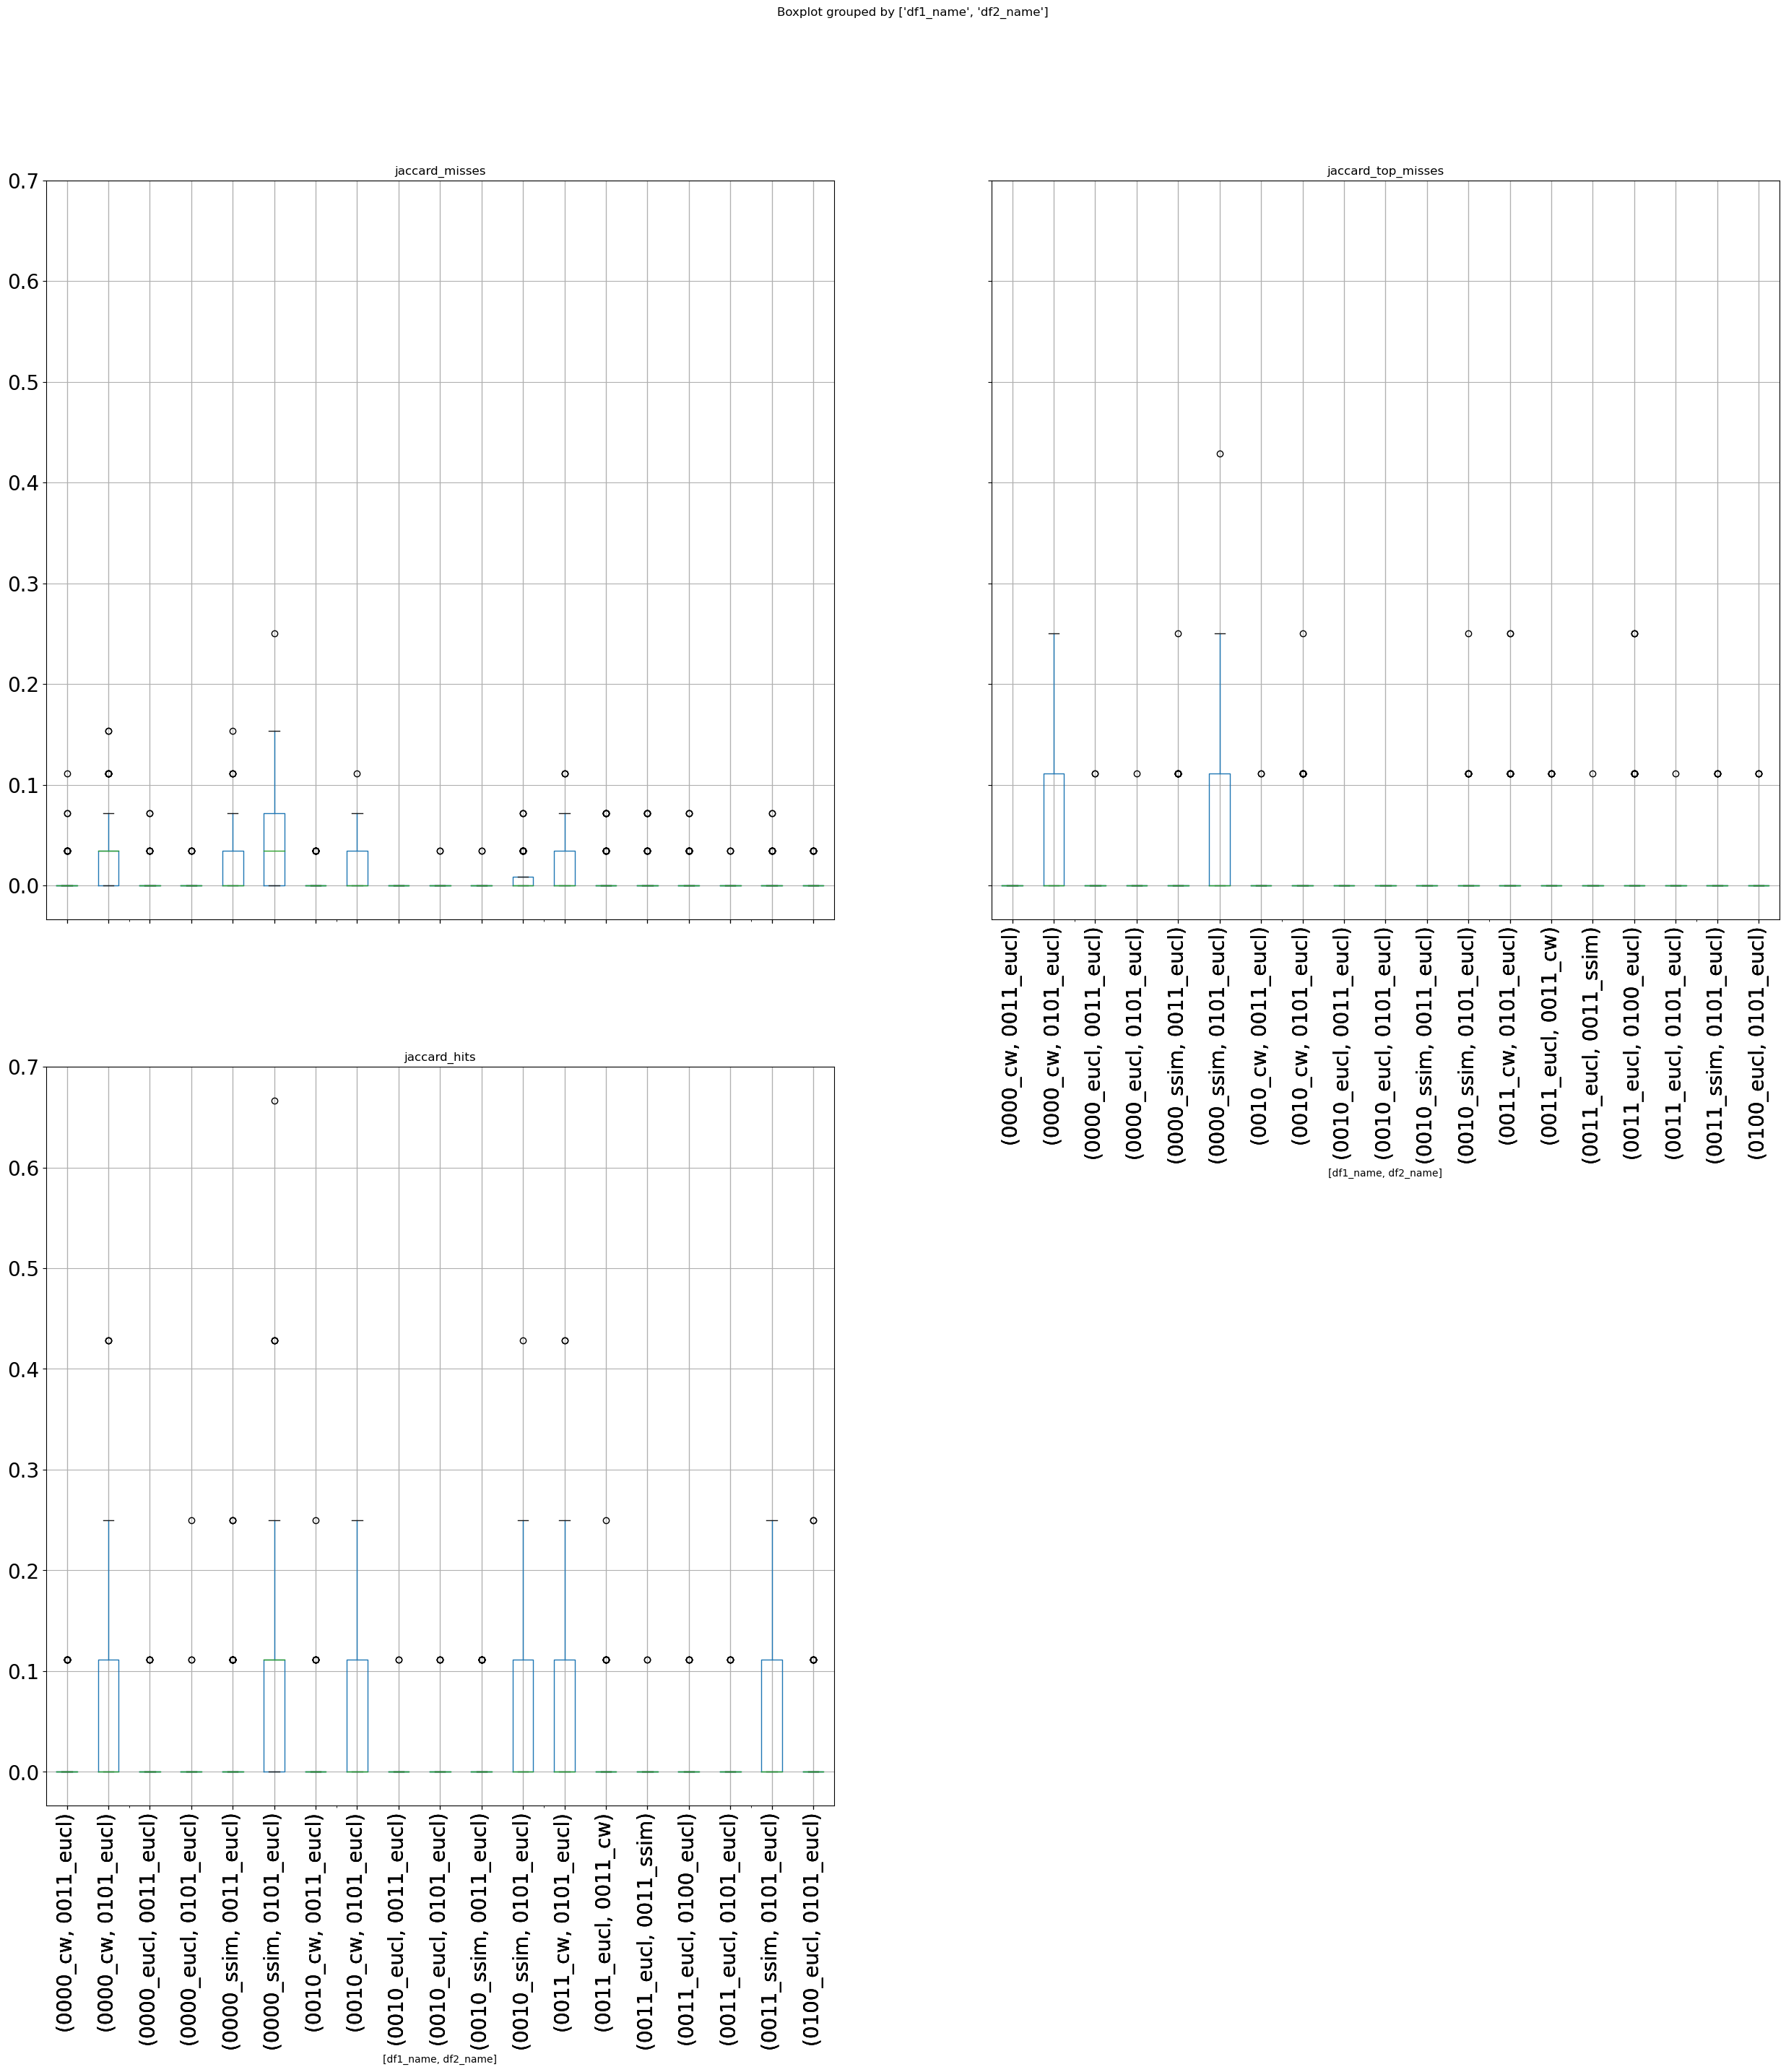

In [45]:
# euclidean
# CNN
jaccards[(jaccards.df1_name.str[-6:]== "0_eucl") |
         (jaccards.df2_name.str[-6:] == "0_eucl")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)
# VGG
jaccards[(jaccards.df1_name.str[-6:]== "1_eucl") |
         (jaccards.df2_name.str[-6:] == "1_eucl")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec83298130>,
      dtype=object)

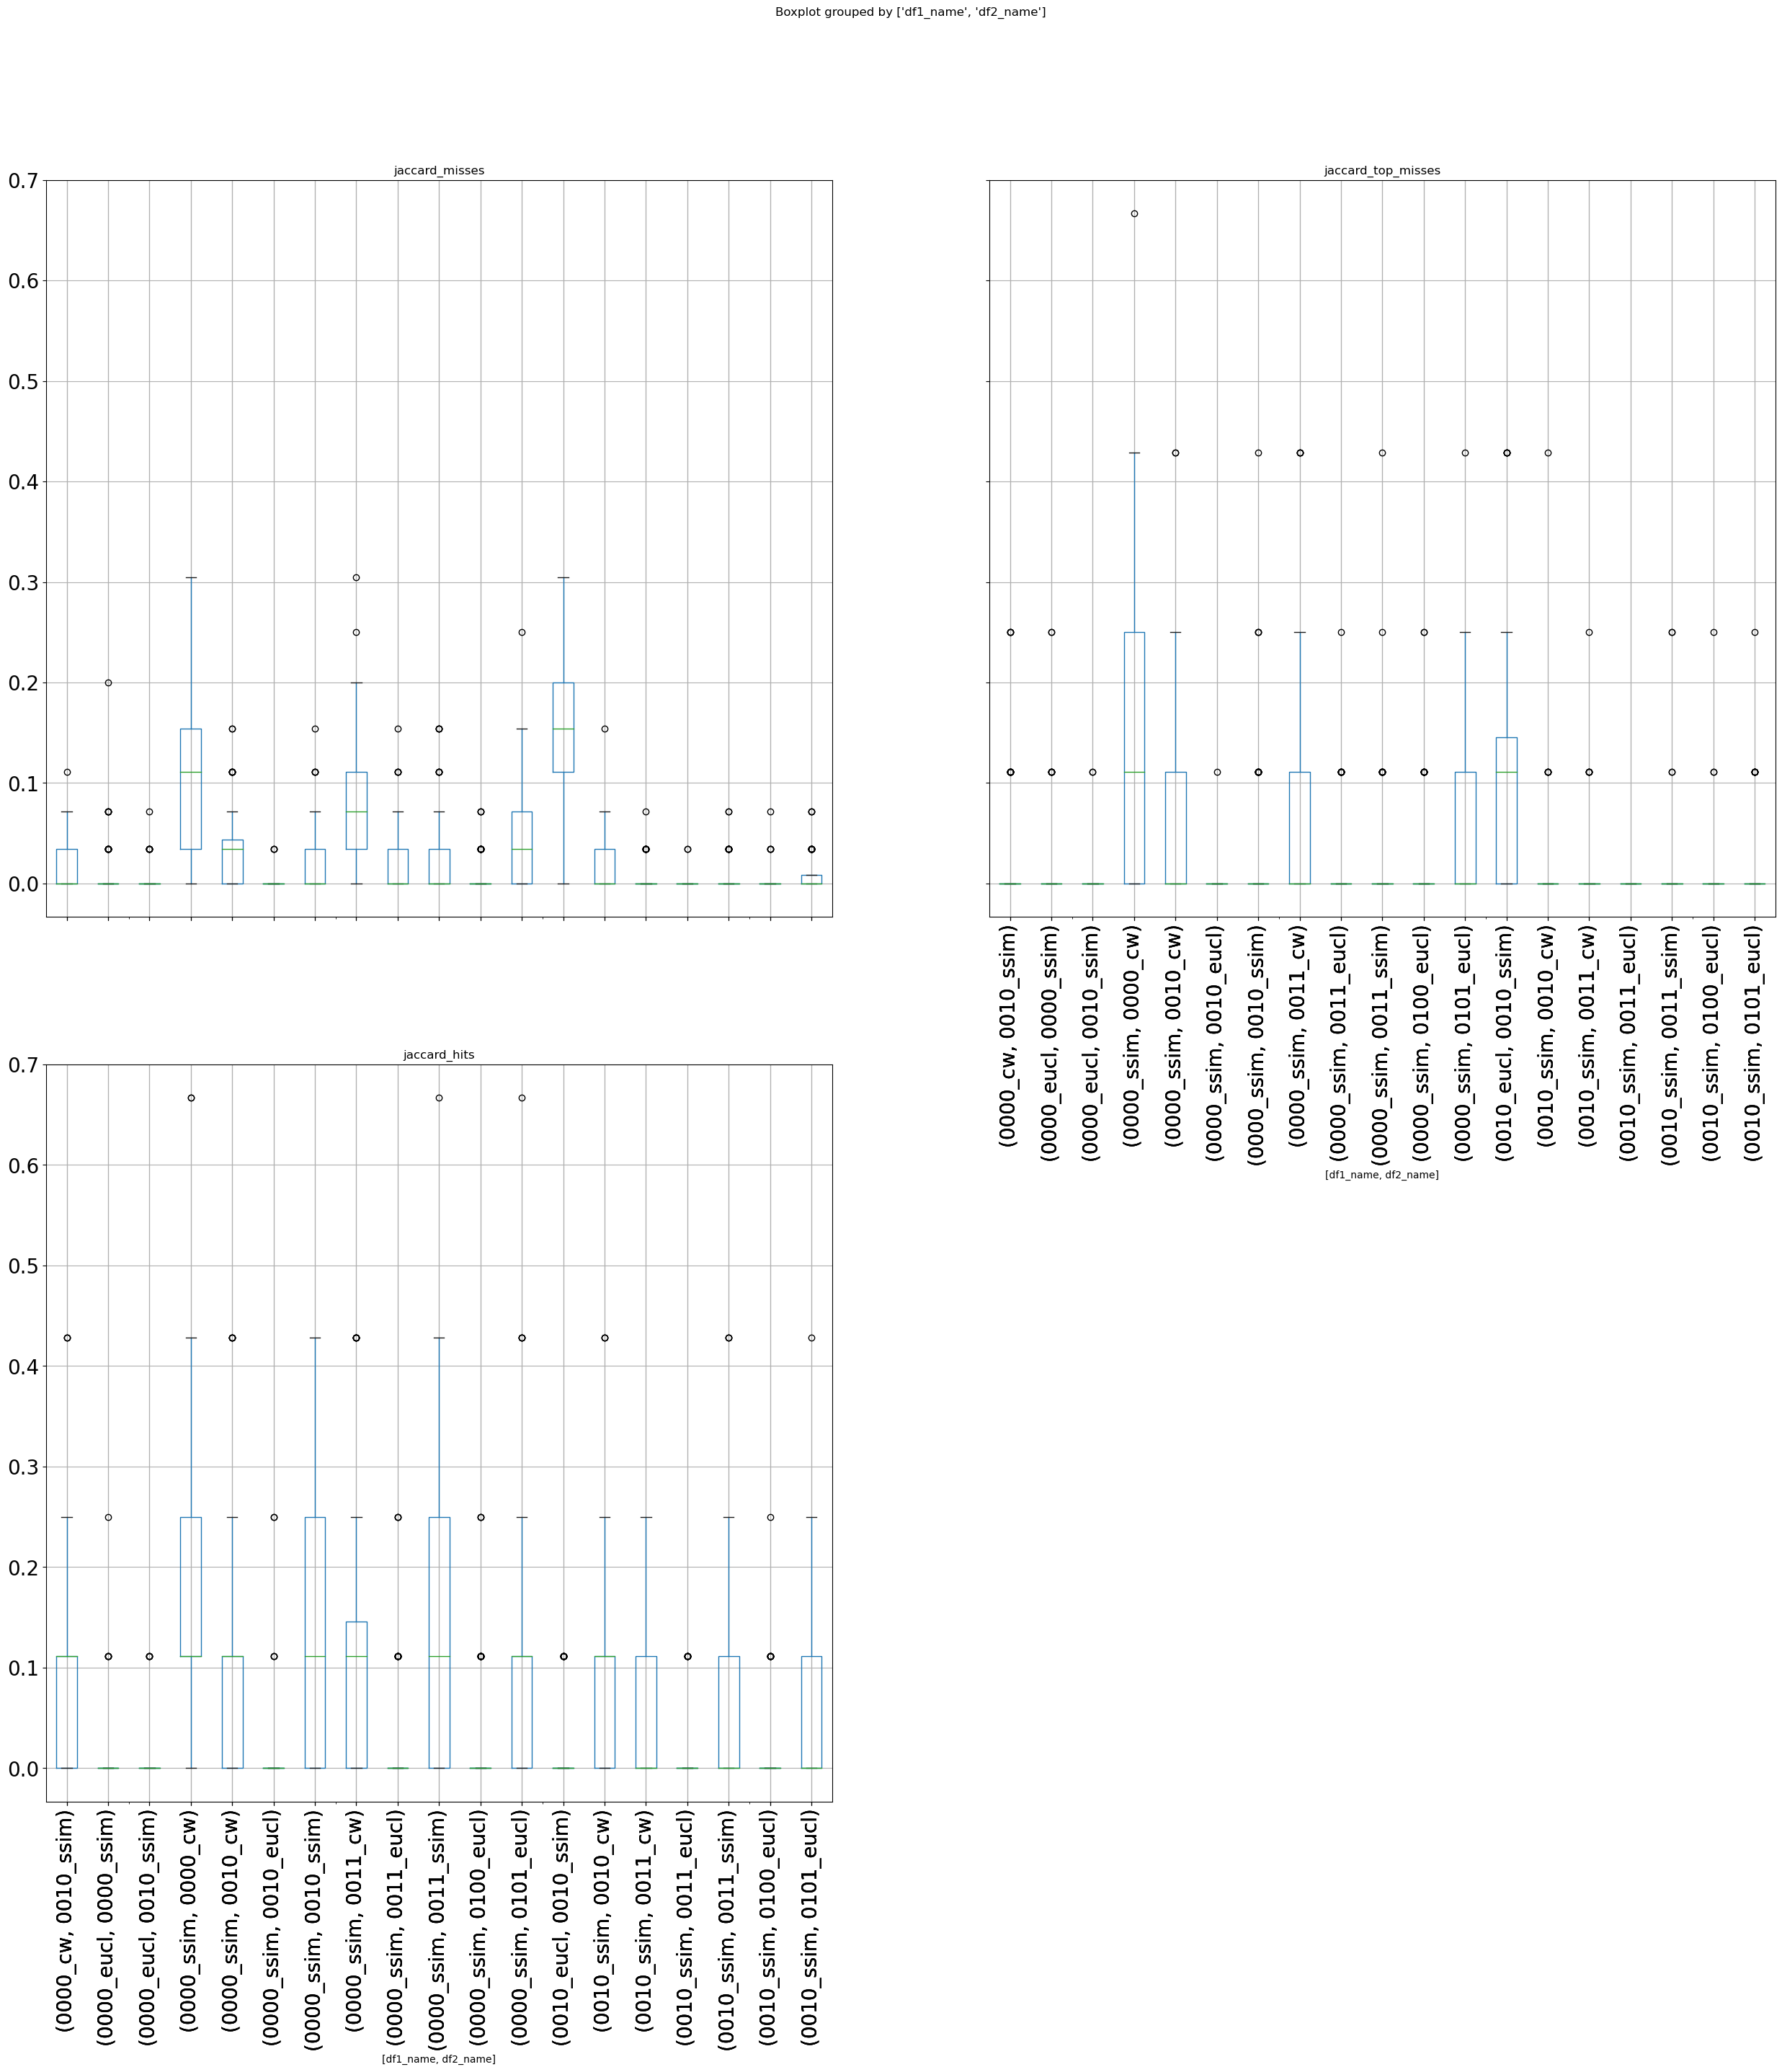

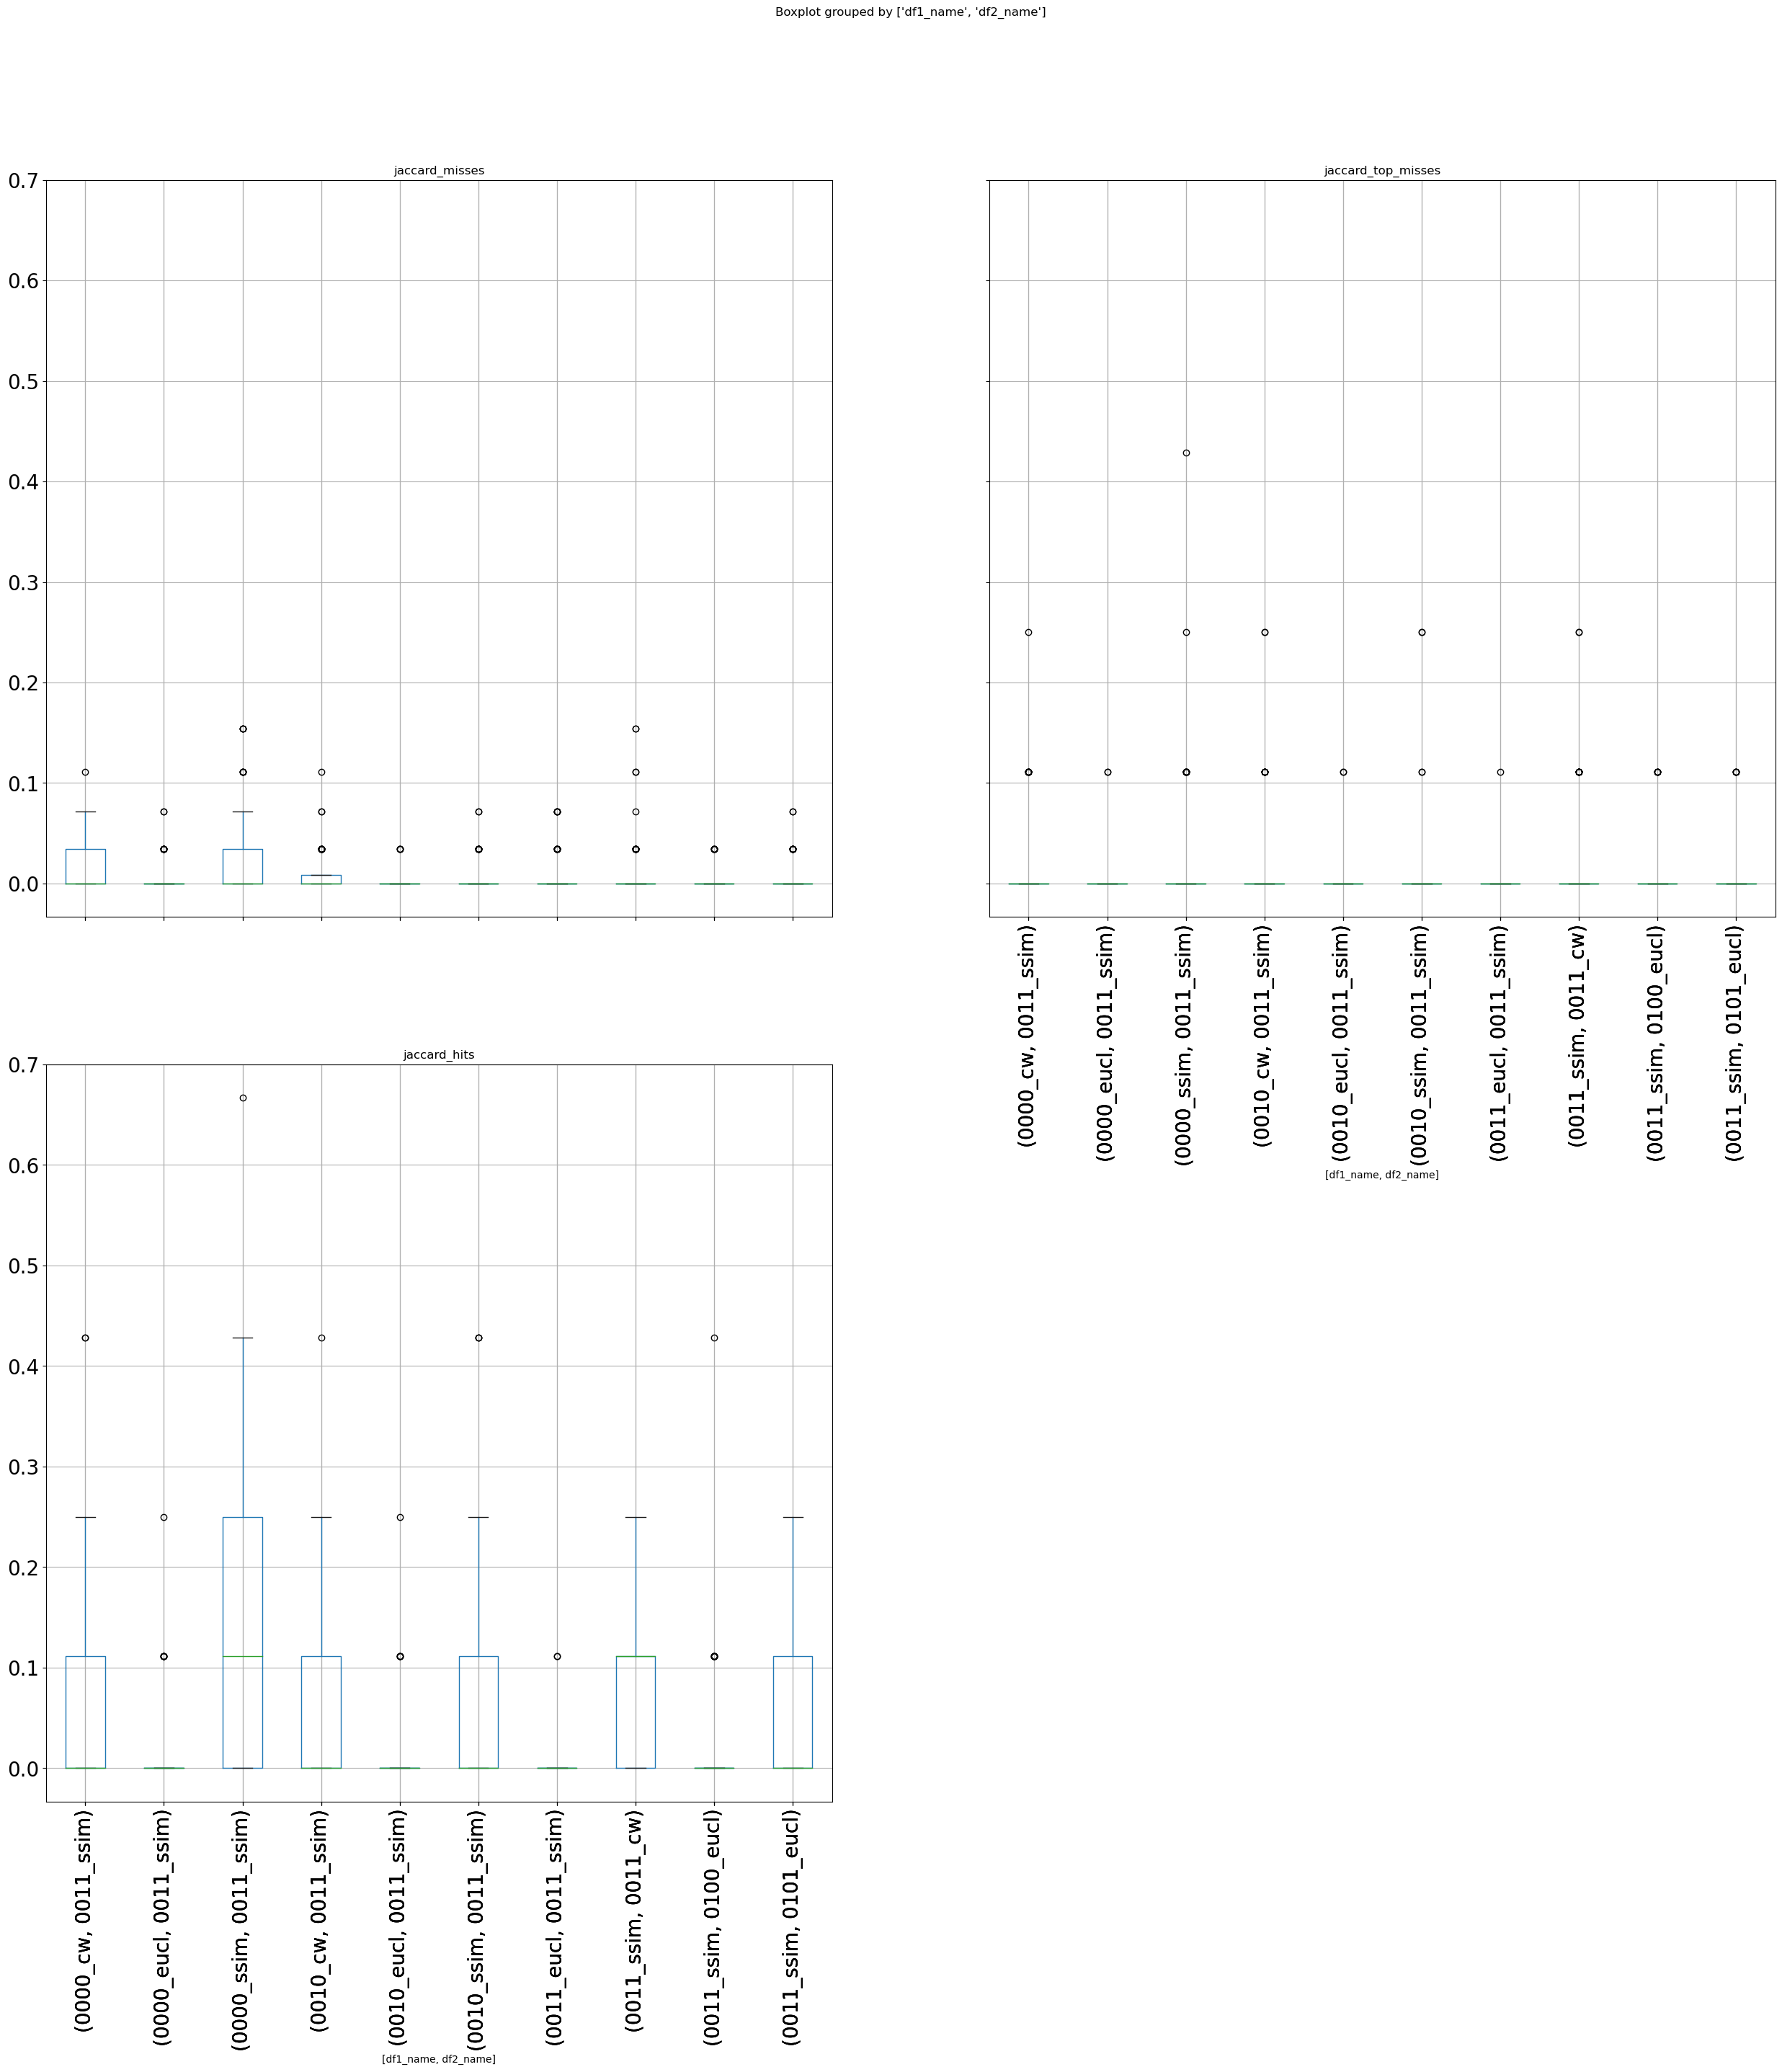

In [46]:
# ssim
# CNN
jaccards[(jaccards.df1_name.str[-6:]== "0_ssim") |
         (jaccards.df2_name.str[-6:] == "0_ssim")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)
# VGG
jaccards[(jaccards.df1_name.str[-6:]== "1_ssim") |
         (jaccards.df2_name.str[-6:] == "1_ssim")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec60442160>,
      dtype=object)

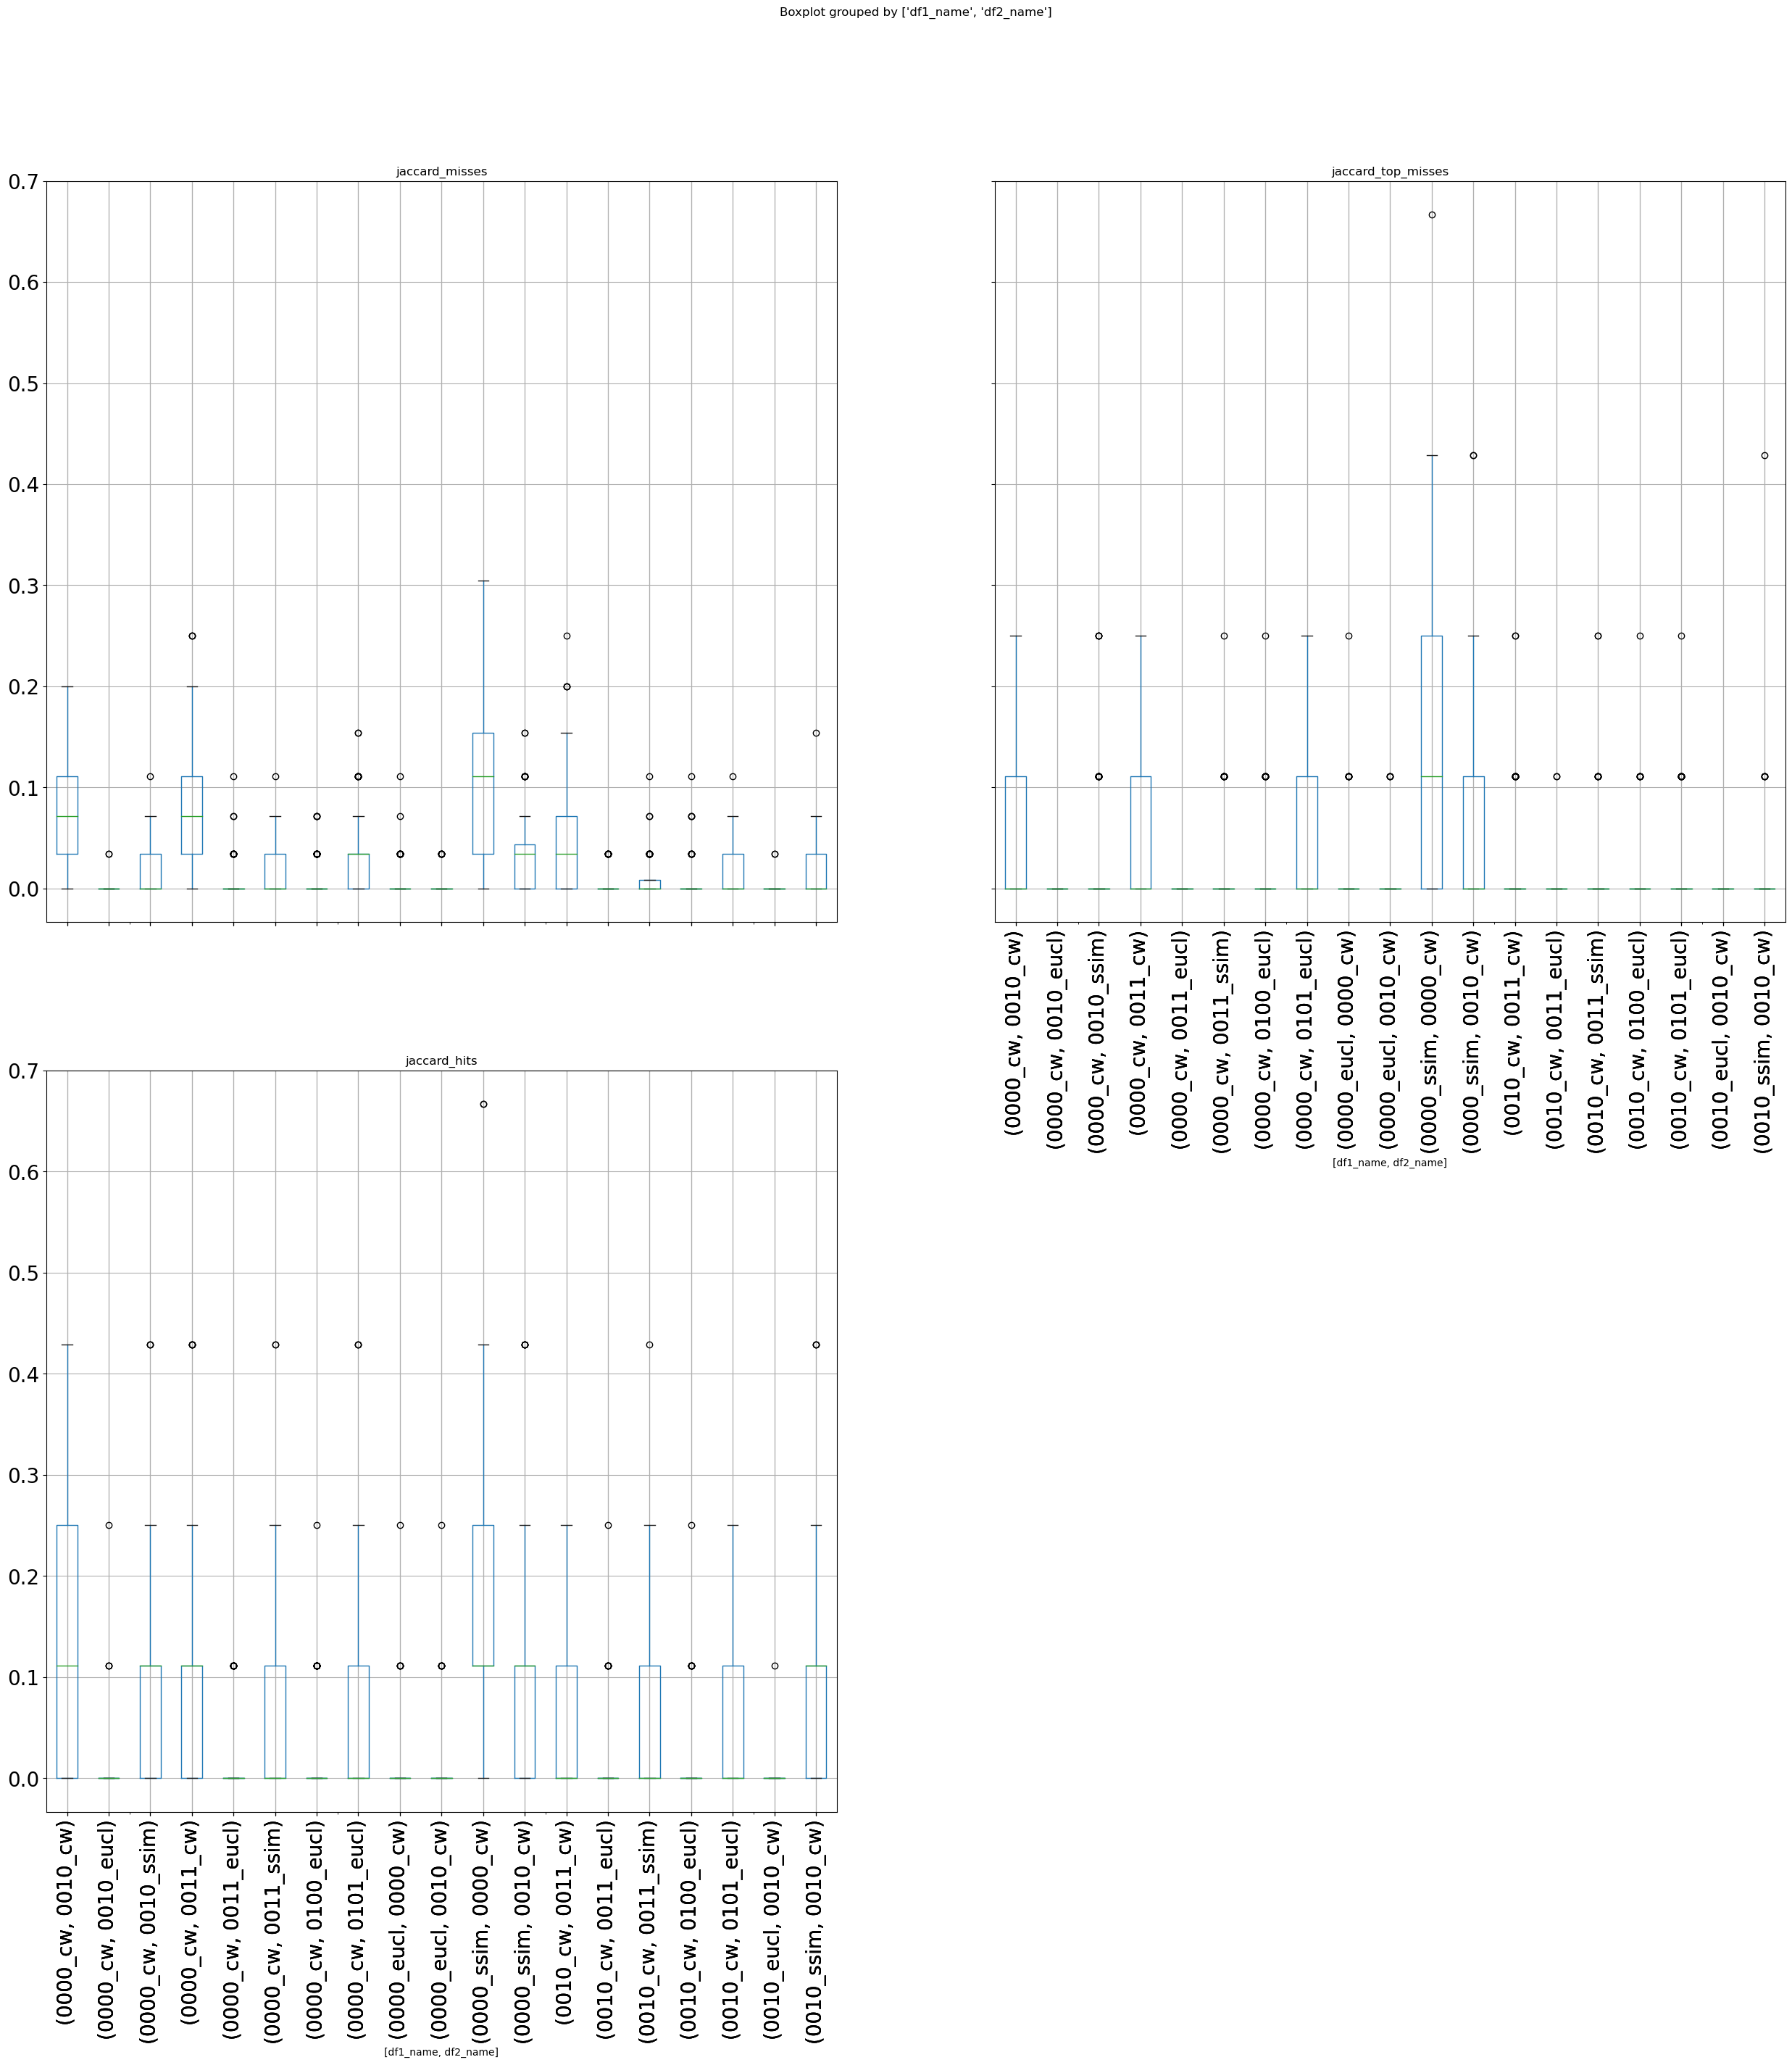

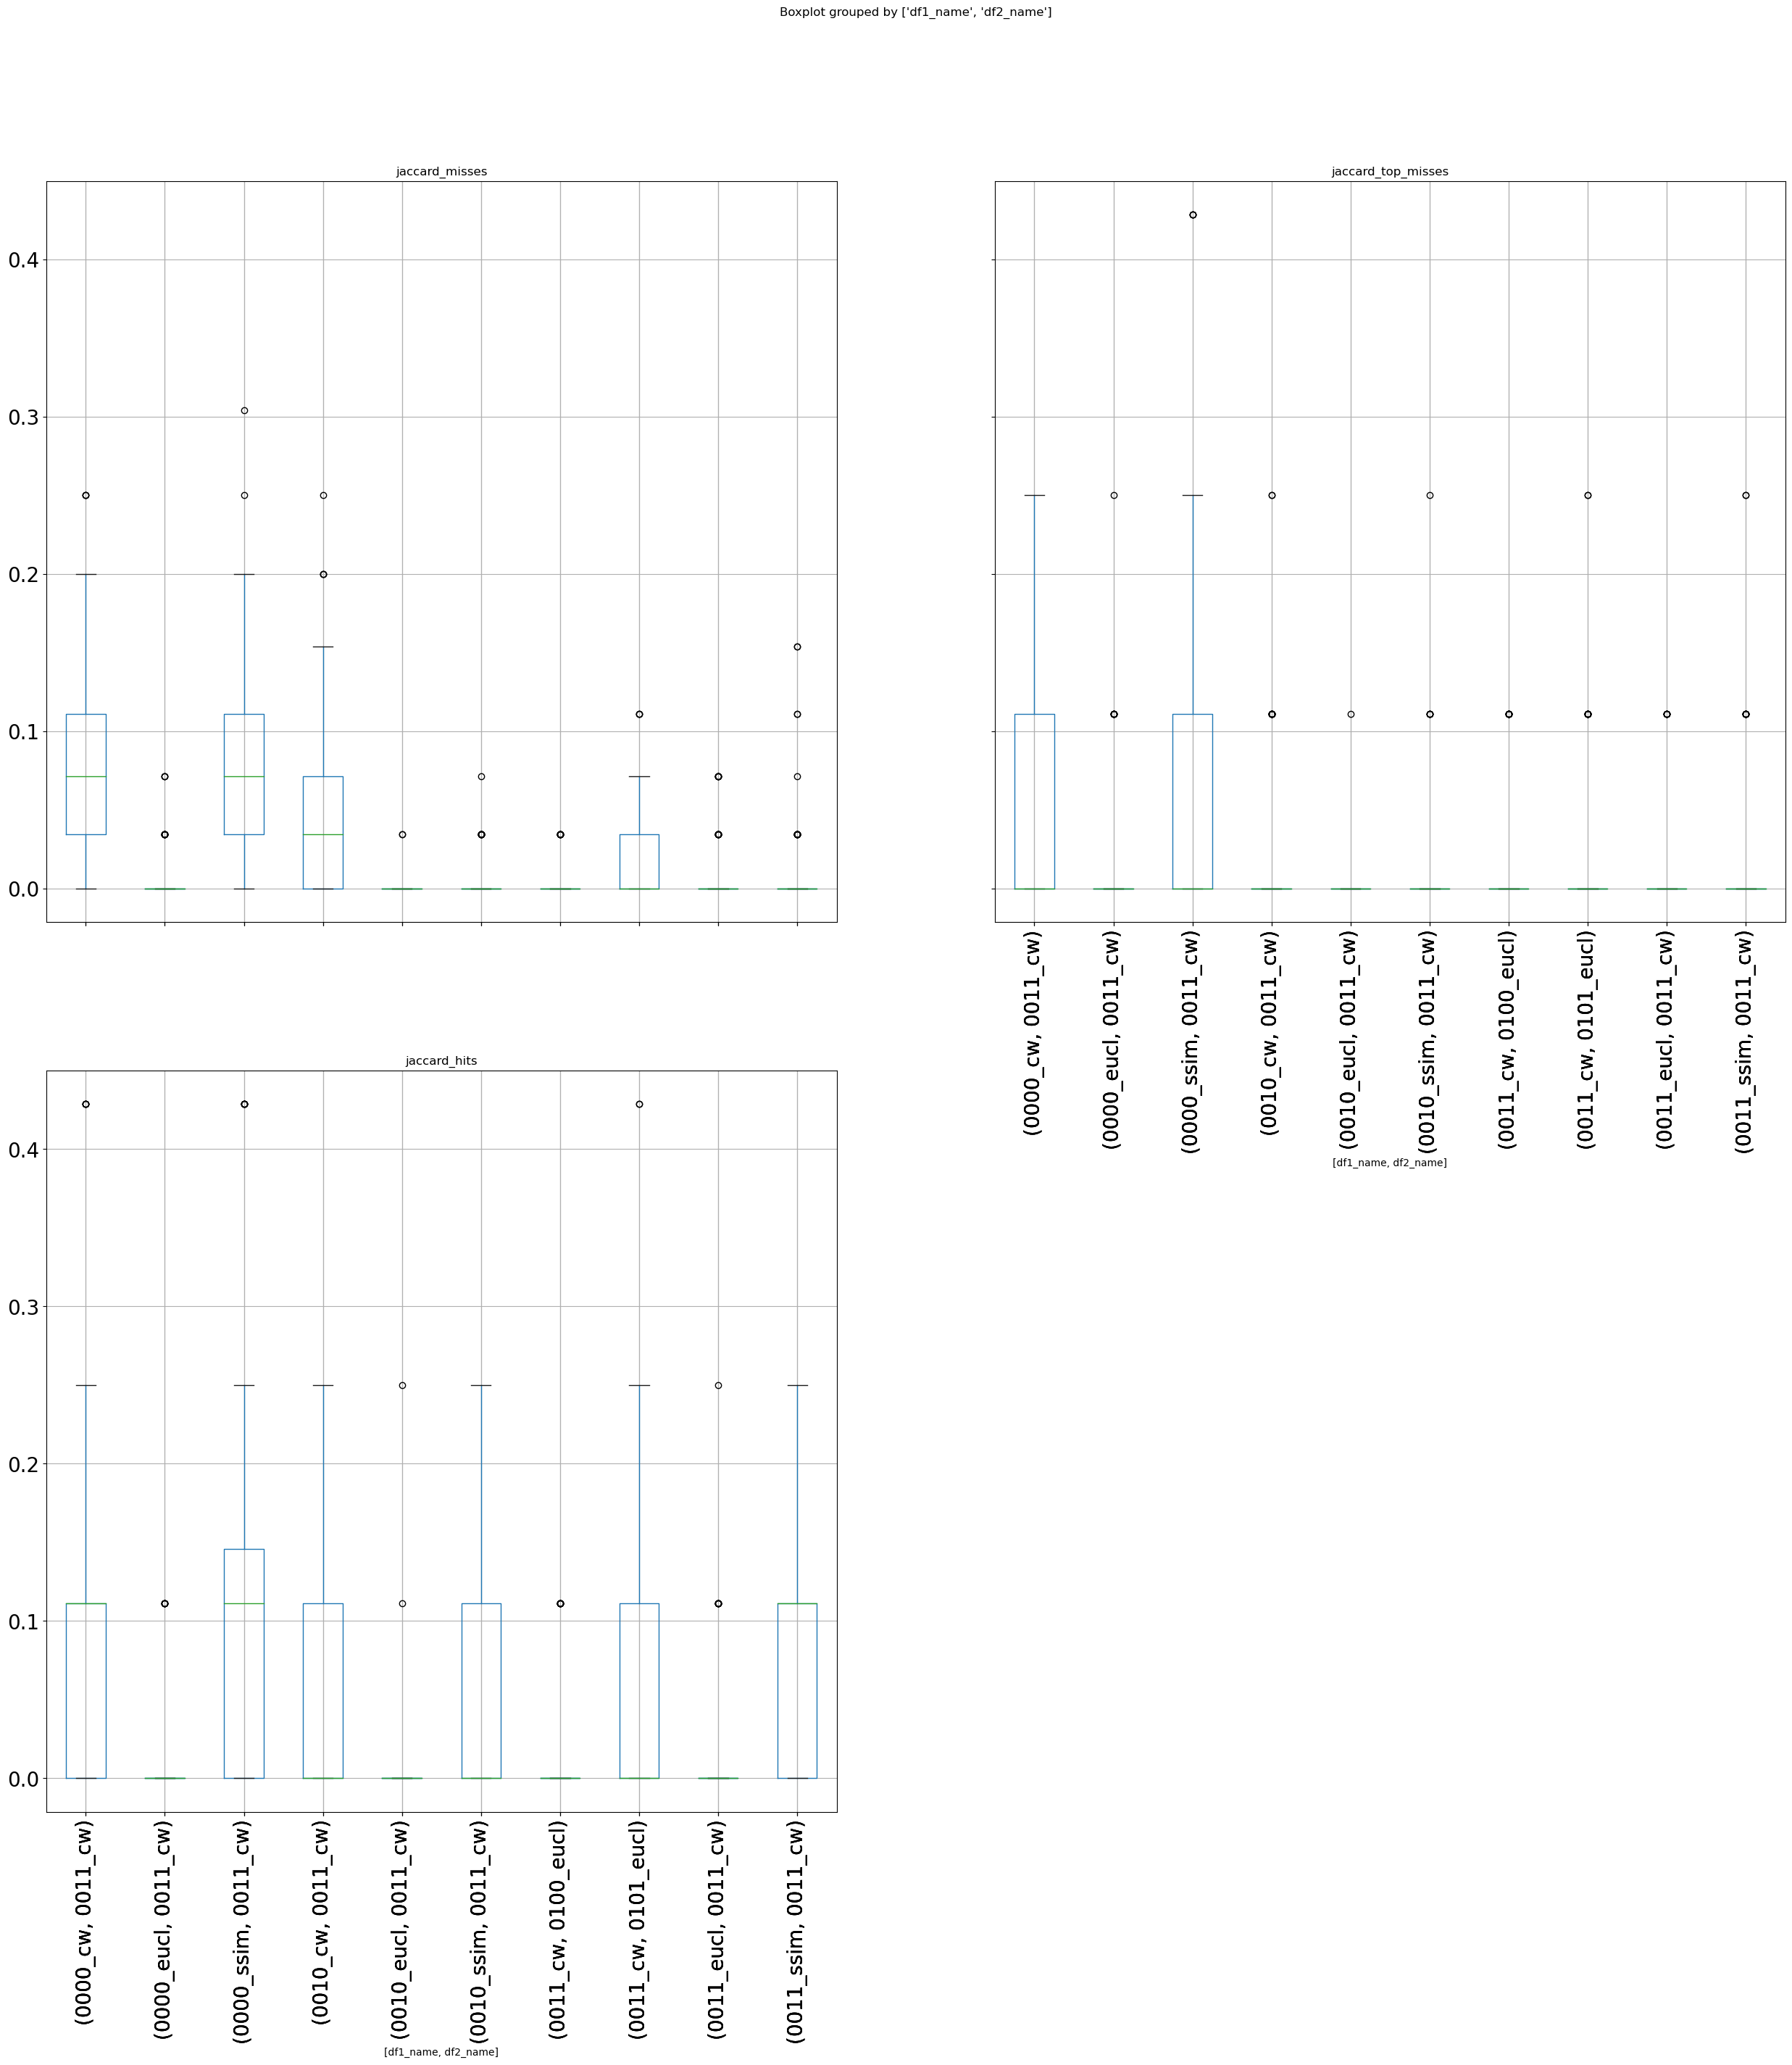

In [47]:
#cw ssim
# CNN
jaccards[(jaccards.df1_name.str[-4:]== "0_cw") |
         (jaccards.df2_name.str[-4:] == "0_cw")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)
# VGG
jaccards[(jaccards.df1_name.str[-4:]== "1_cw") |
         (jaccards.df2_name.str[-4:] == "1_cw")].boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], 
                                                      by=["df1_name", "df2_name"], figsize=(30,30), rot = 90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fecc2e86ee0>,
      dtype=object)

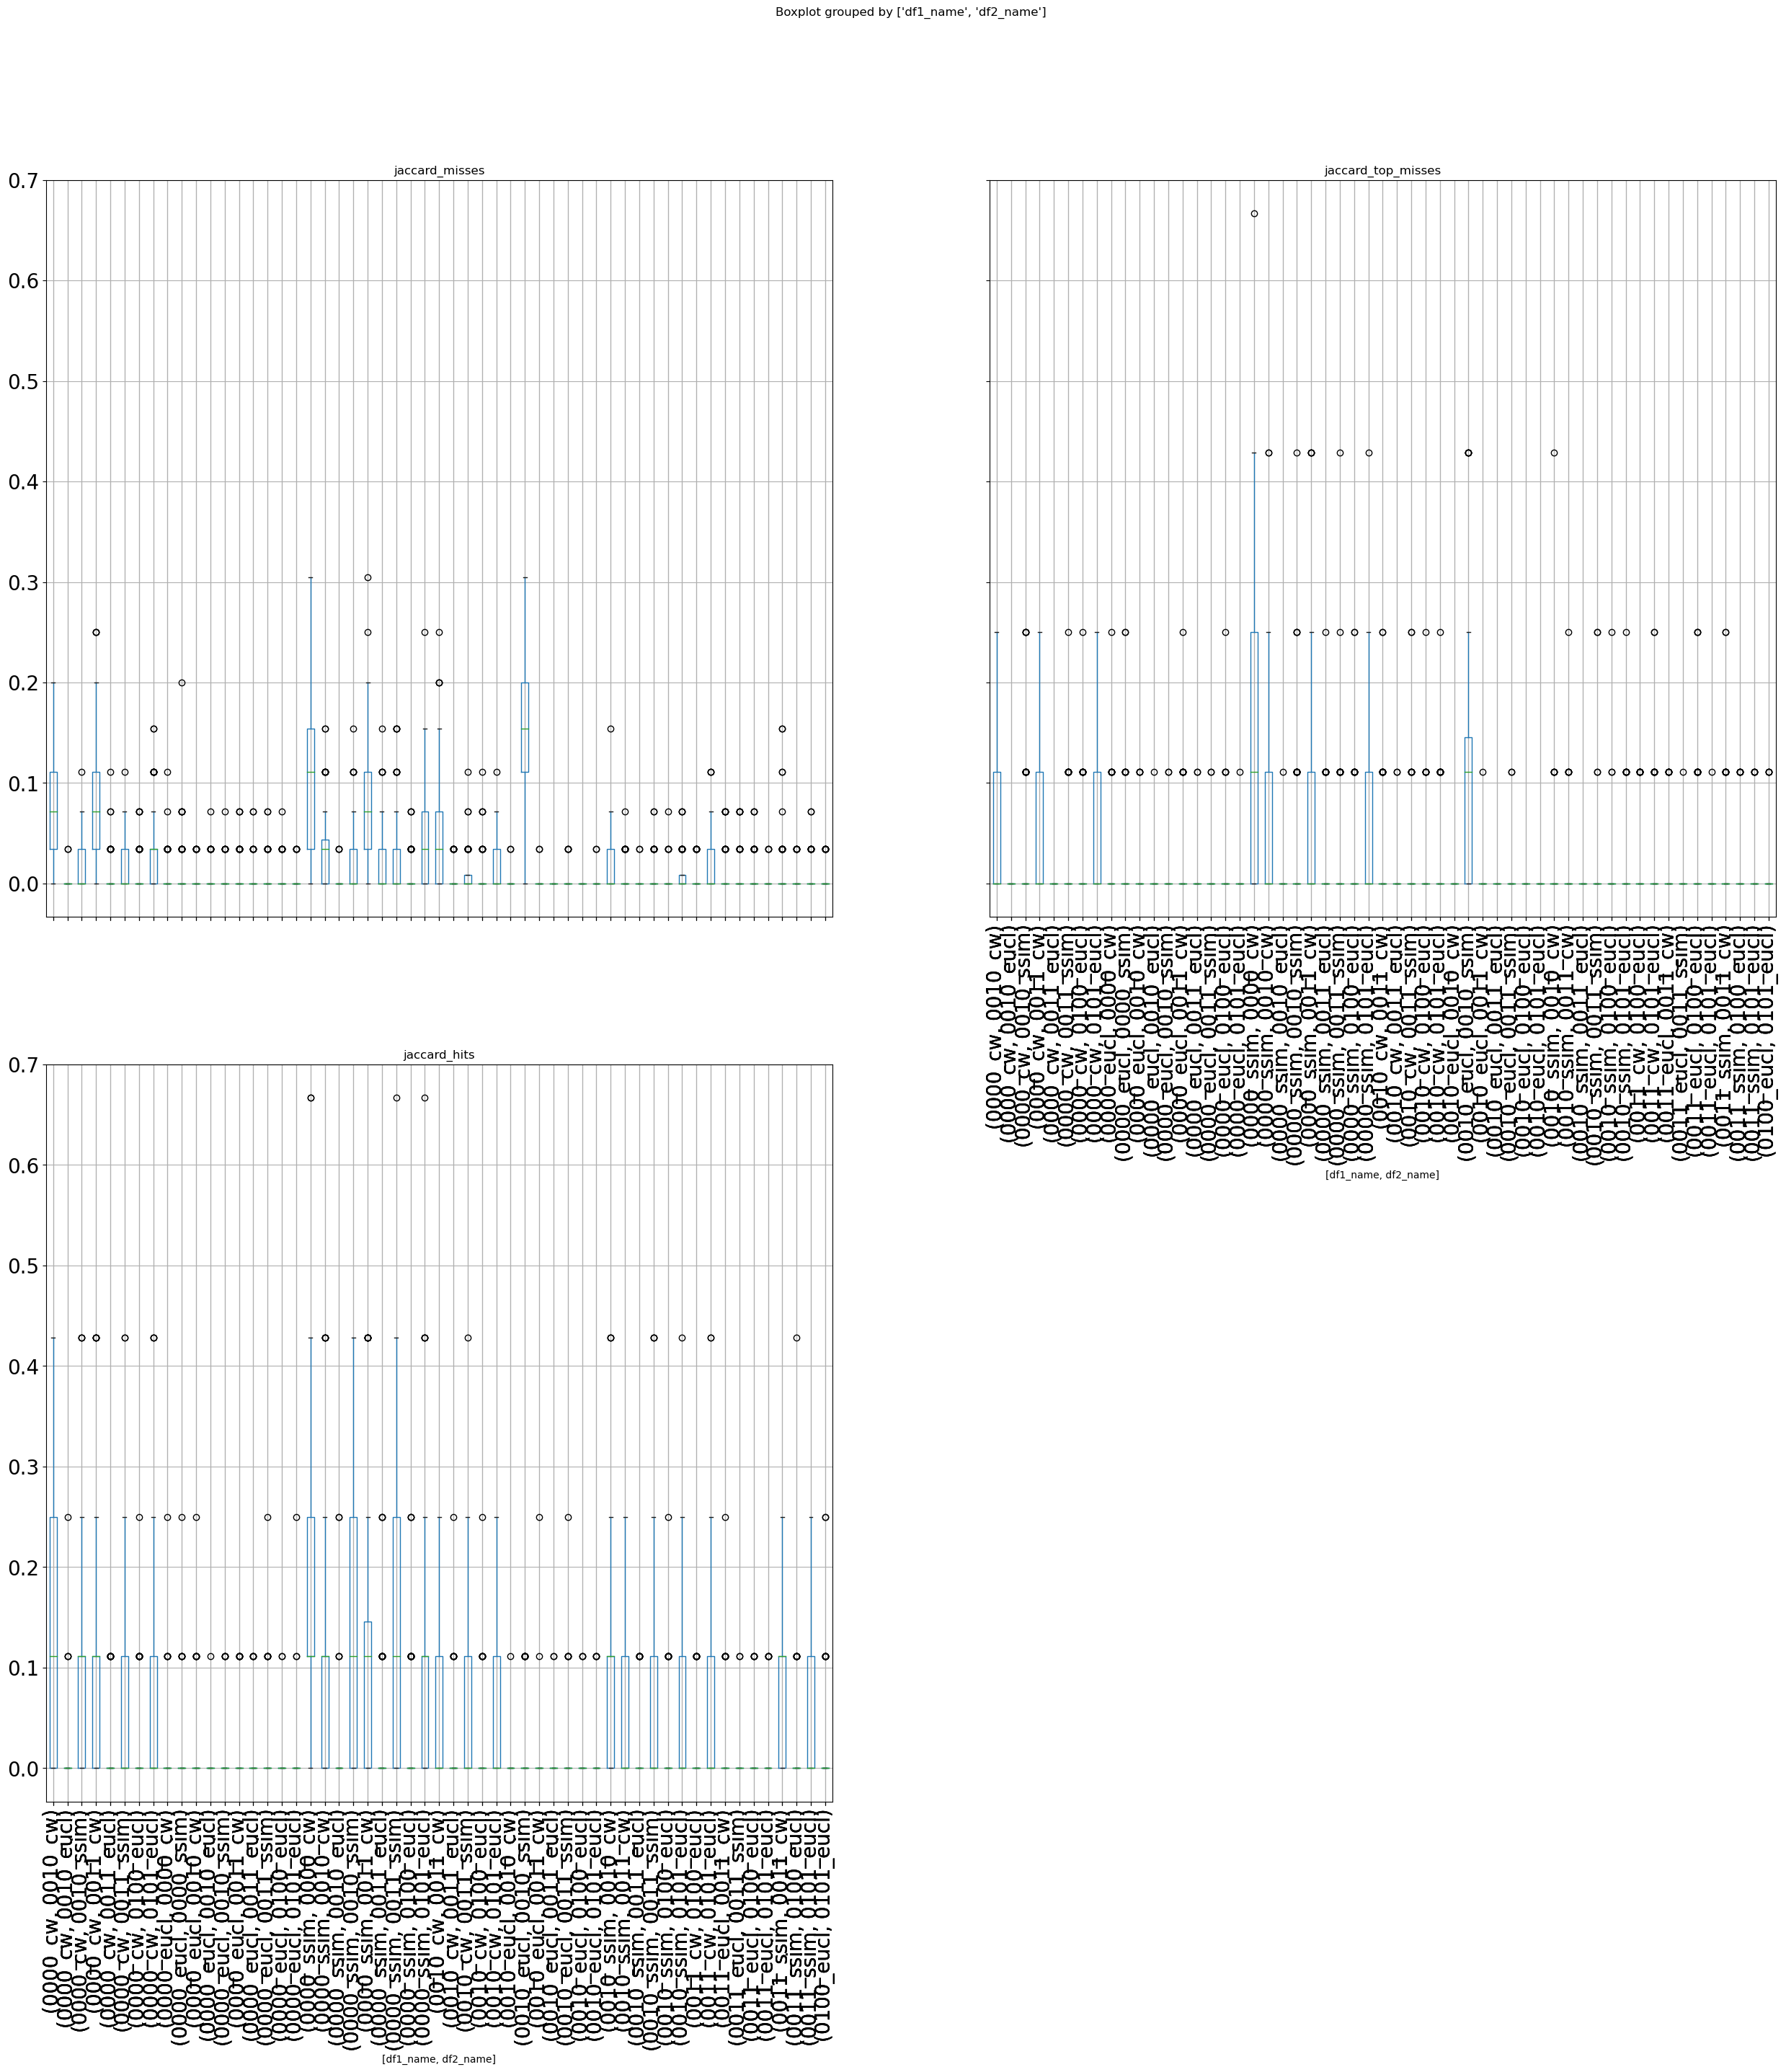

In [48]:
jaccards.boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], by=["df1_name", "df2_name"],
                figsize=(30,30), rot = 90, fontsize=20)

#### Absolute intersection
Reminder: the maximum absolute number is #NHNM for the hits and #NHNM * (#classes - 1) for misses

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feca15a73a0>,
      dtype=object)

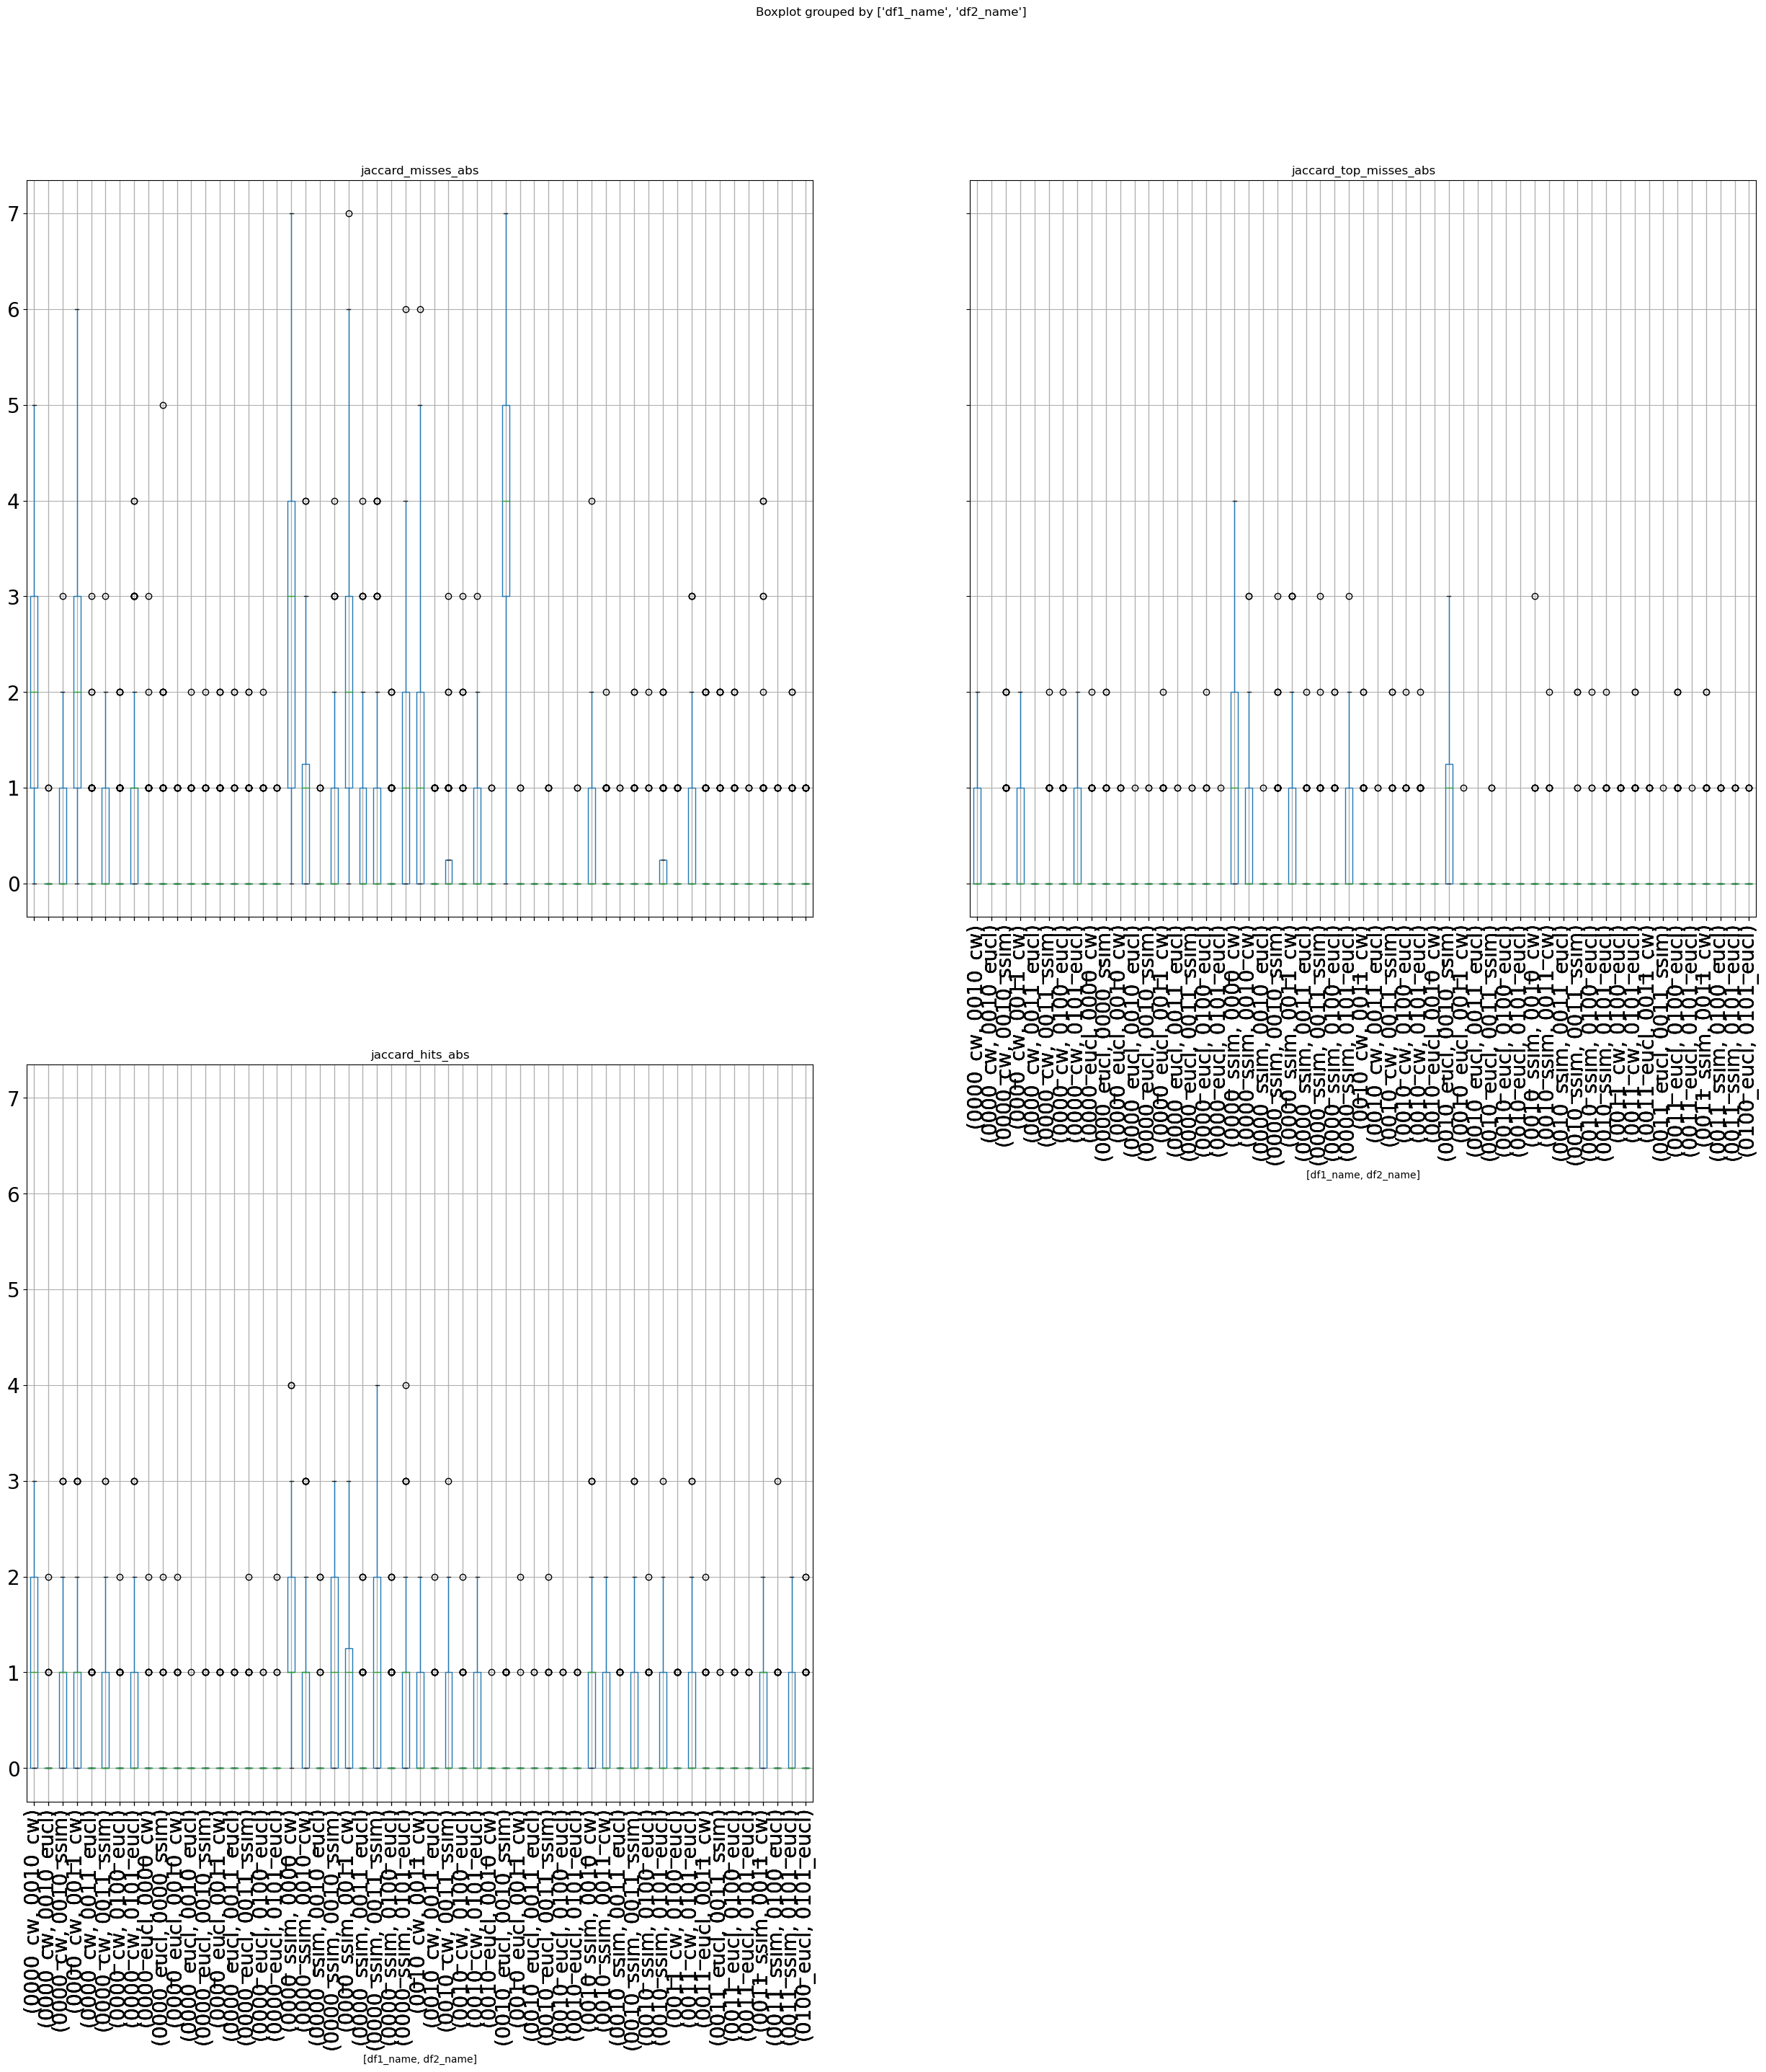

In [49]:
jaccards.boxplot(column=["jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"], by=["df1_name", "df2_name"],
                figsize=(30,30), rot = 90, fontsize=20)

#### Statistical tests

In [50]:
# t-test
c = 0
for m1 in jaccards.group.value_counts().index:
    _, p = stats.ttest_1samp(a=jaccards[jaccards.group == m1]["jaccard_misses"], popmean=0)
    if p > 0.01:  # p value too big, these are not different from an all 0 distribution
        print(m1)
        print(p)
        c += 1
print(c)

0010_eucl_0011_ssim
0.044934725212630505
0010_eucl_0011_cw
0.15833990565972575
0010_eucl_0101_eucl
0.15833990565972592
0010_ssim_0011_eucl
0.15833990565972592
0010_ssim_0100_eucl
0.03429472777976961
0010_eucl_0010_cw
0.15833990565972592
0011_eucl_0101_eucl
0.08324862524496096
0000_eucl_0101_eucl
0.0245895225721711
0000_ssim_0010_eucl
0.08324862524496096
0000_cw_0010_eucl
0.15833990565972592
10


In [51]:
# comparison to all 0 vector
tmp = [0] * 100
c = 0
for m1 in jaccards.group.value_counts().index:
    try:
        _, p = stats.wilcoxon(jaccards[jaccards.group == m1]["jaccard_misses"],tmp)
        if p > 0.01:  # p value too big, these are not different from an all 0 distribution
            print(m1)
            print(p)
            c += 1
    except ValueError:
        print(m1)
        print("all values 0")
        c += 1
print(c)

0010_eucl_0011_ssim
0.04550026389635839
0010_eucl_0011_cw
0.15729920705028502
0010_eucl_0100_eucl
all values 0
0010_eucl_0101_eucl
0.15729920705028502
0010_ssim_0011_eucl
0.15729920705028502
0010_ssim_0100_eucl
0.03389485352468927
0010_eucl_0010_cw
0.15729920705028502
0011_eucl_0101_eucl
0.0832645166635504
0010_eucl_0011_eucl
all values 0
0000_eucl_0101_eucl
0.025347318677468252
0000_ssim_0010_eucl
0.0832645166635504
0000_cw_0010_eucl
0.15729920705028502
12


/Users/biancazimmer/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


#### Result:

all distances:
* Since Jaccard index is a measure of similarity 0 means that A nad B are totally different
* top 15 misses yield higher jaccard indices than top misses -> to be expected since more variability in top15 allowed than in top misses. here the misses have to match per category
* not surprisingly distances on the raw images produce same NHNM for CNN and VGG -> model is not used here anyway
* all combinations yield Jaccard Indices pretty close to 0 -> all combinations seem to yield different results
* conducting a Wilcoxon Rank Test to a vector of 100*0, alpha = 0.005 (corrected for multiple 91x testing) we can see that in 15 cases we can not reject the Nullhypothesis that the JaccardIndices are indeed 0.
* although t-Test normality distribution assumption not met - 13 cases we can not reject the Nullhypothesis that the JaccardIndices are indeed 0

euclidean:
* 0010_eucl to 0010_ssim yields the most similar results in the top 15 missed, same goes for top misses
* 0101_eucl is pretty similar to all the rawData hits/misses -> FE of VGG gives not much different information than raw image data
* results for VGG are different than those for CNN: 0101_eucl produces similar results to all rawData models (ssim and cw) -> 0101_eucl (FE) does not give much different information than the rawData; not surpising since this was run on VGG and thus not much of an information gain was to be expected
* no similarity can be seen when looking at 0010_eucl/0010_ssim to 0011_eucl which was to be expected -> CNN gives different information than general VGG; same goes for 010_eucl to 0101_eucl


### OCT

In [52]:
# calculate Jaccard Indeces for every combination of DataFrames
jaccards_oct = pd.DataFrame()
for m1, df1 in oct_df.items():
    for m2, df2 in oct_df.items():
        # print(m1+"_"+m2)
        if m1 == m2:  # if compare DataFrame to itself -> continue
            continue
        try:
            if m2 + "_" + m1 in np.array(jaccards_oct.group):  # since jaccard(A,B) == jaccard(B,A) we can speed up by skipping
                continue
        except AttributeError:  # if it's the first time we compare these DataFrames it's okay to have an error
            pass
        new = jaccard_nhnmtm(df1, df2, group=m1 + "_" + m2, df1_name=m1, df2_name=m2)
        jaccards_oct = pd.concat([jaccards_oct, new], ignore_index=True)

jaccards_oct

jaccard_hits  jaccard_hits_abs  jaccard_misses  jaccard_misses_abs  \
0              0.0                 0        0.000000                   0   
1              0.0                 0        0.000000                   0   
2              0.0                 0        0.000000                   0   
3              0.0                 0        0.000000                   0   
4              0.0                 0        0.000000                   0   
...            ...               ...             ...                 ...   
2795           0.0                 0        0.000000                   0   
2796           0.0                 0        0.000000                   0   
2797           0.0                 0        0.034483                   1   
2798           0.0                 0        0.000000                   0   
2799           0.0                 0        0.000000                   0   

      jaccard_top_misses  jaccard_top_misses_abs                group  \
0               0.000000                       0  1000_eucl_1000_ssim   
1               0.000000                       0  1000_eucl_1000_ssim   
2               0.000000                       0  1000_eucl_1000_ssim   
3               0.000000                       0  1000_eucl_1000_ssim   
4               0.000000                       0  1000_eucl_1000_ssim   
...                  ...                     ...                  ...   
2795            0.000000                       0  1100_eucl_1101_eucl   
2796            0.000000                       0  1100_eucl_1101_eucl   
2797            0.111111                       1  1100_eucl_1101_eucl   
2798            0.000000                       0  1100_eucl_1101_eucl   
2799            0.000000                       0  1100_eucl_1101_eucl   

       df1_name   df2_name  
0     1000_eucl  1000_ssim  
1     1000_eucl  1000_ssim  
2     1000_eucl  1000_ssim  
3     1000_eucl  1000_ssim  
4     1000_eucl  1000_ssim  
...         ...        ...  
2795  1100_eucl  1101_eucl  
2796  1100_eucl  1101_eucl  
2797  1100_eucl  1101_eucl  
2798  1100_eucl  1101_eucl  
2799  1100_eucl  1101_eucl  

[2800 rows x 9 columns]

In [53]:
# jaccards_oct.describe()
jaccards_oct.groupby(["df1_name", "df2_name"]).describe()# .transpose()

jaccard_hits                                          \
                           count      mean       std  min  25%  50%  75%   
df1_name  df2_name                                                         
1000_eucl 1000_ssim        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1010_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1010_ssim        100.0  0.002222  0.015634  0.0  0.0  0.0  0.0   
          1011_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1011_ssim        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1100_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
1000_ssim 1010_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1010_ssim        100.0  0.003333  0.019050  0.0  0.0  0.0  0.0   
          1011_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1011_ssim        100.0  0.009444  0.040882  0.0  0.0  0.0  0.0   
          1100_eucl        100.0  0.005556  0.024338  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.012222  0.034941  0.0  0.0  0.0  0.0   
1010_eucl 1010_ssim        100.0  0.004722  0.029295  0.0  0.0  0.0  0.0   
          1011_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1011_ssim        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1100_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
1010_ssim 1011_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1011_ssim        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1100_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
1011_eucl 1011_ssim        100.0  0.001111  0.011111  0.0  0.0  0.0  0.0   
          1100_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
1011_ssim 1100_eucl        100.0  0.002222  0.015634  0.0  0.0  0.0  0.0   
          1101_eucl        100.0  0.005556  0.024338  0.0  0.0  0.0  0.0   
1100_eucl 1101_eucl        100.0  0.012341  0.054372  0.0  0.0  0.0  0.0   

                              jaccard_hits_abs        ... jaccard_top_misses  \
                          max            count  mean  ...                75%   
df1_name  df2_name                                    ...                      
1000_eucl 1000_ssim  0.111111            100.0  0.01  ...                0.0   
          1010_eucl  0.111111            100.0  0.01  ...                0.0   
          1010_ssim  0.111111            100.0  0.02  ...                0.0   
          1011_eucl  0.000000            100.0  0.00  ...                0.0   
          1011_ssim  0.111111            100.0  0.01  ...                0.0   
          1100_eucl  0.111111            100.0  0.01  ...                0.0   
          1101_eucl  0.000000            100.0  0.00  ...                0.0   
1000_ssim 1010_eucl  0.111111            100.0  0.01  ...                0.0   
          1010_ssim  0.111111            100.0  0.03  ...                0.0   
          1011_eucl  0.000000            100.0  0.00  ...                0.0   
          1011_ssim  0.250000            100.0  0.08  ...                0.0   
          1100_eucl  0.111111            100.0  0.05  ...                0.0   
          1101_eucl  0.111111            100.0  0.11  ...                0.0   
1010_eucl 1010_ssim  0.250000            100.0  0.04  ...                0.0   
          1011_eucl  0.000000            100.0  0.00  ...                0.0   
          1011_ssim  0.000000            100.0  0.00  ...                0.0   
          1100_eucl  0.111111            100.0  0.01  ...                0.0   
          1101_eucl  0.000000            100.0  0.00  ...      

In [54]:
oct_df["1000_eucl"]["image_name"].equals(oct_df["1000_ssim"]["image_name"])

True

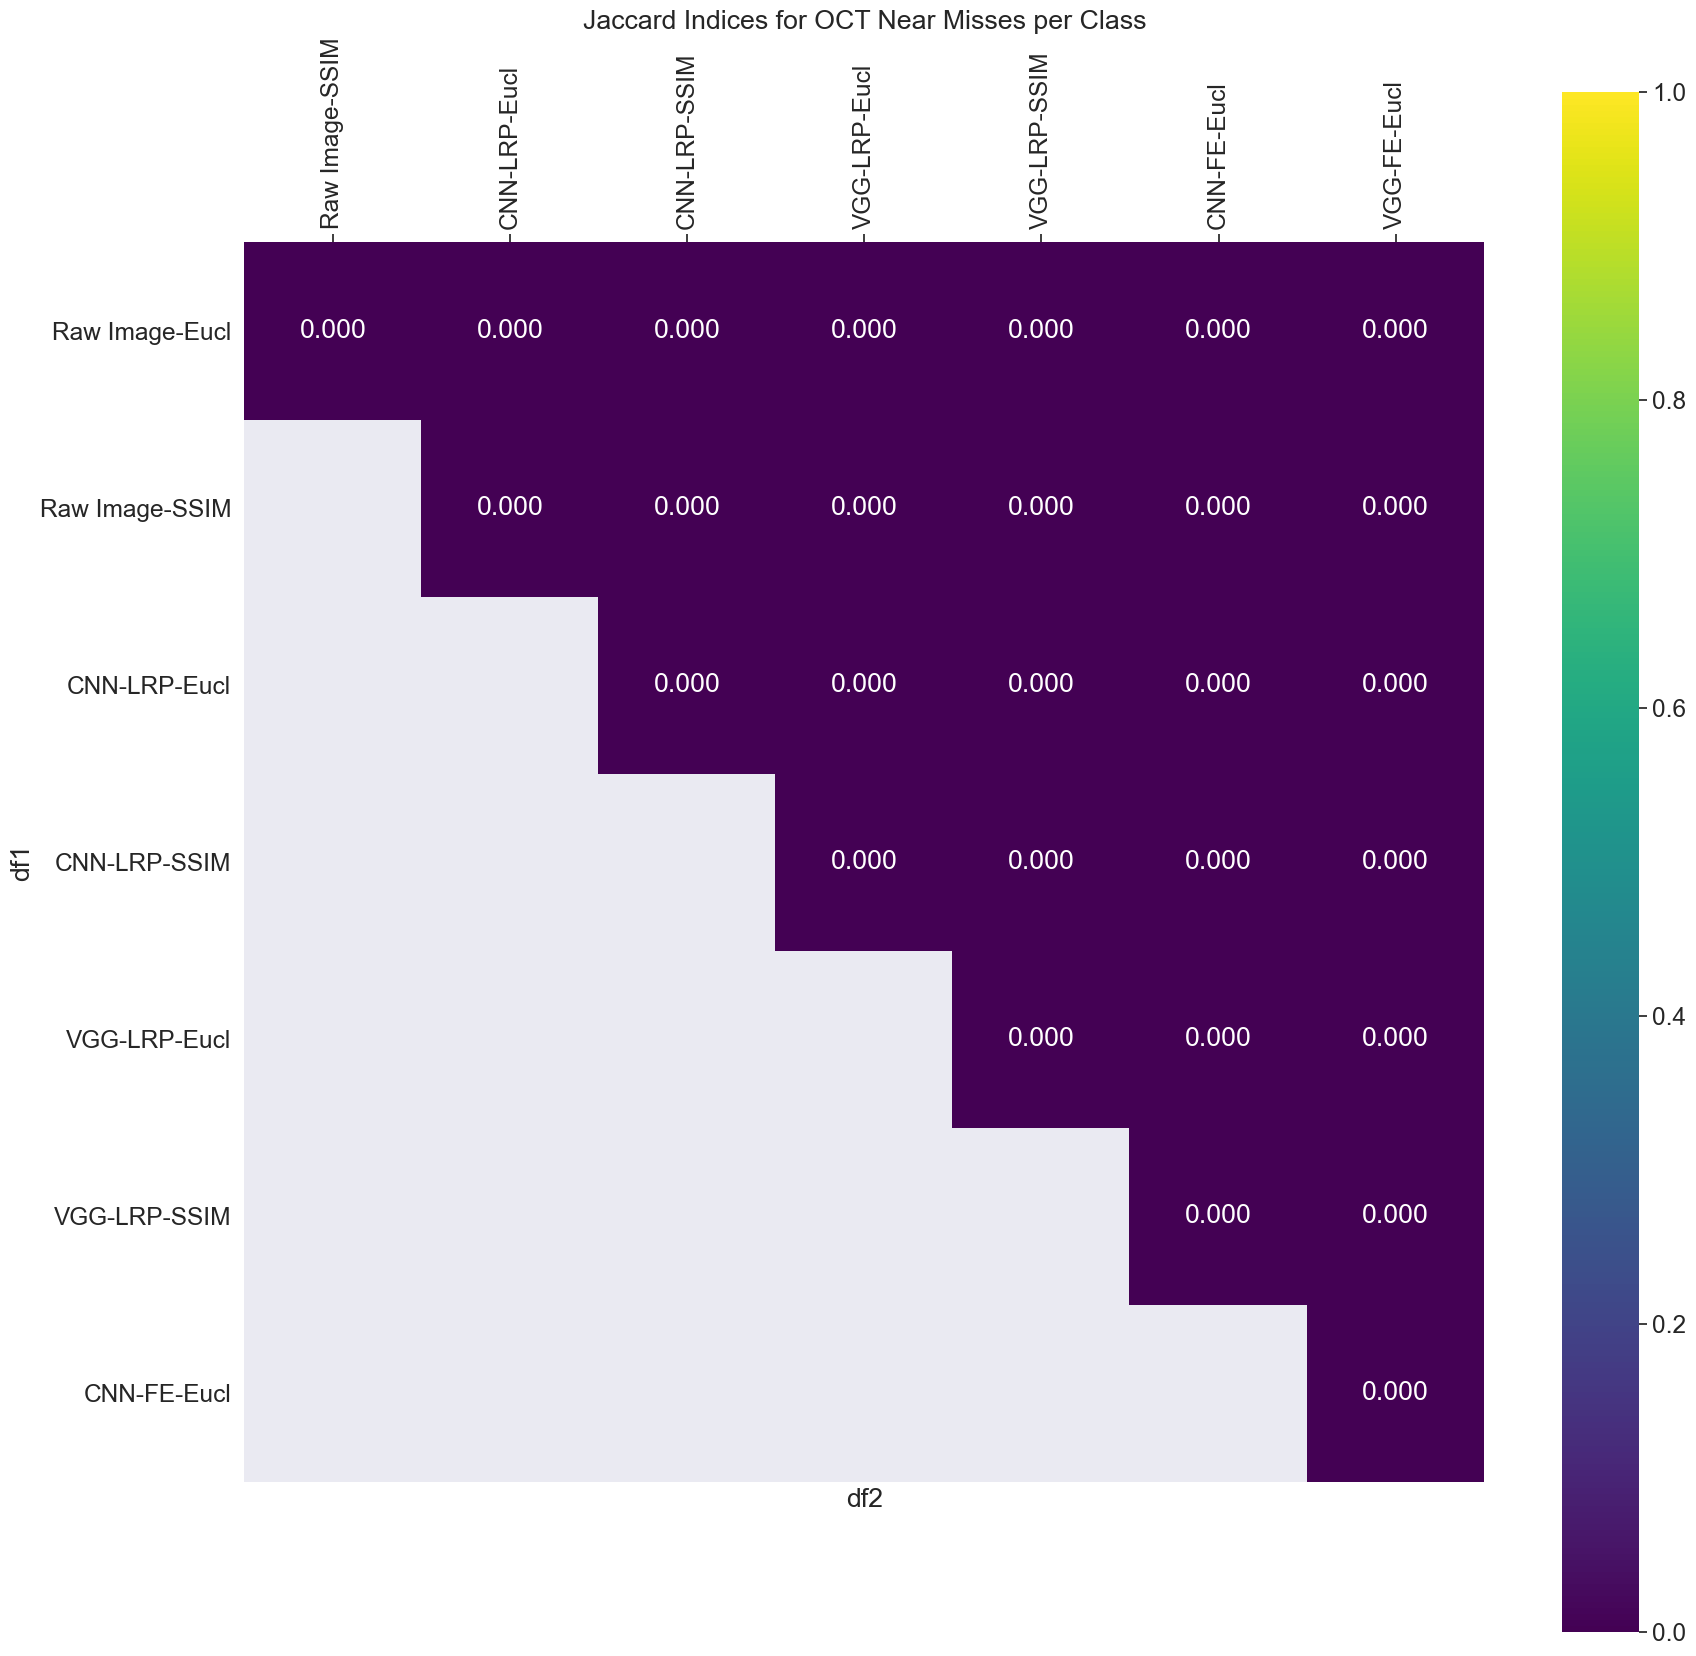

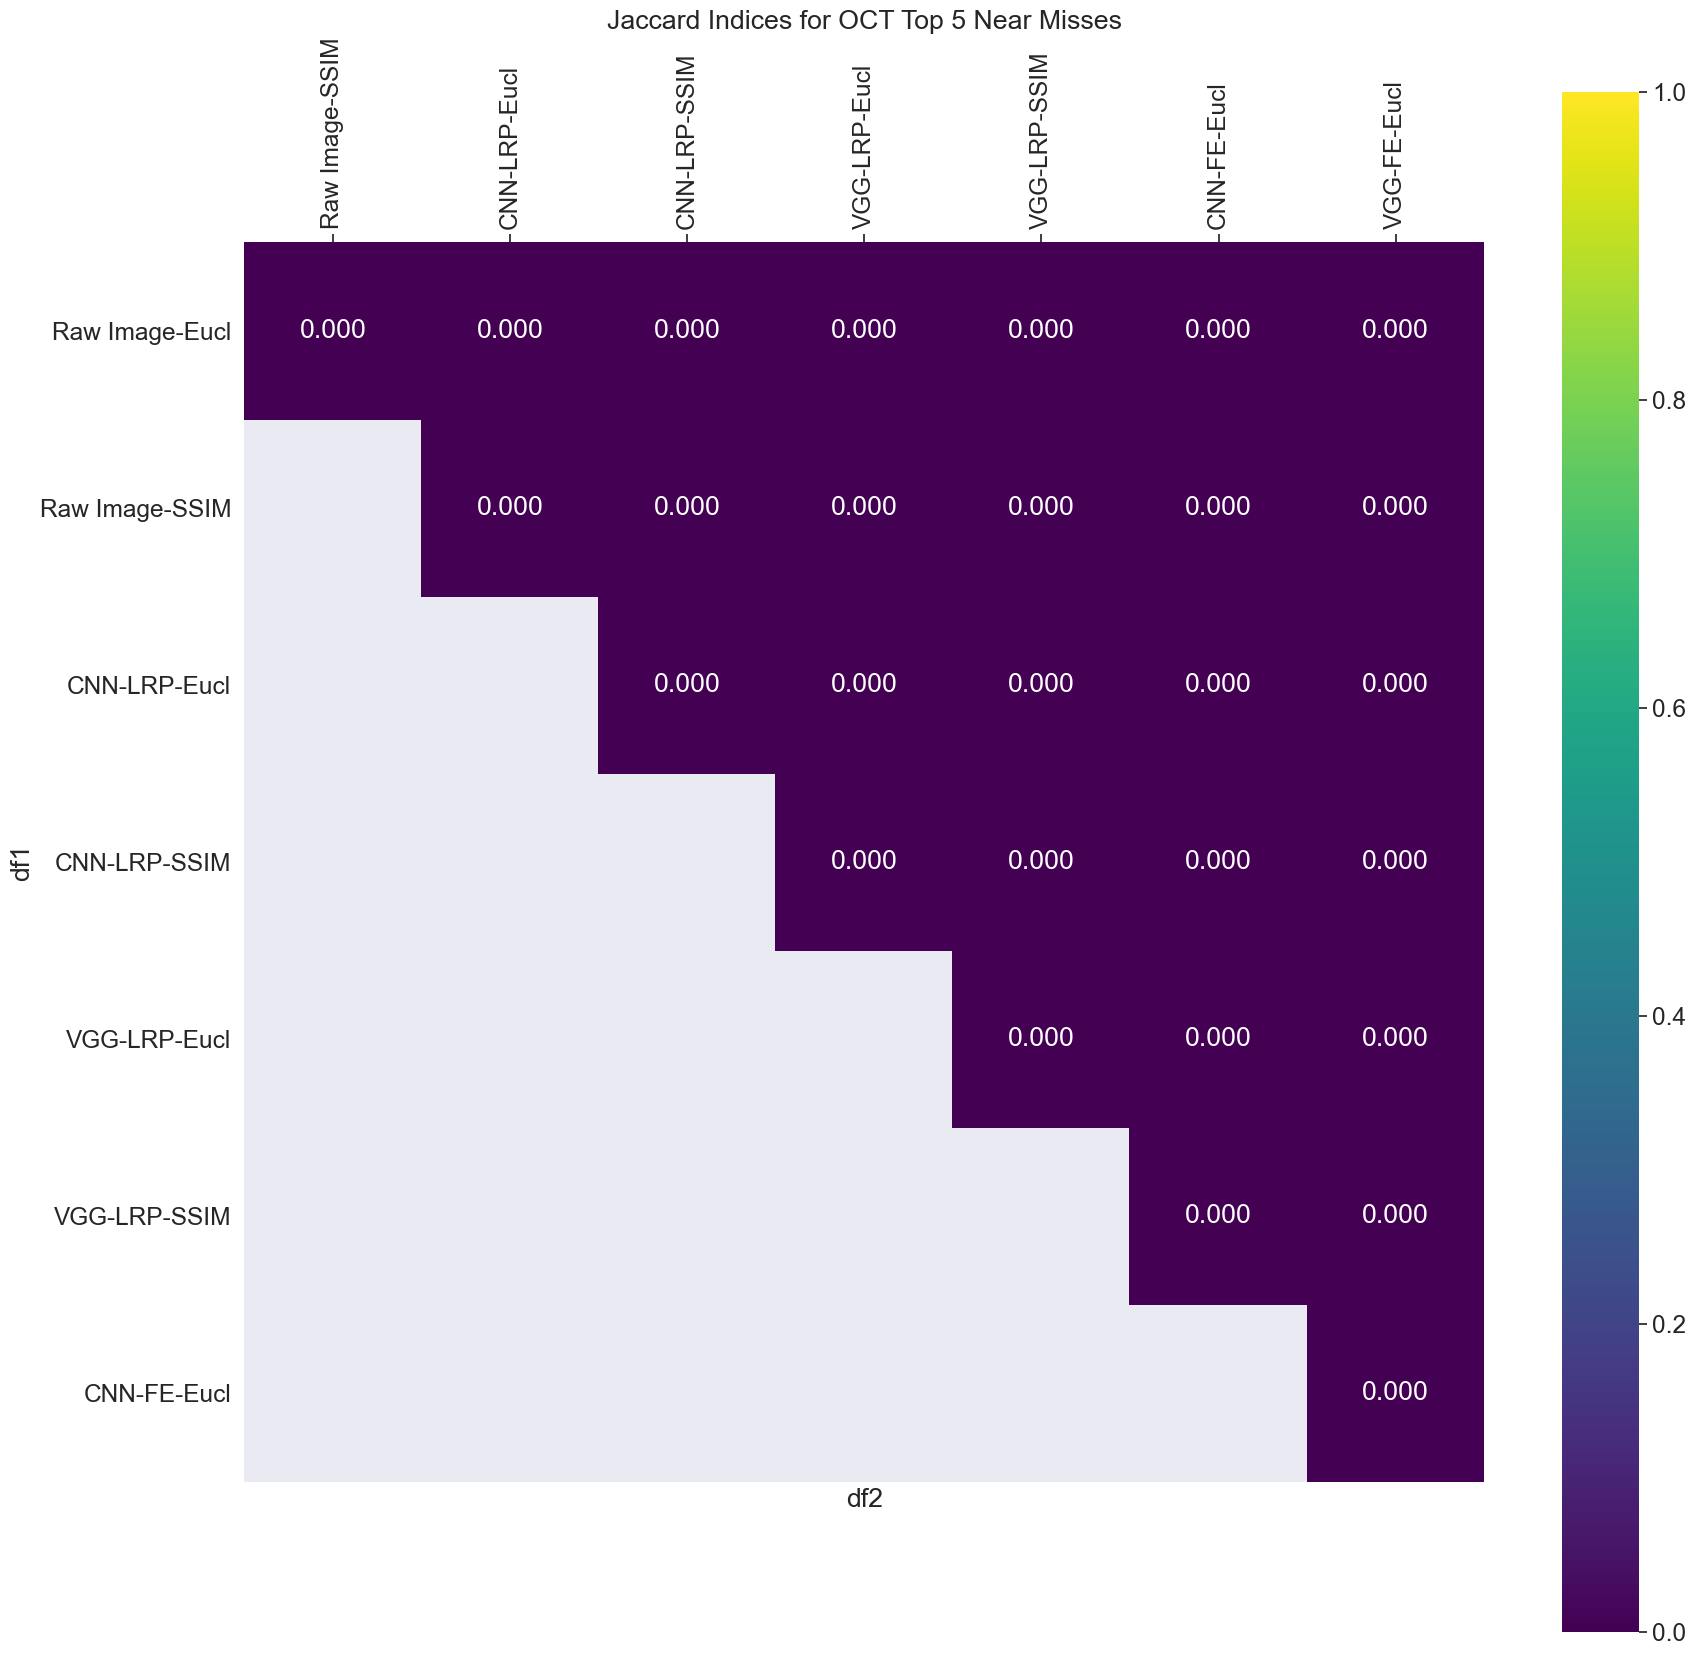

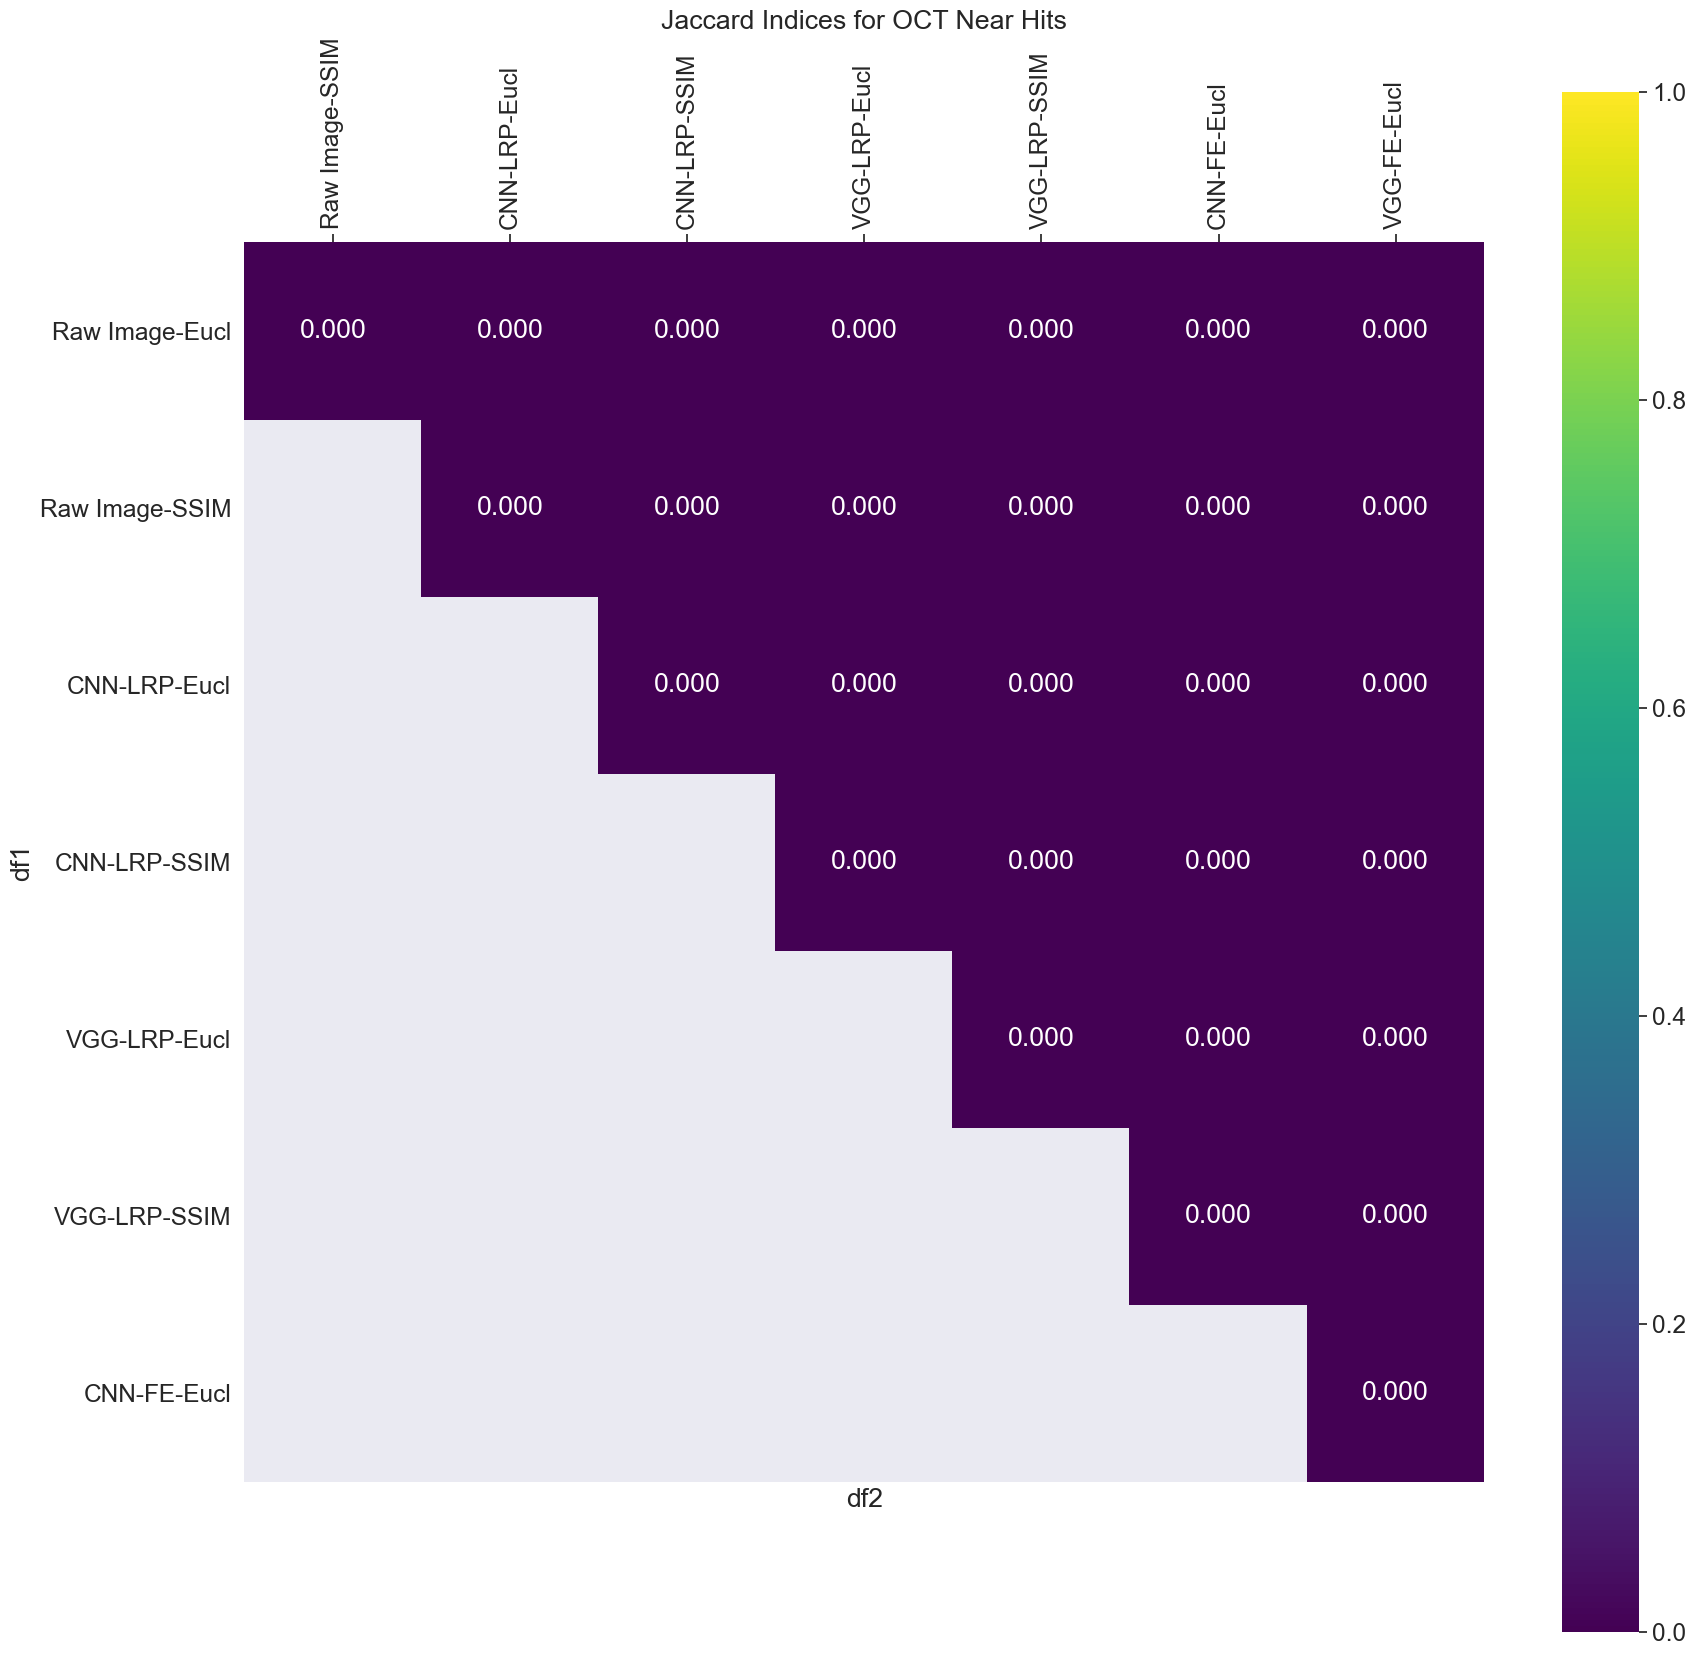

In [56]:
jaccards_oct2 = jaccards_oct.copy()
jaccards_oct2["df1_name"] = rename_numbers(jaccards_oct, "df1_name")
jaccards_oct2["df2_name"] = rename_numbers(jaccards_oct, "df2_name")

jaccards_heatmap(jaccards_oct2, "jaccard_misses", vmax=1, title = "Jaccard Indices for OCT Near Misses per Class")
jaccards_heatmap(jaccards_oct2, "jaccard_top_misses", vmax=1, title = "Jaccard Indices for OCT Top 5 Near Misses")
jaccards_heatmap(jaccards_oct2, "jaccard_hits", vmax=1, title = "Jaccard Indices for OCT Near Hits")

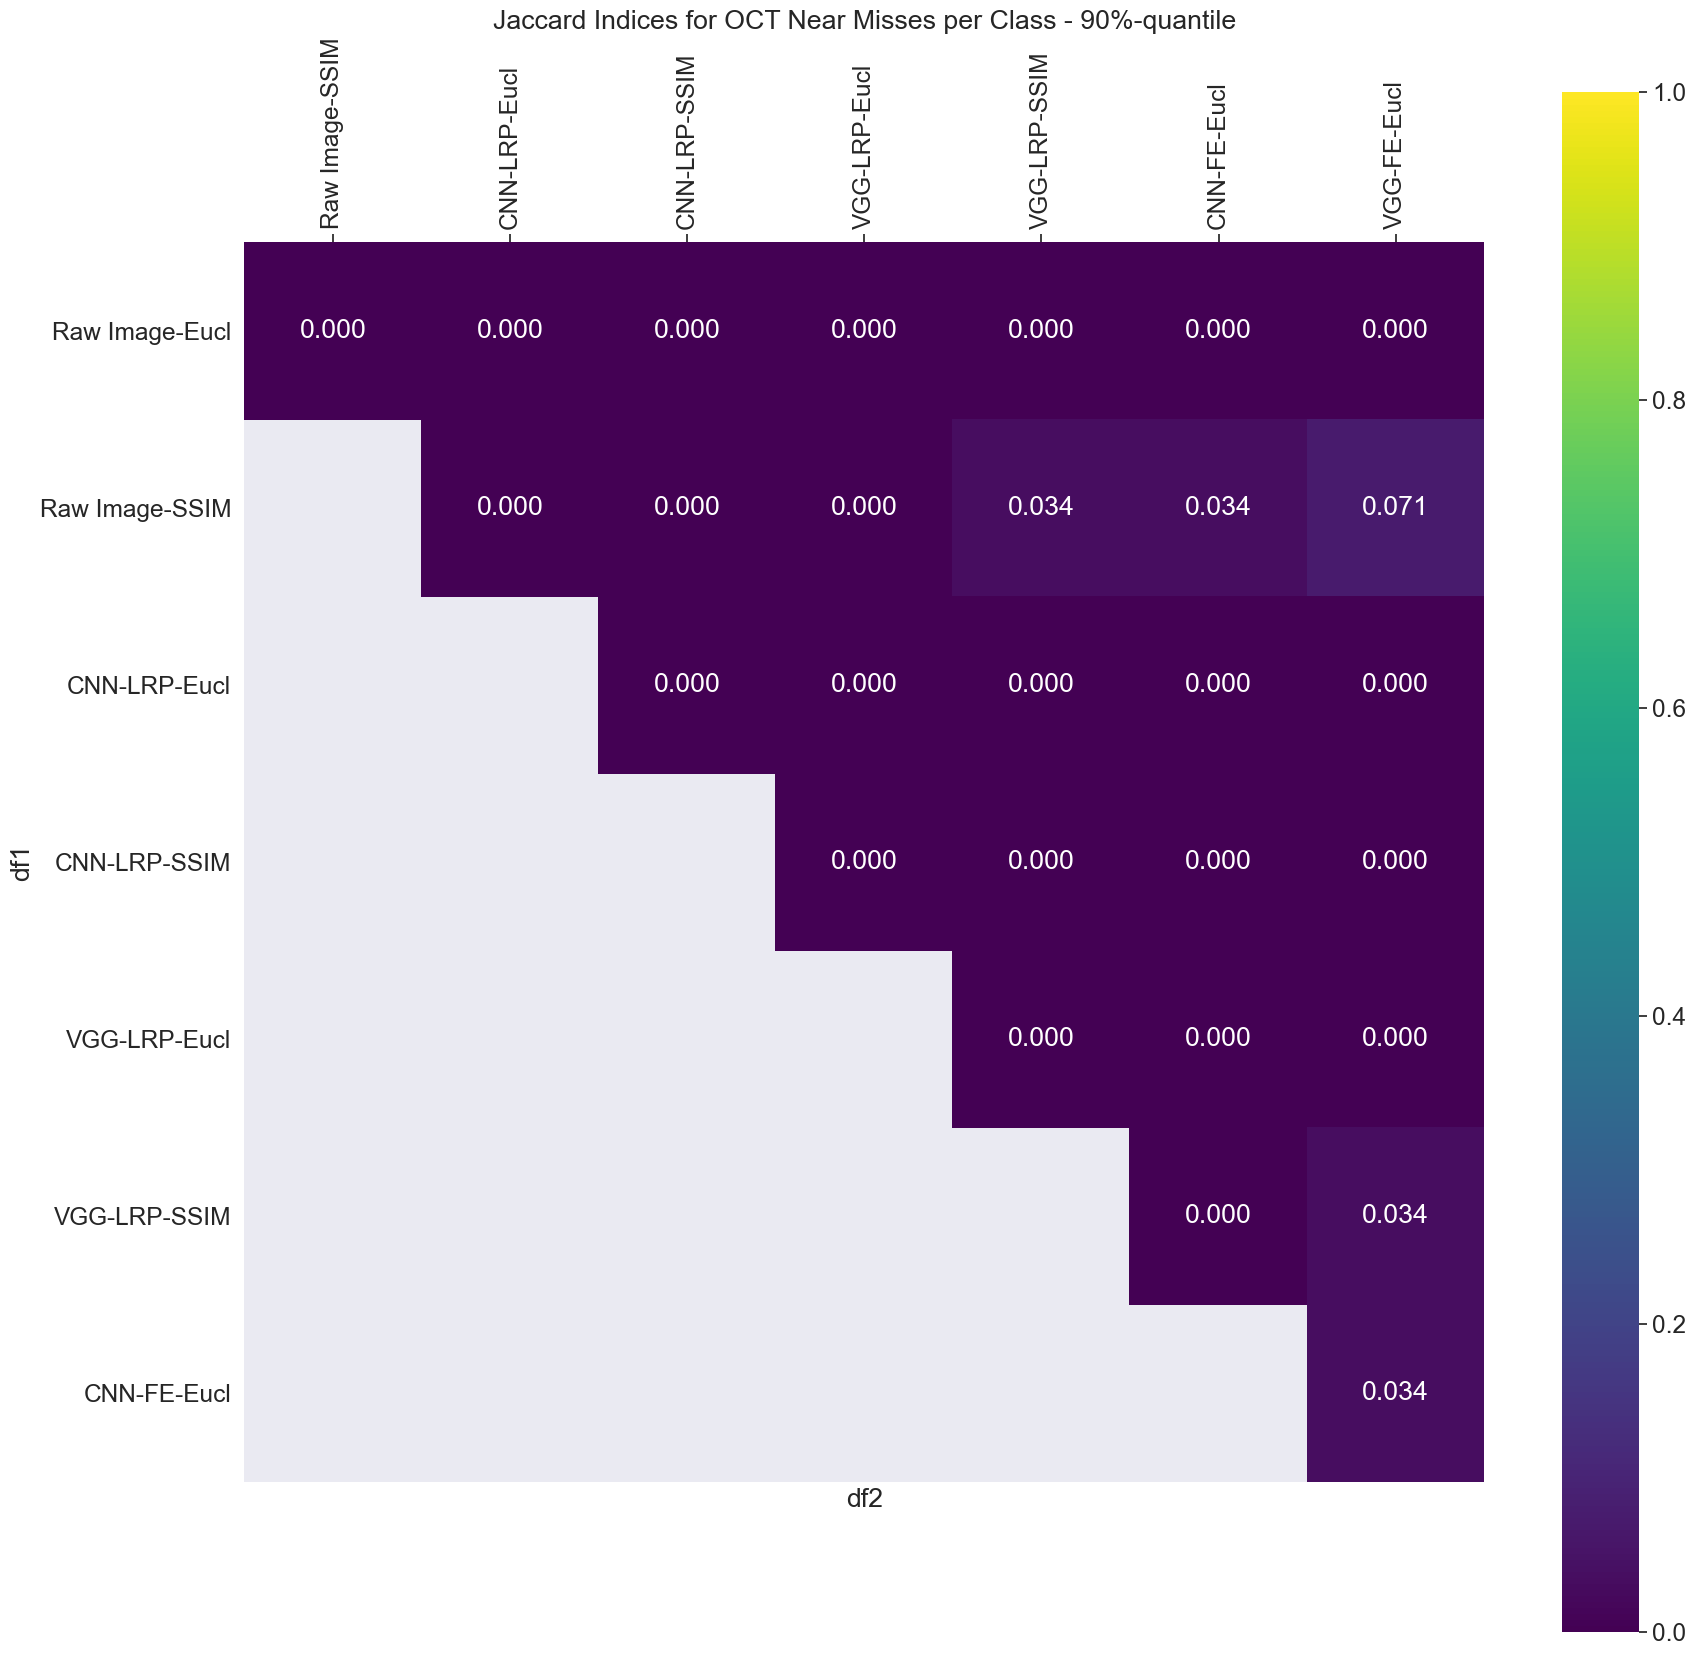

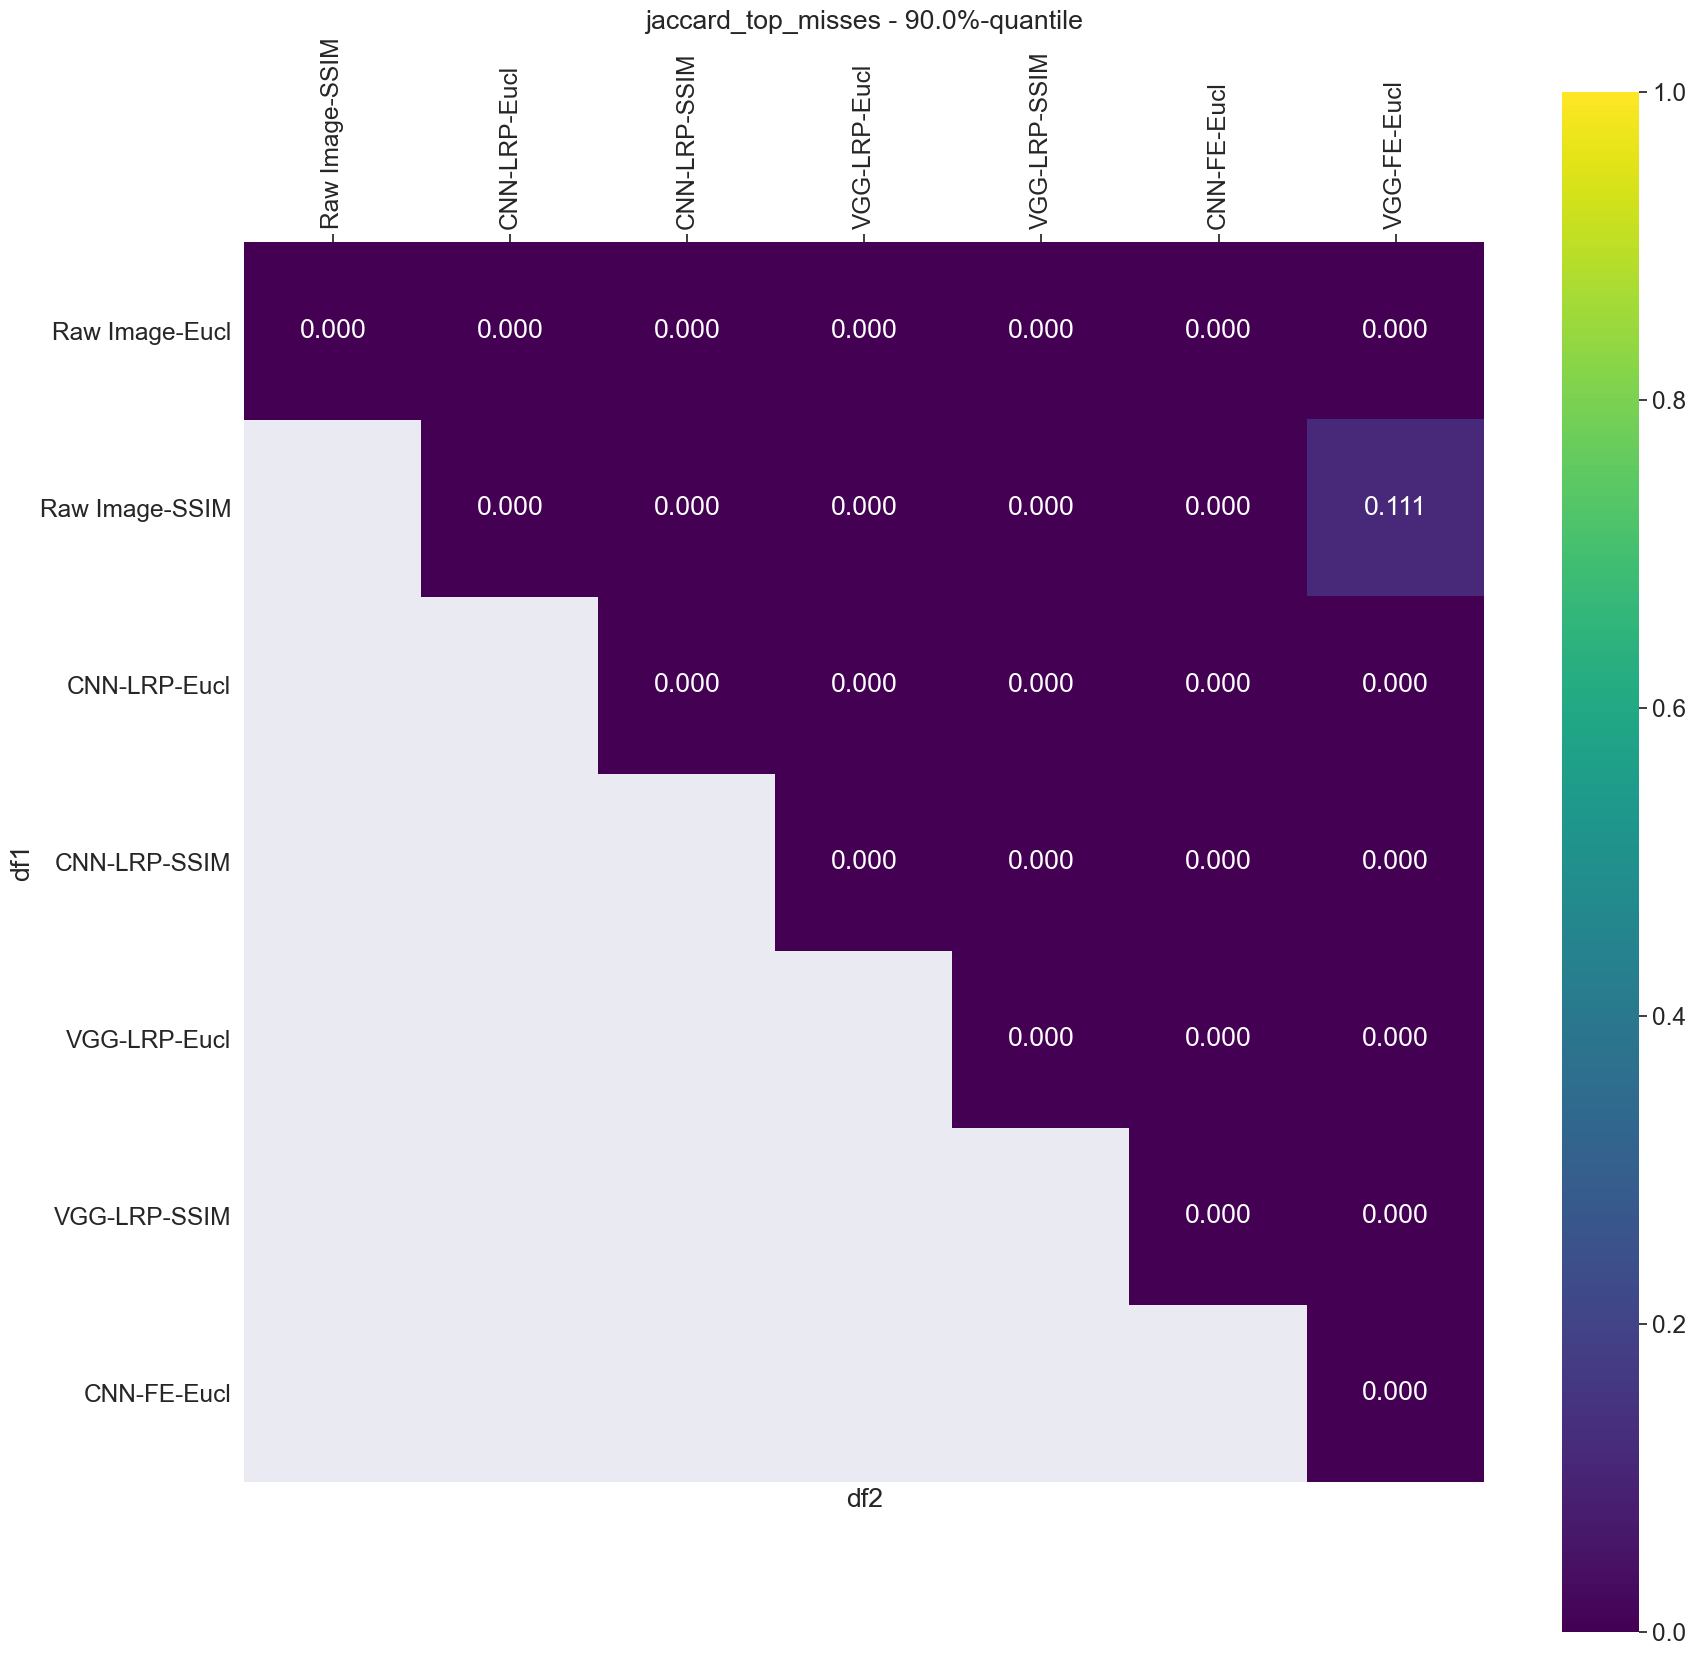

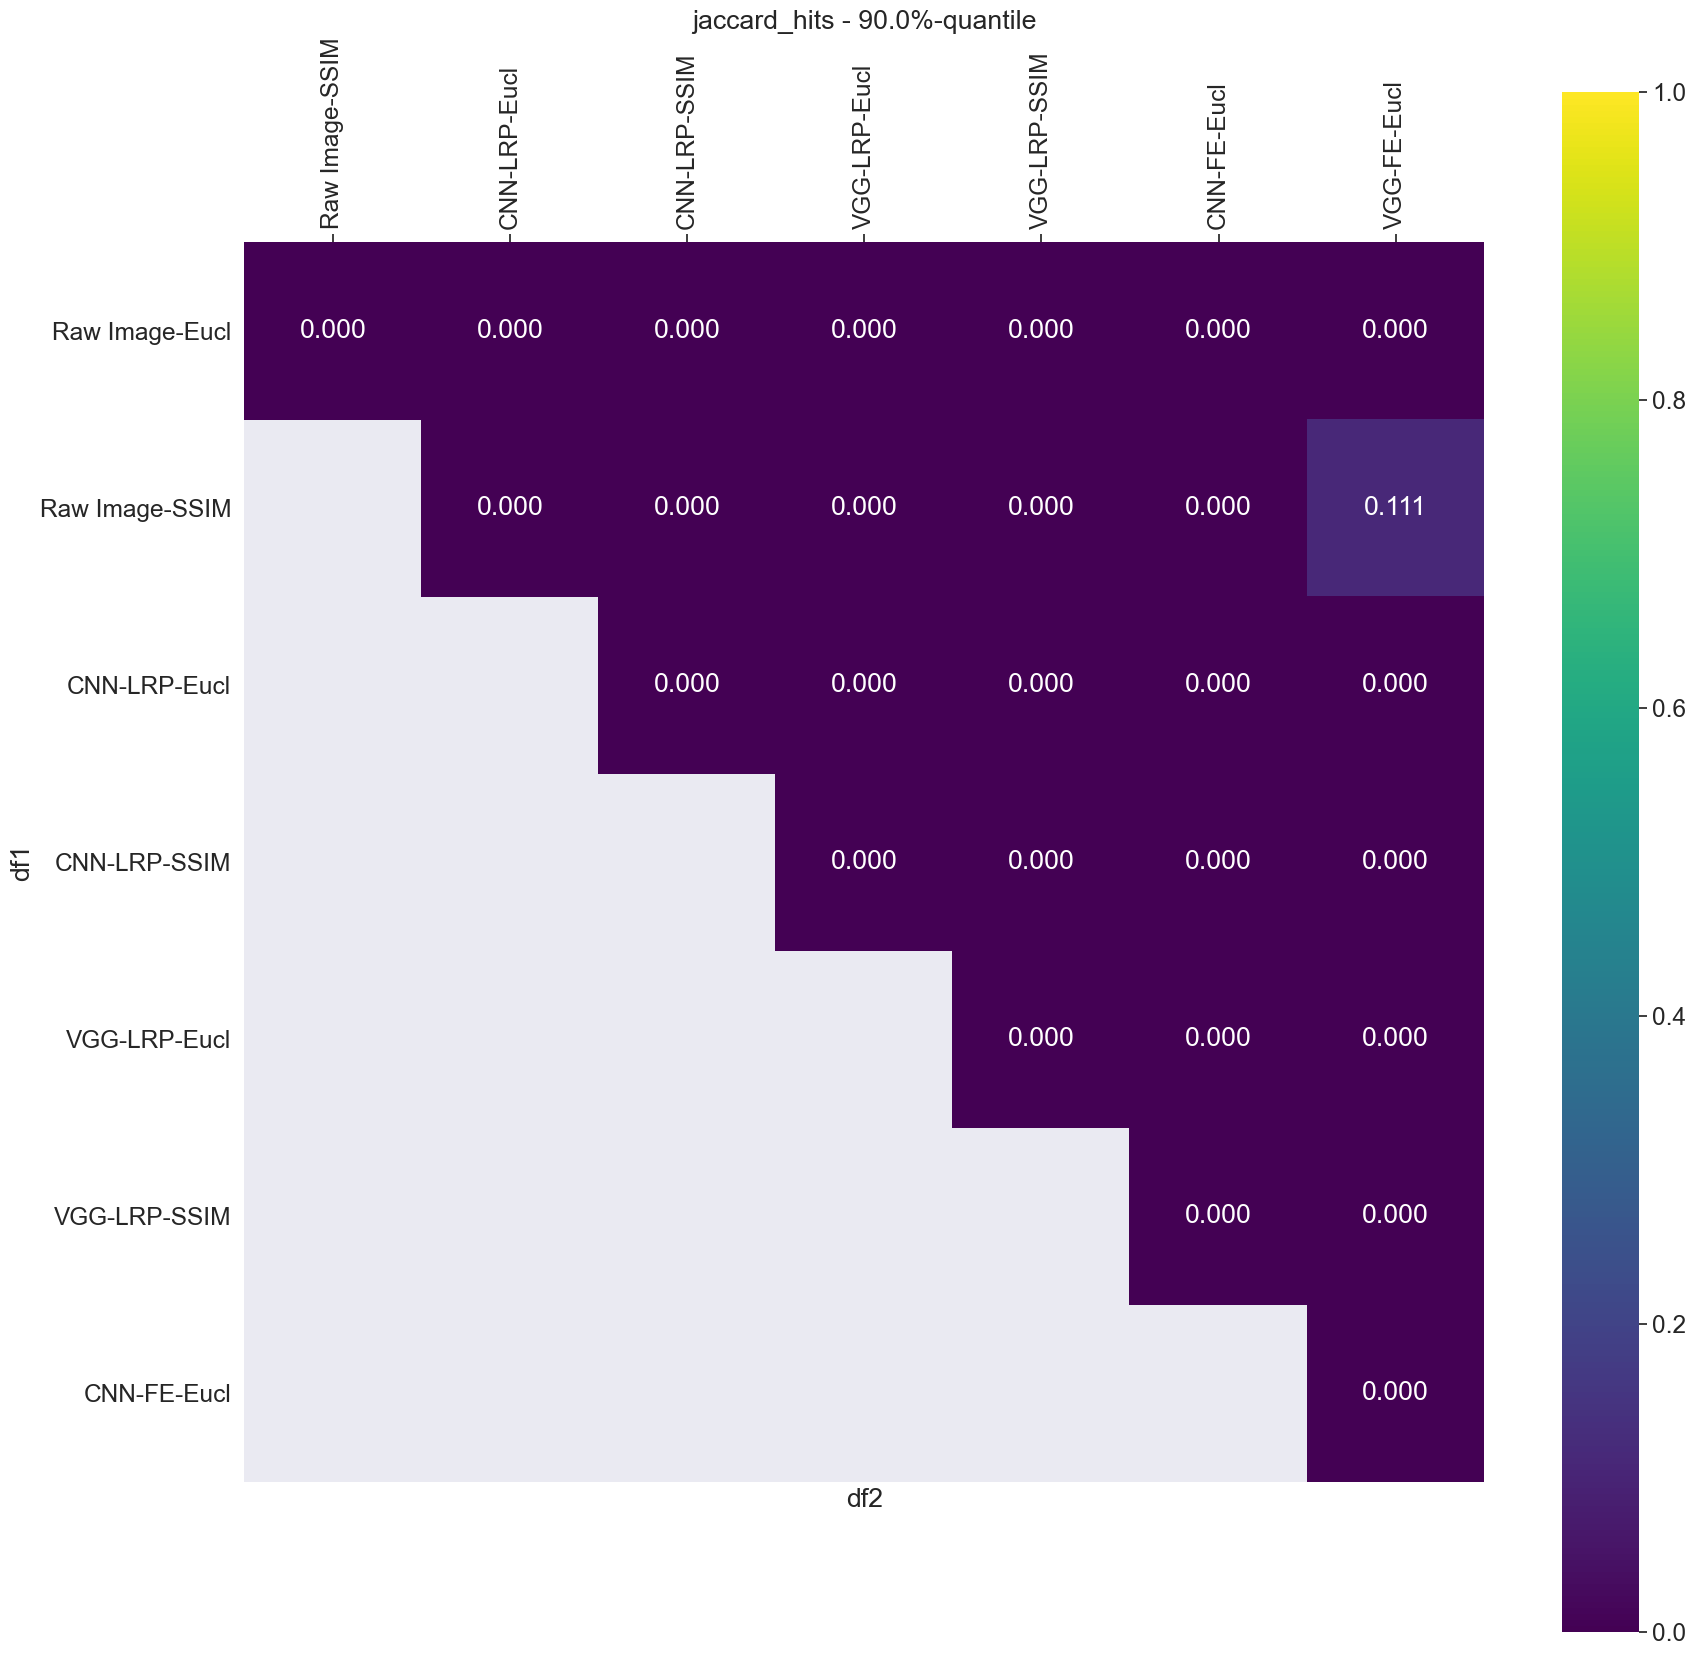

In [57]:
jaccards_heatmap(jaccards_oct2, "jaccard_misses", vmax=1, metric = "quantile", q=0.9, title = "Jaccard Indices for OCT Near Misses per Class - 90%-quantile")
jaccards_heatmap(jaccards_oct2, "jaccard_top_misses", vmax=1, metric = "quantile", q=0.9)
jaccards_heatmap(jaccards_oct2, "jaccard_hits", vmax=1, metric = "quantile", q=0.9)

In [58]:
sns.reset_defaults()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec703a72b0>,
      dtype=object)

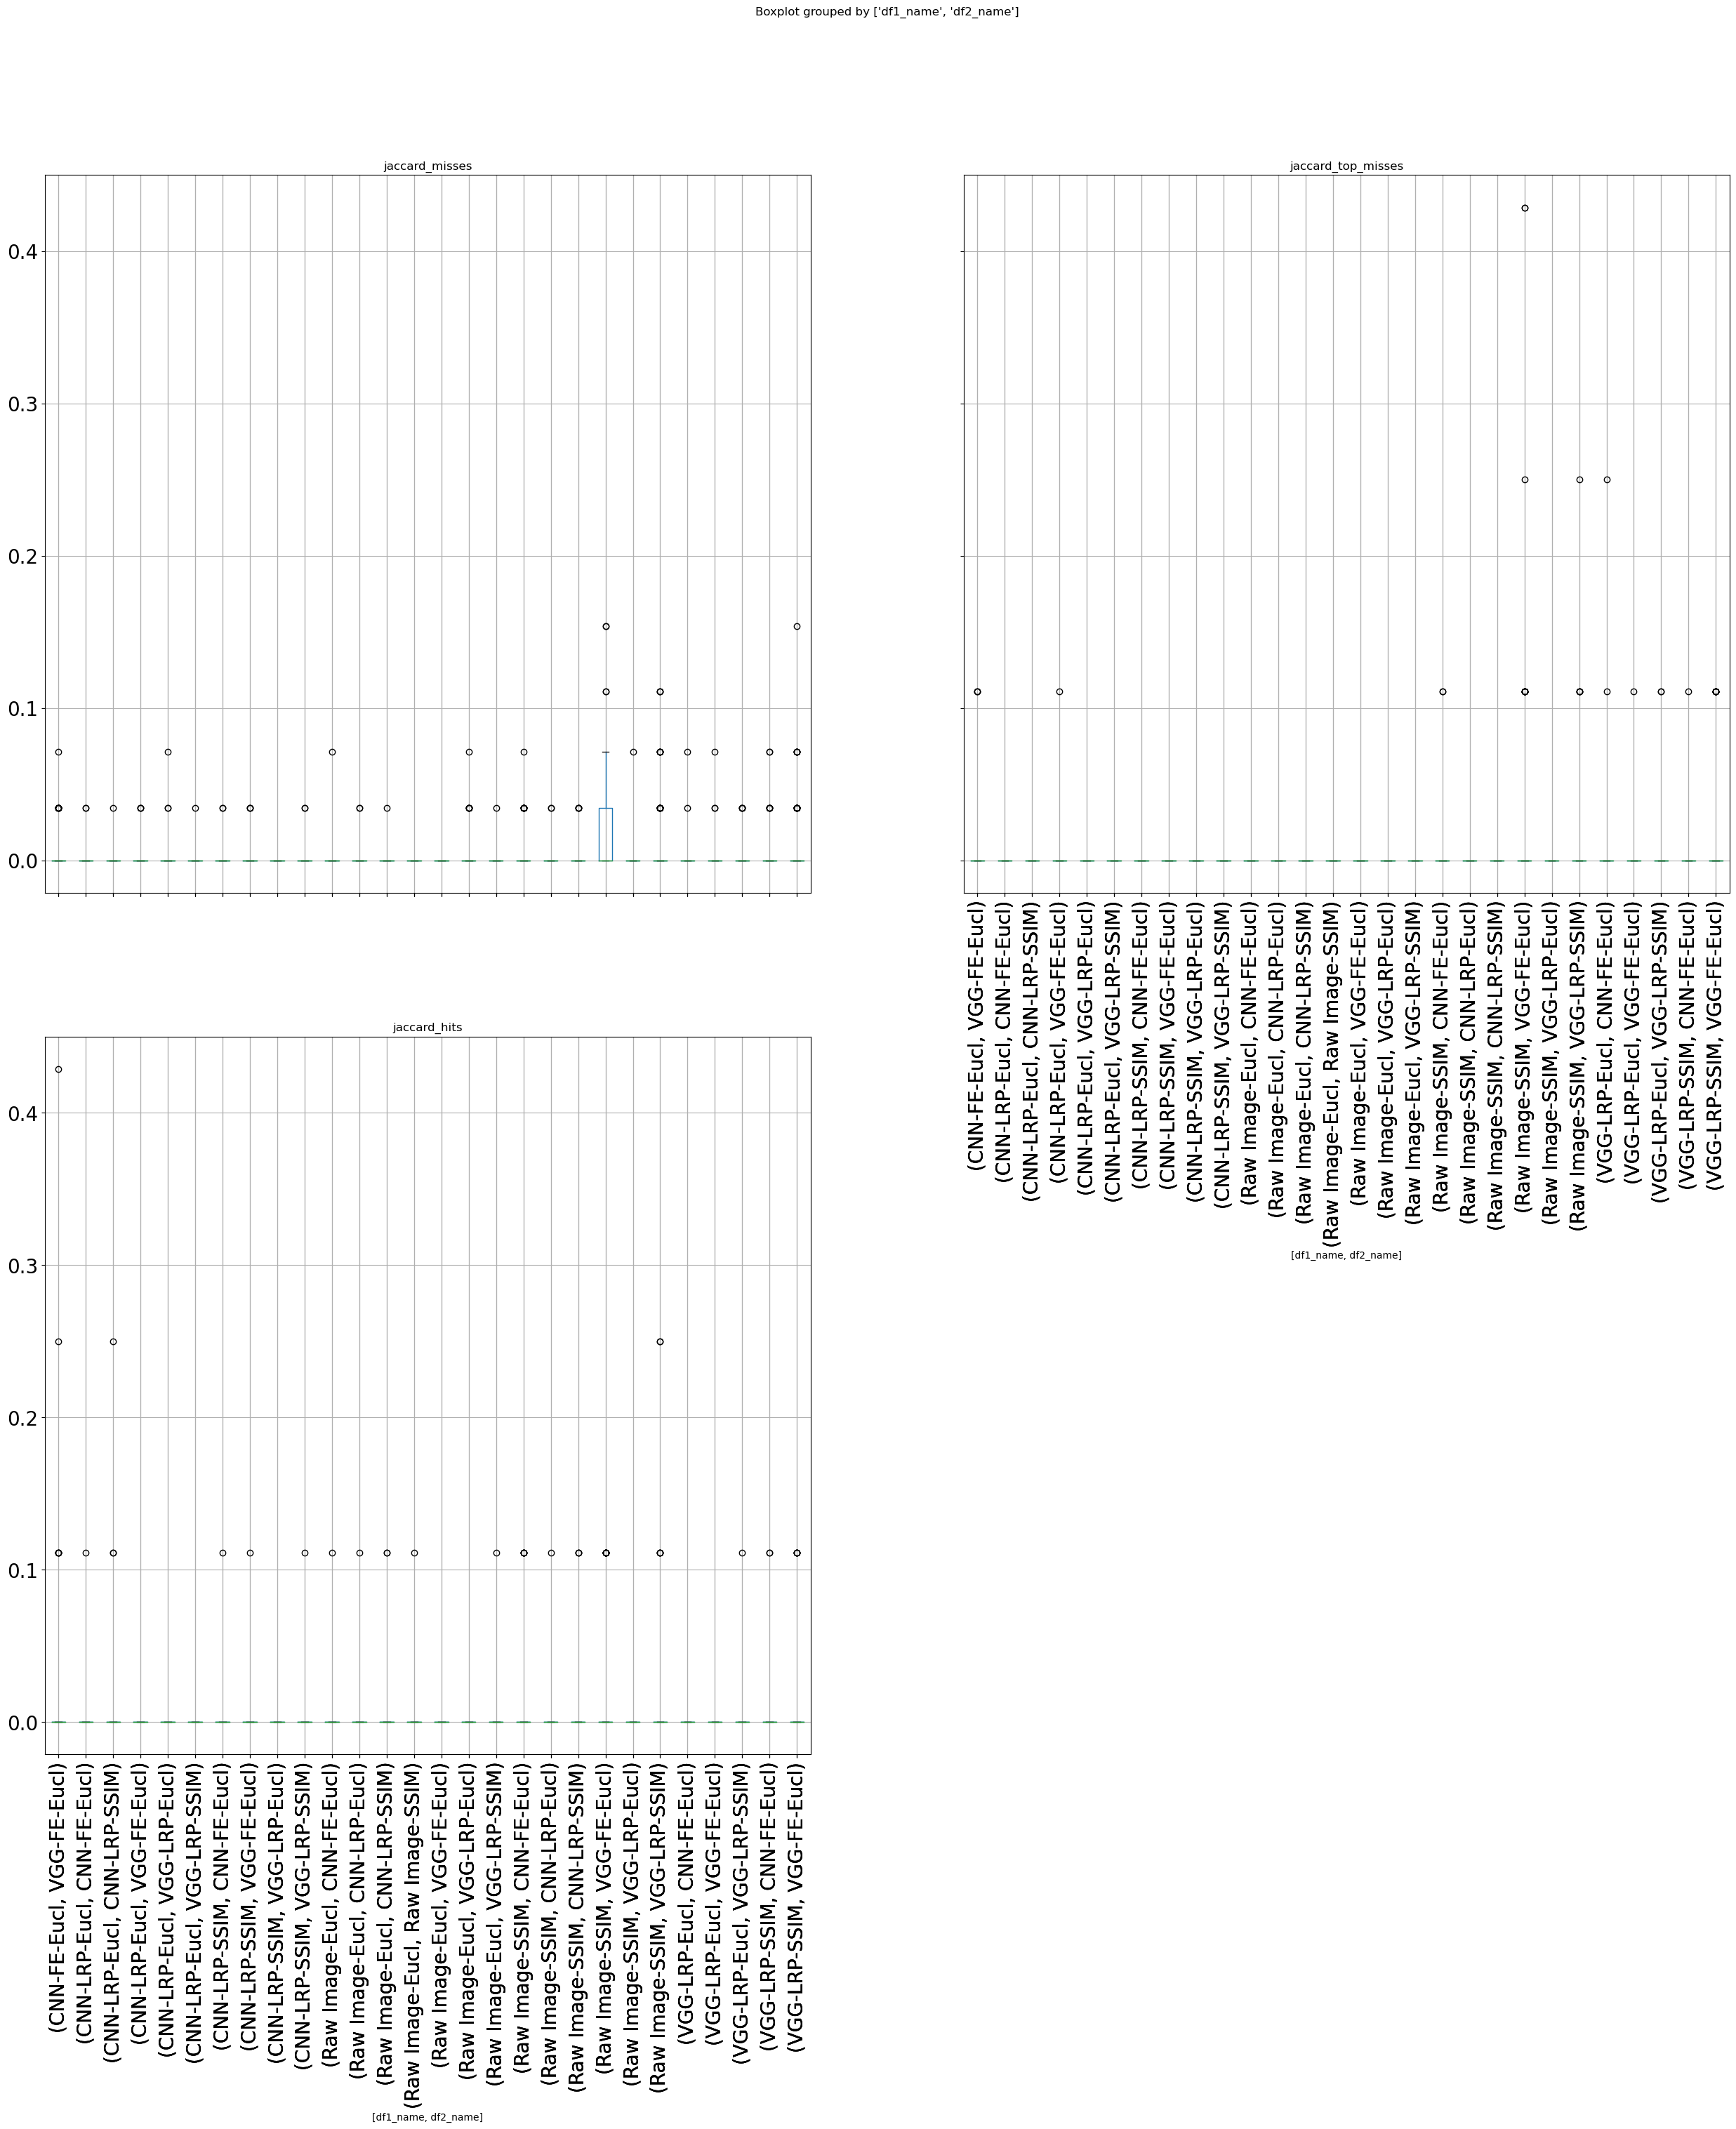

In [59]:
jaccards_oct2.boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], by=["df1_name", "df2_name"],
                 figsize=(30, 30), rot=90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec88d2df10>,
      dtype=object)

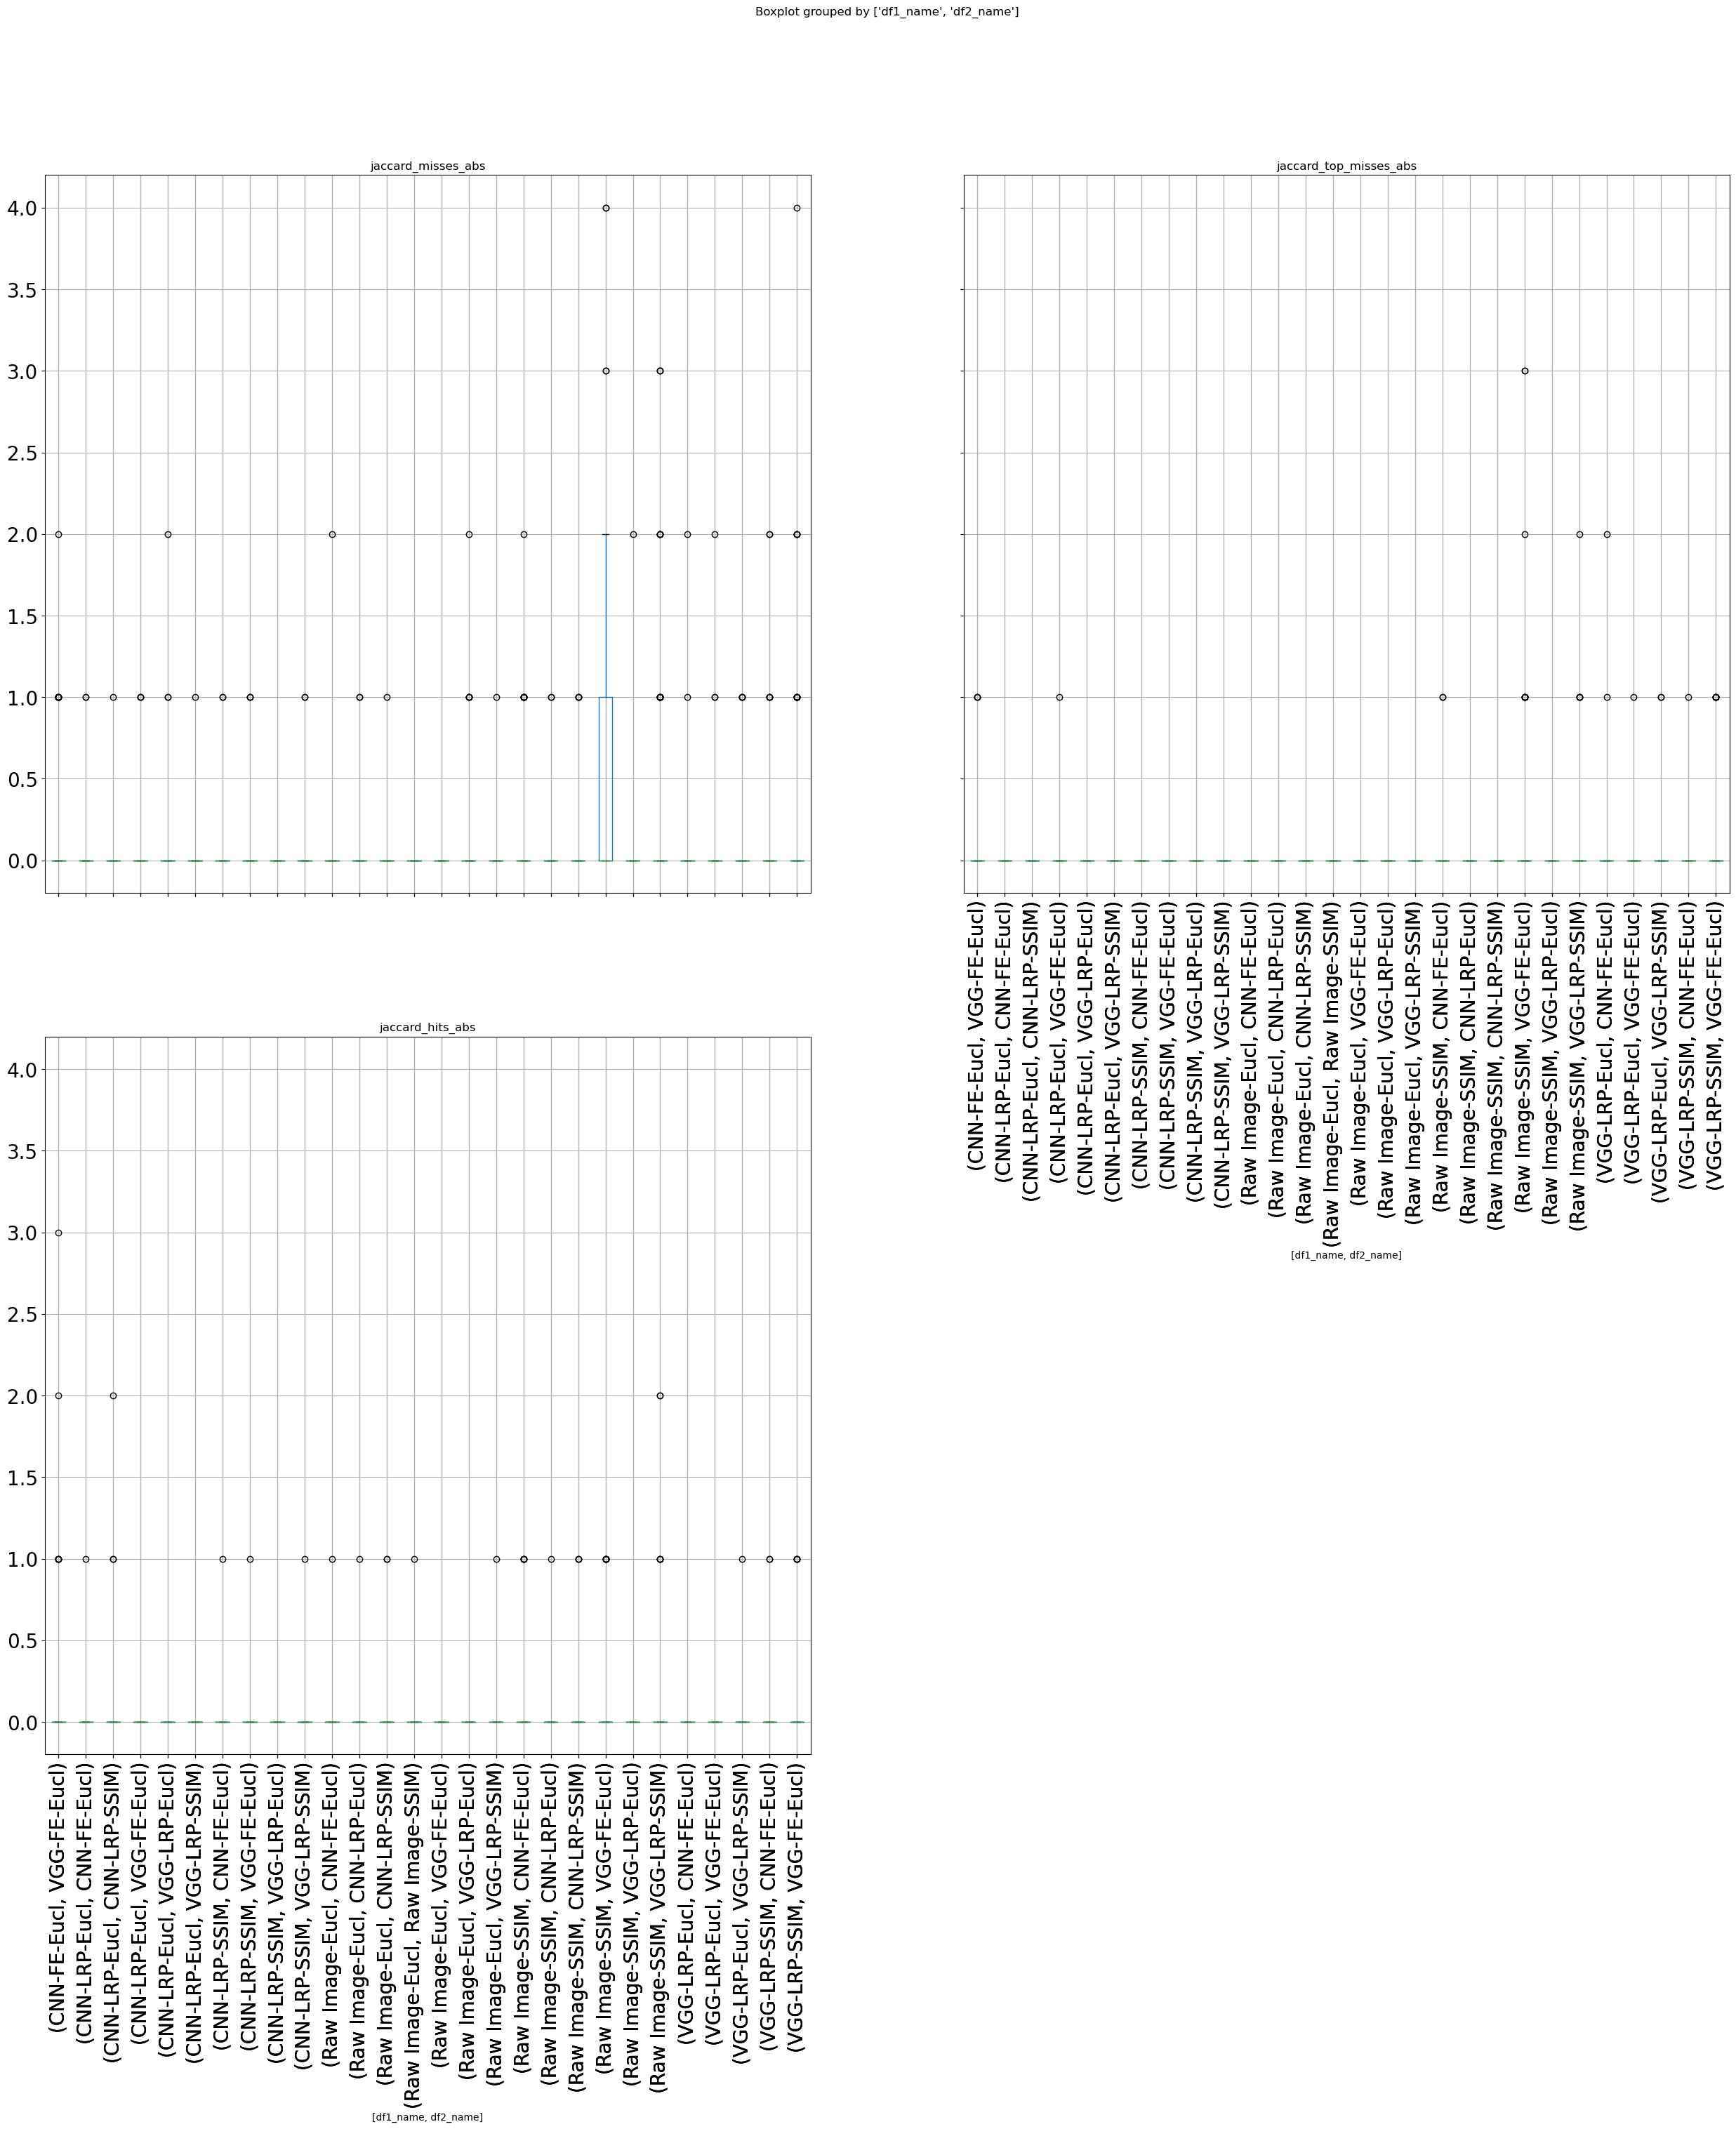

In [60]:
jaccards_oct2.boxplot(column=["jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"],
                 by=["df1_name", "df2_name"],
                 figsize=(30, 30), rot=90, fontsize=20)

#### Statistical tests

In [61]:
# t-test
c = 0
for m1 in jaccards_oct.group.value_counts().index:
    _, p = stats.ttest_1samp(a=jaccards_oct[jaccards_oct.group == m1]["jaccard_misses"], popmean=0)
    if p > 0.01:  # p value too big, these are not different from an all 0 distribution
        print(m1)
        print(p)
        c += 1
print(c)

1000_eucl_1010_eucl
0.15833990565972592
1011_ssim_1100_eucl
0.012368327828252472
1011_eucl_1101_eucl
0.10483637382293368
1011_eucl_1100_eucl
0.18311436884649937
1011_eucl_1011_ssim
0.04493472521263044
1010_ssim_1101_eucl
0.08324862524496107
1010_ssim_1100_eucl
0.15833990565972592
1010_ssim_1011_ssim
0.1583399056597258
1010_eucl_1101_eucl
0.083248625244961
1010_eucl_1100_eucl
0.15833990565972592
1010_eucl_1011_ssim
0.3197484741393017
1010_eucl_1011_eucl
0.10483637382293368
1010_eucl_1010_ssim
0.3197484741393017
1000_ssim_1011_eucl
0.31974847413930163
1000_ssim_1010_ssim
0.04493472521263044
1000_ssim_1010_eucl
0.15833990565972592
1000_eucl_1100_eucl
0.31974847413930163
1000_eucl_1011_ssim
0.3197484741393017
1000_eucl_1011_eucl
0.019571962254267942
1000_eucl_1010_ssim
0.3197484741393017
20


In [62]:
# comparison to all 0 vector
tmp = [0] * 100
c = 0
for m1 in jaccards_oct.group.value_counts().index:
    try:
        _, p = stats.wilcoxon(jaccards_oct[jaccards_oct.group == m1]["jaccard_misses"],tmp)
        if p > 0.01:  # p value too big, these are not different from an all 0 distribution
            print(m1)
            print(p)
            c += 1
    except ValueError:
        print(m1)
        print("all values 0")
        c += 1
print(c)

1000_eucl_1000_ssim
all values 0
1000_eucl_1010_eucl
0.15729920705028502
1011_ssim_1100_eucl
0.013874405883025447
1011_eucl_1101_eucl
0.10247043485974937
1011_eucl_1100_eucl
0.17971249487899976
1011_eucl_1011_ssim
0.04550026389635839
1010_ssim_1101_eucl
0.0832645166635504
1010_ssim_1100_eucl
0.15729920705028502
1010_ssim_1011_ssim
0.15729920705028502
1010_ssim_1011_eucl
all values 0
1010_eucl_1101_eucl
0.0832645166635504
1010_eucl_1100_eucl
0.15729920705028502
1010_eucl_1011_ssim
0.31731050786291415
1010_eucl_1011_eucl
0.10247043485974937
1010_eucl_1010_ssim
0.31731050786291415
1000_ssim_1011_eucl
0.31731050786291415
1000_ssim_1010_ssim
0.04550026389635839
1000_ssim_1010_eucl
0.15729920705028502
1000_eucl_1101_eucl
all values 0
1000_eucl_1100_eucl
0.31731050786291415
1000_eucl_1011_ssim
0.31731050786291415
1000_eucl_1011_eucl
0.019630657257290667
1000_eucl_1010_ssim
0.31731050786291415
23


/Users/biancazimmer/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


#### Results:
all distances:

same as for MNIST:
* Since Jaccard index is a measure of similarity 0 means that A nad B are totally different
* not surprisingly distances on the raw images produce same NHNM for CNN and VGG -> model is not used here anyway

different from MNIST:
* top 15 misses DO NOT yield higher jaccard indices than top misses in general
* all combinations have Jaccard Indices close to 0. This might have two reasons:
    * A lot more training samples to choose from (73k for oct vs 22k for mnist) -> more possibilities mean more possibile variety -> solution would be to first cluster the training examples and only take the near miss/hits from here
    * not enough test samples evaluated. 100 might not be enough
* if anything then the raw images evaluated with SSIM have some little points in common with the Euclidean distance on FE

-> Qualitative evaluation needed

In [ ]:
plt.close("all")